5# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will train your CNN-RNN model.  

You are welcome and encouraged to try out many different architectures and hyperparameters when searching for a good model.

This does have the potential to make the project quite messy!  Before submitting your project, make sure that you clean up:
- the code you write in this notebook.  The notebook should describe how to train a single CNN-RNN architecture, corresponding to your final choice of hyperparameters.  You should structure the notebook so that the reviewer can replicate your results by running the code in this notebook.  
- the output of the code cell in **Step 2**.  The output should show the output obtained when training the model from scratch.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model
- [Step 3](#step3): (Optional) Validate your Model

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

You should only amend blocks of code that are preceded by a `TODO` statement.  **Any code blocks that are not preceded by a `TODO` statement should not be modified**.

### Task #1

Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance!  **To avoid spending too long on this notebook**, you are encouraged to consult these suggested research papers to obtain a strong initial guess for which hyperparameters are likely to work best.  Then, train a single model, and proceed to the next notebook (**3_Inference.ipynb**).  If you are unhappy with your performance, you can return to this notebook to tweak the hyperparameters (and/or the architecture in **model.py**) and re-train your model.

### Question 1

**Question:** Describe your CNN-RNN architecture in detail.  With this architecture in mind, how did you select the values of the variables in Task 1?  If you consulted a research paper detailing a successful implementation of an image captioning model, please provide the reference.

**Answer:** 


### (Optional) Task #2

Note that we have provided a recommended image transform `transform_train` for pre-processing the training images, but you are welcome (and encouraged!) to modify it as you wish.  When modifying this transform, keep in mind that:
- the images in the dataset have varying heights and widths, and 
- if using a pre-trained model, you must perform the corresponding appropriate normalization.

### Question 2

**Question:** How did you select the transform in `transform_train`?  If you left the transform at its provided value, why do you think that it is a good choice for your CNN architecture?

**Answer:** 

### Task #3

Next, you will specify a Python list containing the learnable parameters of the model.  For instance, if you decide to make all weights in the decoder trainable, but only want to train the weights in the embedding layer of the encoder, then you should set `params` to something like:
```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

### Question 3

**Question:** How did you select the trainable parameters of your architecture?  Why do you think this is a good choice?

**Answer:** 

### Task #4

Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).

### Question 4

**Question:** How did you select the optimizer used to train your model?

**Answer:** 

## Installation of COCO API for Windows

In [11]:
%cd ..

G:\


In [12]:
! pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/philferriere/cocoapi.git to c:\users\susbr\appdata\local\temp\pip-req-build-80hmlavc
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-win_amd64.whl size=82747 sha256=ac98505831bc9221965f41528398f220a529f12ea32c8669cfdfc5e93ce74a24
  Stored in directory: C:\Users\susbr\AppData\Local\Temp\pip-ephem-wheel-cache-xid3iypn\wheels\69\2b\12\2fa959e49f73d26cff202c2f4e5079096c9c57c8a8509fd75c
Successfully built pycocotools


  Running command git clone -q https://github.com/philferriere/cocoapi.git 'C:\Users\susbr\AppData\Local\Temp\pip-req-build-80hmlavc'


In [ ]:
%cd cocoapi/PythonAPI/

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

## Installation for COCO API under Linux

In [ ]:
%cd /opt
! git clone https://github.com/cocodataset/cocoapi.git 

In [ ]:
%cd opt/cocoapi/PythonAPI  
! make  
%cd ..

## Downloading and extracting the data

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

In [ ]:
!unzip annotations_trainval2014.zip

In [ ]:
mkdir images

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip

In [ ]:
!unzip train2014.zip -d images

In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip

In [ ]:
!unzip val2014.zip -d images

## Setup for Google Colab
not really recommended, because downloading and extracting the dataset takes a long time!

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# % cd "/content/drive/My Drive/Colab Notebooks/ud-image-captioning"

## Setup for training the model

In [26]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
sys.path.append('G:/cocoapi/PythonAPI')
from pycocotools.coco import COCO
#from data_loader import get_loader
from data_loader_eval import get_loader
from model import EncoderCNN, DecoderRNN
import math
import torch.utils.data as data
import numpy as np
import os
import requests
import time
import json
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
%load_ext autoreload
%autoreload 2

In [1]:
# load missing library
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\susbr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
torch.cuda.is_available()

True

In [7]:
## TODO #1: Select appropriate values for the Python variables below.
batch_size = 128        # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = True  # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 5            # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity


In [8]:
# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Add validation tranforms
transform_val = transforms.Compose([ 
    #transforms.Resize(224),                          # smaller edge of image resized to 256
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


In [9]:

from data_loader_eval import get_loader

In [10]:
# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=2.46s)
creating index...


  0%|                                                                           | 286/414113 [00:00<02:25, 2843.11it/s]

index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [01:41<00:00, 4081.49it/s]


In [12]:
# Build validation data loader
val_data_loader = get_loader(transform=transform_val, 
                         mode='val')

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!


In [13]:
# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

In [14]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

<a id='step2'></a>
## Step 2: Train your Model

Once you have executed the code cell in **Step 1**, the training procedure below should run without issue.  

It is completely fine to leave the code cell below as-is without modifications to train your model.  However, if you would like to modify the code used to train the model below, you must ensure that your changes are easily parsed by your reviewer.  In other words, make sure to provide appropriate comments to describe how your code works!  

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

While trying out parameters, make sure to take extensive notes and record the settings that you used in your various training runs.  In particular, you don't want to encounter a situation where you've trained a model for several hours but can't remember what settings you used :).

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

For this project, you need not worry about overfitting. **This project does not have strict requirements regarding the performance of your model**, and you just need to demonstrate that your model has learned **_something_** when you generate captions on the test data.  For now, we strongly encourage you to train your model for the suggested 3 epochs without worrying about performance; then, you should immediately transition to the next notebook in the sequence (**3_Inference.ipynb**) to see how your model performs on the test data.  If your model needs to be changed, you can come back to this notebook, amend hyperparameters (if necessary), and re-train the model.

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

In [15]:
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('models', 'encoder-5.pkl')))
decoder.load_state_dict(torch.load(os.path.join('models', 'decoder-5.pkl')))

<All keys matched successfully>

In [33]:
# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
#response = requests.request("GET", 
#                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
#                           headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            #requests.request("POST", 
             #                "https://nebula.udacity.com/api/v1/remote/keep-alive", 
              #               headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

        #print ('Evaluation using BLEU: ')

# Close the training log file.
f.close()

torch.Size([128, 12, 512])
Epoch [1/5], Step [1/3236], Loss: 9.1807, Perplexity: 9708.2359torch.Size([128, 11, 512])
Epoch [1/5], Step [2/3236], Loss: 8.9351, Perplexity: 7594.2040torch.Size([128, 10, 512])
Epoch [1/5], Step [3/3236], Loss: 8.7502, Perplexity: 6312.2230torch.Size([128, 12, 512])
Epoch [1/5], Step [4/3236], Loss: 8.4204, Perplexity: 4538.5656torch.Size([128, 16, 512])
Epoch [1/5], Step [5/3236], Loss: 8.1542, Perplexity: 3478.0971torch.Size([128, 12, 512])
Epoch [1/5], Step [6/3236], Loss: 7.8094, Perplexity: 2463.5933torch.Size([128, 15, 512])
Epoch [1/5], Step [7/3236], Loss: 7.4771, Perplexity: 1767.1422torch.Size([128, 11, 512])
Epoch [1/5], Step [8/3236], Loss: 7.2110, Perplexity: 1354.2535torch.Size([128, 13, 512])
Epoch [1/5], Step [9/3236], Loss: 6.7312, Perplexity: 838.1410torch.Size([128, 11, 512])
Epoch [1/5], Step [10/3236], Loss: 6.4425, Perplexity: 627.9757torch.Size([128, 11, 512])
Epoch [1/5], Step [11/3236], Loss: 6.1373, Perplexity: 462.7796torch.Size(

Epoch [1/5], Step [183/3236], Loss: 3.0849, Perplexity: 21.8657torch.Size([128, 12, 512])
Epoch [1/5], Step [184/3236], Loss: 3.2586, Perplexity: 26.0127torch.Size([128, 10, 512])
Epoch [1/5], Step [185/3236], Loss: 3.6579, Perplexity: 38.7801torch.Size([128, 13, 512])
Epoch [1/5], Step [186/3236], Loss: 3.1277, Perplexity: 22.8221torch.Size([128, 13, 512])
Epoch [1/5], Step [187/3236], Loss: 3.1105, Perplexity: 22.4333torch.Size([128, 15, 512])
Epoch [1/5], Step [188/3236], Loss: 3.3492, Perplexity: 28.4798torch.Size([128, 10, 512])
Epoch [1/5], Step [189/3236], Loss: 3.3598, Perplexity: 28.7839torch.Size([128, 11, 512])
Epoch [1/5], Step [190/3236], Loss: 3.1574, Perplexity: 23.5099torch.Size([128, 12, 512])
Epoch [1/5], Step [191/3236], Loss: 3.1395, Perplexity: 23.0917torch.Size([128, 15, 512])
Epoch [1/5], Step [192/3236], Loss: 3.2974, Perplexity: 27.0412torch.Size([128, 15, 512])
Epoch [1/5], Step [193/3236], Loss: 3.2608, Perplexity: 26.0694torch.Size([128, 13, 512])
Epoch [1/5

Epoch [1/5], Step [365/3236], Loss: 2.8630, Perplexity: 17.5138torch.Size([128, 13, 512])
Epoch [1/5], Step [366/3236], Loss: 2.6018, Perplexity: 13.4877torch.Size([128, 17, 512])
Epoch [1/5], Step [367/3236], Loss: 3.0710, Perplexity: 21.5635torch.Size([128, 12, 512])
Epoch [1/5], Step [368/3236], Loss: 2.7001, Perplexity: 14.8808torch.Size([128, 13, 512])
Epoch [1/5], Step [369/3236], Loss: 2.6871, Perplexity: 14.6890torch.Size([128, 11, 512])
Epoch [1/5], Step [370/3236], Loss: 2.8004, Perplexity: 16.4505torch.Size([128, 12, 512])
Epoch [1/5], Step [371/3236], Loss: 2.7207, Perplexity: 15.1917torch.Size([128, 14, 512])
Epoch [1/5], Step [372/3236], Loss: 2.7755, Perplexity: 16.0470torch.Size([128, 12, 512])
Epoch [1/5], Step [373/3236], Loss: 2.7566, Perplexity: 15.7468torch.Size([128, 12, 512])
Epoch [1/5], Step [374/3236], Loss: 2.7399, Perplexity: 15.4858torch.Size([128, 15, 512])
Epoch [1/5], Step [375/3236], Loss: 2.8967, Perplexity: 18.1137torch.Size([128, 12, 512])
Epoch [1/5

Epoch [1/5], Step [547/3236], Loss: 2.7370, Perplexity: 15.4413torch.Size([128, 13, 512])
Epoch [1/5], Step [548/3236], Loss: 2.5400, Perplexity: 12.6799torch.Size([128, 14, 512])
Epoch [1/5], Step [549/3236], Loss: 2.6235, Perplexity: 13.7837torch.Size([128, 14, 512])
Epoch [1/5], Step [550/3236], Loss: 2.7064, Perplexity: 14.9754torch.Size([128, 11, 512])
Epoch [1/5], Step [551/3236], Loss: 2.6624, Perplexity: 14.3300torch.Size([128, 12, 512])
Epoch [1/5], Step [552/3236], Loss: 2.7208, Perplexity: 15.1926torch.Size([128, 15, 512])
Epoch [1/5], Step [553/3236], Loss: 2.7535, Perplexity: 15.6972torch.Size([128, 17, 512])
Epoch [1/5], Step [554/3236], Loss: 2.7635, Perplexity: 15.8548torch.Size([128, 14, 512])
Epoch [1/5], Step [555/3236], Loss: 2.5307, Perplexity: 12.5619torch.Size([128, 15, 512])
Epoch [1/5], Step [556/3236], Loss: 2.6892, Perplexity: 14.7202torch.Size([128, 12, 512])
Epoch [1/5], Step [557/3236], Loss: 2.5631, Perplexity: 12.9754torch.Size([128, 16, 512])
Epoch [1/5

Epoch [1/5], Step [729/3236], Loss: 2.4683, Perplexity: 11.8021torch.Size([128, 12, 512])
Epoch [1/5], Step [730/3236], Loss: 2.5006, Perplexity: 12.1895torch.Size([128, 10, 512])
Epoch [1/5], Step [731/3236], Loss: 2.7194, Perplexity: 15.1705torch.Size([128, 15, 512])
Epoch [1/5], Step [732/3236], Loss: 2.6743, Perplexity: 14.5022torch.Size([128, 13, 512])
Epoch [1/5], Step [733/3236], Loss: 2.5461, Perplexity: 12.7572torch.Size([128, 13, 512])
Epoch [1/5], Step [734/3236], Loss: 2.4159, Perplexity: 11.1995torch.Size([128, 13, 512])
Epoch [1/5], Step [735/3236], Loss: 2.4579, Perplexity: 11.6805torch.Size([128, 13, 512])
Epoch [1/5], Step [736/3236], Loss: 2.4441, Perplexity: 11.5200torch.Size([128, 14, 512])
Epoch [1/5], Step [737/3236], Loss: 2.6272, Perplexity: 13.8354torch.Size([128, 19, 512])
Epoch [1/5], Step [738/3236], Loss: 3.1173, Perplexity: 22.5855torch.Size([128, 12, 512])
Epoch [1/5], Step [739/3236], Loss: 2.4666, Perplexity: 11.7818torch.Size([128, 11, 512])
Epoch [1/5

Epoch [1/5], Step [911/3236], Loss: 2.7880, Perplexity: 16.2490torch.Size([128, 14, 512])
Epoch [1/5], Step [912/3236], Loss: 2.5404, Perplexity: 12.6849torch.Size([128, 13, 512])
Epoch [1/5], Step [913/3236], Loss: 2.3790, Perplexity: 10.7942torch.Size([128, 13, 512])
Epoch [1/5], Step [914/3236], Loss: 2.4190, Perplexity: 11.2348torch.Size([128, 11, 512])
Epoch [1/5], Step [915/3236], Loss: 2.5229, Perplexity: 12.4651torch.Size([128, 12, 512])
Epoch [1/5], Step [916/3236], Loss: 2.4155, Perplexity: 11.1951torch.Size([128, 15, 512])
Epoch [1/5], Step [917/3236], Loss: 2.5265, Perplexity: 12.5095torch.Size([128, 9, 512])
Epoch [1/5], Step [918/3236], Loss: 2.7572, Perplexity: 15.7552torch.Size([128, 15, 512])
Epoch [1/5], Step [919/3236], Loss: 2.4526, Perplexity: 11.6189torch.Size([128, 13, 512])
Epoch [1/5], Step [920/3236], Loss: 2.3671, Perplexity: 10.6661torch.Size([128, 12, 512])
Epoch [1/5], Step [921/3236], Loss: 2.3458, Perplexity: 10.4414torch.Size([128, 11, 512])
Epoch [1/5]

Epoch [1/5], Step [1092/3236], Loss: 2.8115, Perplexity: 16.6342torch.Size([128, 12, 512])
Epoch [1/5], Step [1093/3236], Loss: 2.3841, Perplexity: 10.8490torch.Size([128, 18, 512])
Epoch [1/5], Step [1094/3236], Loss: 2.7853, Perplexity: 16.2044torch.Size([128, 10, 512])
Epoch [1/5], Step [1095/3236], Loss: 2.6594, Perplexity: 14.2881torch.Size([128, 10, 512])
Epoch [1/5], Step [1096/3236], Loss: 2.6211, Perplexity: 13.7512torch.Size([128, 11, 512])
Epoch [1/5], Step [1097/3236], Loss: 2.3879, Perplexity: 10.8901torch.Size([128, 10, 512])
Epoch [1/5], Step [1098/3236], Loss: 2.7230, Perplexity: 15.2264torch.Size([128, 13, 512])
Epoch [1/5], Step [1099/3236], Loss: 2.2904, Perplexity: 9.8790torch.Size([128, 12, 512])
Epoch [1/5], Step [1100/3236], Loss: 2.4514, Perplexity: 11.6044
torch.Size([128, 14, 512])
Epoch [1/5], Step [1101/3236], Loss: 2.4736, Perplexity: 11.8653torch.Size([128, 13, 512])
Epoch [1/5], Step [1102/3236], Loss: 2.3513, Perplexity: 10.4988torch.Size([128, 14, 512])

Epoch [1/5], Step [1272/3236], Loss: 2.3367, Perplexity: 10.3475torch.Size([128, 11, 512])
Epoch [1/5], Step [1273/3236], Loss: 2.3086, Perplexity: 10.0608torch.Size([128, 12, 512])
Epoch [1/5], Step [1274/3236], Loss: 2.4324, Perplexity: 11.3865torch.Size([128, 11, 512])
Epoch [1/5], Step [1275/3236], Loss: 2.3790, Perplexity: 10.7937torch.Size([128, 12, 512])
Epoch [1/5], Step [1276/3236], Loss: 2.2659, Perplexity: 9.6400torch.Size([128, 18, 512])
Epoch [1/5], Step [1277/3236], Loss: 2.8462, Perplexity: 17.2228torch.Size([128, 16, 512])
Epoch [1/5], Step [1278/3236], Loss: 2.6810, Perplexity: 14.6001torch.Size([128, 13, 512])
Epoch [1/5], Step [1279/3236], Loss: 2.3177, Perplexity: 10.1520torch.Size([128, 13, 512])
Epoch [1/5], Step [1280/3236], Loss: 2.3081, Perplexity: 10.0551torch.Size([128, 13, 512])
Epoch [1/5], Step [1281/3236], Loss: 2.2690, Perplexity: 9.6696torch.Size([128, 11, 512])
Epoch [1/5], Step [1282/3236], Loss: 2.3566, Perplexity: 10.5549torch.Size([128, 15, 512])
E

Epoch [1/5], Step [1452/3236], Loss: 2.6977, Perplexity: 14.8455torch.Size([128, 12, 512])
Epoch [1/5], Step [1453/3236], Loss: 2.3006, Perplexity: 9.9800torch.Size([128, 15, 512])
Epoch [1/5], Step [1454/3236], Loss: 2.4919, Perplexity: 12.0844torch.Size([128, 21, 512])
Epoch [1/5], Step [1455/3236], Loss: 3.0864, Perplexity: 21.8972torch.Size([128, 10, 512])
Epoch [1/5], Step [1456/3236], Loss: 2.5269, Perplexity: 12.5143torch.Size([128, 13, 512])
Epoch [1/5], Step [1457/3236], Loss: 2.2617, Perplexity: 9.5990torch.Size([128, 15, 512])
Epoch [1/5], Step [1458/3236], Loss: 2.4101, Perplexity: 11.1352torch.Size([128, 15, 512])
Epoch [1/5], Step [1459/3236], Loss: 2.4602, Perplexity: 11.7068torch.Size([128, 14, 512])
Epoch [1/5], Step [1460/3236], Loss: 2.3064, Perplexity: 10.0380torch.Size([128, 13, 512])
Epoch [1/5], Step [1461/3236], Loss: 2.2008, Perplexity: 9.0327torch.Size([128, 15, 512])
Epoch [1/5], Step [1462/3236], Loss: 2.2926, Perplexity: 9.9002torch.Size([128, 13, 512])
Epo

Epoch [1/5], Step [1632/3236], Loss: 2.3601, Perplexity: 10.5920torch.Size([128, 11, 512])
Epoch [1/5], Step [1633/3236], Loss: 2.2824, Perplexity: 9.8006torch.Size([128, 14, 512])
Epoch [1/5], Step [1634/3236], Loss: 2.2232, Perplexity: 9.2369torch.Size([128, 14, 512])
Epoch [1/5], Step [1635/3236], Loss: 2.4452, Perplexity: 11.5333torch.Size([128, 12, 512])
Epoch [1/5], Step [1636/3236], Loss: 2.2461, Perplexity: 9.4509torch.Size([128, 12, 512])
Epoch [1/5], Step [1637/3236], Loss: 2.2176, Perplexity: 9.1855torch.Size([128, 12, 512])
Epoch [1/5], Step [1638/3236], Loss: 2.3422, Perplexity: 10.4044torch.Size([128, 14, 512])
Epoch [1/5], Step [1639/3236], Loss: 2.1805, Perplexity: 8.8510torch.Size([128, 12, 512])
Epoch [1/5], Step [1640/3236], Loss: 2.2439, Perplexity: 9.4301torch.Size([128, 12, 512])
Epoch [1/5], Step [1641/3236], Loss: 2.2396, Perplexity: 9.3900torch.Size([128, 13, 512])
Epoch [1/5], Step [1642/3236], Loss: 2.2158, Perplexity: 9.1691torch.Size([128, 14, 512])
Epoch [

Epoch [1/5], Step [1812/3236], Loss: 2.1542, Perplexity: 8.6206torch.Size([128, 13, 512])
Epoch [1/5], Step [1813/3236], Loss: 2.2344, Perplexity: 9.3409torch.Size([128, 14, 512])
Epoch [1/5], Step [1814/3236], Loss: 2.2478, Perplexity: 9.4668torch.Size([128, 21, 512])
Epoch [1/5], Step [1815/3236], Loss: 3.0837, Perplexity: 21.8391torch.Size([128, 15, 512])
Epoch [1/5], Step [1816/3236], Loss: 2.3985, Perplexity: 11.0068torch.Size([128, 12, 512])
Epoch [1/5], Step [1817/3236], Loss: 2.2238, Perplexity: 9.2423torch.Size([128, 13, 512])
Epoch [1/5], Step [1818/3236], Loss: 2.2034, Perplexity: 9.0556torch.Size([128, 13, 512])
Epoch [1/5], Step [1819/3236], Loss: 2.2959, Perplexity: 9.9337torch.Size([128, 22, 512])
Epoch [1/5], Step [1820/3236], Loss: 3.2715, Perplexity: 26.3510torch.Size([128, 16, 512])
Epoch [1/5], Step [1821/3236], Loss: 2.5743, Perplexity: 13.1222torch.Size([128, 12, 512])
Epoch [1/5], Step [1822/3236], Loss: 2.3071, Perplexity: 10.0457torch.Size([128, 13, 512])
Epoch

Epoch [1/5], Step [1992/3236], Loss: 2.3907, Perplexity: 10.9213torch.Size([128, 12, 512])
Epoch [1/5], Step [1993/3236], Loss: 2.2197, Perplexity: 9.2043torch.Size([128, 13, 512])
Epoch [1/5], Step [1994/3236], Loss: 2.2453, Perplexity: 9.4437torch.Size([128, 12, 512])
Epoch [1/5], Step [1995/3236], Loss: 2.2281, Perplexity: 9.2824torch.Size([128, 10, 512])
Epoch [1/5], Step [1996/3236], Loss: 2.6369, Perplexity: 13.9703torch.Size([128, 14, 512])
Epoch [1/5], Step [1997/3236], Loss: 2.1800, Perplexity: 8.8461torch.Size([128, 12, 512])
Epoch [1/5], Step [1998/3236], Loss: 2.1505, Perplexity: 8.5890torch.Size([128, 11, 512])
Epoch [1/5], Step [1999/3236], Loss: 2.1529, Perplexity: 8.6101torch.Size([128, 12, 512])
Epoch [1/5], Step [2000/3236], Loss: 2.2194, Perplexity: 9.2017
torch.Size([128, 10, 512])
Epoch [1/5], Step [2001/3236], Loss: 2.4661, Perplexity: 11.7763torch.Size([128, 10, 512])
Epoch [1/5], Step [2002/3236], Loss: 2.4528, Perplexity: 11.6204torch.Size([128, 17, 512])
Epoch

Epoch [1/5], Step [2172/3236], Loss: 2.2918, Perplexity: 9.8930torch.Size([128, 11, 512])
Epoch [1/5], Step [2173/3236], Loss: 2.2000, Perplexity: 9.0247torch.Size([128, 13, 512])
Epoch [1/5], Step [2174/3236], Loss: 2.1060, Perplexity: 8.2157torch.Size([128, 10, 512])
Epoch [1/5], Step [2175/3236], Loss: 2.3923, Perplexity: 10.9385torch.Size([128, 13, 512])
Epoch [1/5], Step [2176/3236], Loss: 2.2179, Perplexity: 9.1878torch.Size([128, 12, 512])
Epoch [1/5], Step [2177/3236], Loss: 2.1124, Perplexity: 8.2683torch.Size([128, 14, 512])
Epoch [1/5], Step [2178/3236], Loss: 2.2931, Perplexity: 9.9055torch.Size([128, 16, 512])
Epoch [1/5], Step [2179/3236], Loss: 2.3609, Perplexity: 10.6002torch.Size([128, 18, 512])
Epoch [1/5], Step [2180/3236], Loss: 2.7182, Perplexity: 15.1528torch.Size([128, 18, 512])
Epoch [1/5], Step [2181/3236], Loss: 2.6156, Perplexity: 13.6751torch.Size([128, 15, 512])
Epoch [1/5], Step [2182/3236], Loss: 2.3022, Perplexity: 9.9965torch.Size([128, 11, 512])
Epoch 

Epoch [1/5], Step [2352/3236], Loss: 2.2840, Perplexity: 9.8158torch.Size([128, 11, 512])
Epoch [1/5], Step [2353/3236], Loss: 2.4566, Perplexity: 11.6647torch.Size([128, 11, 512])
Epoch [1/5], Step [2354/3236], Loss: 2.2146, Perplexity: 9.1581torch.Size([128, 13, 512])
Epoch [1/5], Step [2355/3236], Loss: 2.1223, Perplexity: 8.3501torch.Size([128, 10, 512])
Epoch [1/5], Step [2356/3236], Loss: 2.5905, Perplexity: 13.3363torch.Size([128, 15, 512])
Epoch [1/5], Step [2357/3236], Loss: 2.4205, Perplexity: 11.2514torch.Size([128, 15, 512])
Epoch [1/5], Step [2358/3236], Loss: 2.2948, Perplexity: 9.9220torch.Size([128, 15, 512])
Epoch [1/5], Step [2359/3236], Loss: 2.3613, Perplexity: 10.6045torch.Size([128, 13, 512])
Epoch [1/5], Step [2360/3236], Loss: 2.2554, Perplexity: 9.5390torch.Size([128, 15, 512])
Epoch [1/5], Step [2361/3236], Loss: 2.3286, Perplexity: 10.2638torch.Size([128, 12, 512])
Epoch [1/5], Step [2362/3236], Loss: 2.0760, Perplexity: 7.9727torch.Size([128, 12, 512])
Epoch

Epoch [1/5], Step [2533/3236], Loss: 2.0711, Perplexity: 7.9333torch.Size([128, 10, 512])
Epoch [1/5], Step [2534/3236], Loss: 2.3634, Perplexity: 10.6273torch.Size([128, 13, 512])
Epoch [1/5], Step [2535/3236], Loss: 2.2102, Perplexity: 9.1175torch.Size([128, 11, 512])
Epoch [1/5], Step [2536/3236], Loss: 2.2998, Perplexity: 9.9724torch.Size([128, 10, 512])
Epoch [1/5], Step [2537/3236], Loss: 2.3566, Perplexity: 10.5547torch.Size([128, 13, 512])
Epoch [1/5], Step [2538/3236], Loss: 2.1184, Perplexity: 8.3176torch.Size([128, 15, 512])
Epoch [1/5], Step [2539/3236], Loss: 2.2858, Perplexity: 9.8338torch.Size([128, 13, 512])
Epoch [1/5], Step [2540/3236], Loss: 2.1092, Perplexity: 8.2416torch.Size([128, 12, 512])
Epoch [1/5], Step [2541/3236], Loss: 2.2347, Perplexity: 9.3434torch.Size([128, 15, 512])
Epoch [1/5], Step [2542/3236], Loss: 2.3354, Perplexity: 10.3338torch.Size([128, 12, 512])
Epoch [1/5], Step [2543/3236], Loss: 2.1825, Perplexity: 8.8682torch.Size([128, 15, 512])
Epoch [

Epoch [1/5], Step [2624/3236], Loss: 2.0732, Perplexity: 7.9498torch.Size([128, 15, 512])
Epoch [1/5], Step [2625/3236], Loss: 2.2456, Perplexity: 9.4459torch.Size([128, 12, 512])
Epoch [1/5], Step [2626/3236], Loss: 2.2896, Perplexity: 9.8715torch.Size([128, 18, 512])
Epoch [1/5], Step [2627/3236], Loss: 2.6351, Perplexity: 13.9450torch.Size([128, 12, 512])
Epoch [1/5], Step [2628/3236], Loss: 2.0847, Perplexity: 8.0424torch.Size([128, 11, 512])
Epoch [1/5], Step [2629/3236], Loss: 2.1679, Perplexity: 8.7403torch.Size([128, 15, 512])
Epoch [1/5], Step [2630/3236], Loss: 2.2541, Perplexity: 9.5272torch.Size([128, 12, 512])
Epoch [1/5], Step [2631/3236], Loss: 1.9873, Perplexity: 7.2958torch.Size([128, 12, 512])
Epoch [1/5], Step [2632/3236], Loss: 2.0977, Perplexity: 8.1474torch.Size([128, 12, 512])
Epoch [1/5], Step [2633/3236], Loss: 2.1941, Perplexity: 8.9717torch.Size([128, 15, 512])
Epoch [1/5], Step [2634/3236], Loss: 2.2536, Perplexity: 9.5220torch.Size([128, 14, 512])
Epoch [1/

Epoch [1/5], Step [2715/3236], Loss: 2.1762, Perplexity: 8.8128torch.Size([128, 12, 512])
Epoch [1/5], Step [2716/3236], Loss: 2.2211, Perplexity: 9.2175torch.Size([128, 12, 512])
Epoch [1/5], Step [2717/3236], Loss: 2.1443, Perplexity: 8.5360torch.Size([128, 13, 512])
Epoch [1/5], Step [2718/3236], Loss: 1.9441, Perplexity: 6.9874torch.Size([128, 15, 512])
Epoch [1/5], Step [2719/3236], Loss: 2.1524, Perplexity: 8.6055torch.Size([128, 13, 512])
Epoch [1/5], Step [2720/3236], Loss: 2.1303, Perplexity: 8.4177torch.Size([128, 11, 512])
Epoch [1/5], Step [2721/3236], Loss: 2.1759, Perplexity: 8.8101torch.Size([128, 23, 512])
Epoch [1/5], Step [2722/3236], Loss: 3.0054, Perplexity: 20.1943torch.Size([128, 13, 512])
Epoch [1/5], Step [2723/3236], Loss: 2.1569, Perplexity: 8.6440torch.Size([128, 18, 512])
Epoch [1/5], Step [2724/3236], Loss: 2.6662, Perplexity: 14.3849torch.Size([128, 15, 512])
Epoch [1/5], Step [2725/3236], Loss: 2.1558, Perplexity: 8.6351torch.Size([128, 10, 512])
Epoch [1

Epoch [1/5], Step [2806/3236], Loss: 2.1940, Perplexity: 8.9711torch.Size([128, 15, 512])
Epoch [1/5], Step [2807/3236], Loss: 2.1667, Perplexity: 8.7292torch.Size([128, 11, 512])
Epoch [1/5], Step [2808/3236], Loss: 2.2165, Perplexity: 9.1756torch.Size([128, 14, 512])
Epoch [1/5], Step [2809/3236], Loss: 2.1781, Perplexity: 8.8293torch.Size([128, 14, 512])
Epoch [1/5], Step [2810/3236], Loss: 2.1323, Perplexity: 8.4343torch.Size([128, 11, 512])
Epoch [1/5], Step [2811/3236], Loss: 2.1822, Perplexity: 8.8657torch.Size([128, 11, 512])
Epoch [1/5], Step [2812/3236], Loss: 2.2227, Perplexity: 9.2325torch.Size([128, 12, 512])
Epoch [1/5], Step [2813/3236], Loss: 2.1159, Perplexity: 8.2968torch.Size([128, 12, 512])
Epoch [1/5], Step [2814/3236], Loss: 2.2382, Perplexity: 9.3769torch.Size([128, 15, 512])
Epoch [1/5], Step [2815/3236], Loss: 2.2796, Perplexity: 9.7731torch.Size([128, 11, 512])
Epoch [1/5], Step [2816/3236], Loss: 2.2497, Perplexity: 9.4844torch.Size([128, 12, 512])
Epoch [1/5

Epoch [1/5], Step [2897/3236], Loss: 2.0923, Perplexity: 8.1037torch.Size([128, 18, 512])
Epoch [1/5], Step [2898/3236], Loss: 2.5346, Perplexity: 12.6108torch.Size([128, 11, 512])
Epoch [1/5], Step [2899/3236], Loss: 2.2090, Perplexity: 9.1062torch.Size([128, 15, 512])
Epoch [1/5], Step [2900/3236], Loss: 2.2753, Perplexity: 9.7306
torch.Size([128, 11, 512])
Epoch [1/5], Step [2901/3236], Loss: 2.3377, Perplexity: 10.3572torch.Size([128, 13, 512])
Epoch [1/5], Step [2902/3236], Loss: 2.0288, Perplexity: 7.6050torch.Size([128, 11, 512])
Epoch [1/5], Step [2903/3236], Loss: 2.3881, Perplexity: 10.8928torch.Size([128, 12, 512])
Epoch [1/5], Step [2904/3236], Loss: 2.2673, Perplexity: 9.6534torch.Size([128, 10, 512])
Epoch [1/5], Step [2905/3236], Loss: 2.4320, Perplexity: 11.3811torch.Size([128, 13, 512])
Epoch [1/5], Step [2906/3236], Loss: 2.2020, Perplexity: 9.0432torch.Size([128, 14, 512])
Epoch [1/5], Step [2907/3236], Loss: 2.0990, Perplexity: 8.1581torch.Size([128, 12, 512])
Epoch

Epoch [1/5], Step [2988/3236], Loss: 2.2228, Perplexity: 9.2335torch.Size([128, 11, 512])
Epoch [1/5], Step [2989/3236], Loss: 2.2128, Perplexity: 9.1416torch.Size([128, 13, 512])
Epoch [1/5], Step [2990/3236], Loss: 2.0656, Perplexity: 7.8902torch.Size([128, 12, 512])
Epoch [1/5], Step [2991/3236], Loss: 2.1891, Perplexity: 8.9274torch.Size([128, 11, 512])
Epoch [1/5], Step [2992/3236], Loss: 2.2474, Perplexity: 9.4633torch.Size([128, 13, 512])
Epoch [1/5], Step [2993/3236], Loss: 2.0792, Perplexity: 7.9979torch.Size([128, 14, 512])
Epoch [1/5], Step [2994/3236], Loss: 2.1914, Perplexity: 8.9479torch.Size([128, 11, 512])
Epoch [1/5], Step [2995/3236], Loss: 2.1883, Perplexity: 8.9202torch.Size([128, 20, 512])
Epoch [1/5], Step [2996/3236], Loss: 2.9463, Perplexity: 19.0363torch.Size([128, 13, 512])
Epoch [1/5], Step [2997/3236], Loss: 2.1759, Perplexity: 8.8104torch.Size([128, 12, 512])
Epoch [1/5], Step [2998/3236], Loss: 2.0977, Perplexity: 8.1472torch.Size([128, 26, 512])
Epoch [1/

Epoch [1/5], Step [3079/3236], Loss: 2.1053, Perplexity: 8.2096torch.Size([128, 12, 512])
Epoch [1/5], Step [3080/3236], Loss: 2.2010, Perplexity: 9.0345torch.Size([128, 11, 512])
Epoch [1/5], Step [3081/3236], Loss: 2.3823, Perplexity: 10.8293torch.Size([128, 17, 512])
Epoch [1/5], Step [3082/3236], Loss: 2.4355, Perplexity: 11.4218torch.Size([128, 12, 512])
Epoch [1/5], Step [3083/3236], Loss: 2.2089, Perplexity: 9.1056torch.Size([128, 12, 512])
Epoch [1/5], Step [3084/3236], Loss: 2.1171, Perplexity: 8.3068torch.Size([128, 12, 512])
Epoch [1/5], Step [3085/3236], Loss: 2.0873, Perplexity: 8.0633torch.Size([128, 17, 512])
Epoch [1/5], Step [3086/3236], Loss: 2.5333, Perplexity: 12.5948torch.Size([128, 12, 512])
Epoch [1/5], Step [3087/3236], Loss: 2.1653, Perplexity: 8.7176torch.Size([128, 15, 512])
Epoch [1/5], Step [3088/3236], Loss: 2.1169, Perplexity: 8.3055torch.Size([128, 12, 512])
Epoch [1/5], Step [3089/3236], Loss: 2.0459, Perplexity: 7.7361torch.Size([128, 10, 512])
Epoch [

Epoch [1/5], Step [3170/3236], Loss: 2.1896, Perplexity: 8.9313torch.Size([128, 12, 512])
Epoch [1/5], Step [3171/3236], Loss: 2.1557, Perplexity: 8.6337torch.Size([128, 15, 512])
Epoch [1/5], Step [3172/3236], Loss: 2.2134, Perplexity: 9.1464torch.Size([128, 12, 512])
Epoch [1/5], Step [3173/3236], Loss: 2.0698, Perplexity: 7.9229torch.Size([128, 12, 512])
Epoch [1/5], Step [3174/3236], Loss: 2.0876, Perplexity: 8.0655torch.Size([128, 14, 512])
Epoch [1/5], Step [3175/3236], Loss: 2.2298, Perplexity: 9.2976torch.Size([128, 13, 512])
Epoch [1/5], Step [3176/3236], Loss: 2.0576, Perplexity: 7.8270torch.Size([128, 18, 512])
Epoch [1/5], Step [3177/3236], Loss: 2.6210, Perplexity: 13.7489torch.Size([128, 15, 512])
Epoch [1/5], Step [3178/3236], Loss: 2.3308, Perplexity: 10.2861torch.Size([128, 11, 512])
Epoch [1/5], Step [3179/3236], Loss: 2.1457, Perplexity: 8.5478torch.Size([128, 14, 512])
Epoch [1/5], Step [3180/3236], Loss: 2.1811, Perplexity: 8.8557torch.Size([128, 11, 512])
Epoch [1

Epoch [2/5], Step [117/3236], Loss: 2.2593, Perplexity: 9.5760torch.Size([128, 13, 512])
Epoch [2/5], Step [118/3236], Loss: 2.1513, Perplexity: 8.5961torch.Size([128, 15, 512])
Epoch [2/5], Step [119/3236], Loss: 2.1924, Perplexity: 8.9567torch.Size([128, 9, 512])
Epoch [2/5], Step [120/3236], Loss: 2.5553, Perplexity: 12.8750torch.Size([128, 16, 512])
Epoch [2/5], Step [121/3236], Loss: 2.3671, Perplexity: 10.6668torch.Size([128, 11, 512])
Epoch [2/5], Step [122/3236], Loss: 2.1477, Perplexity: 8.5654torch.Size([128, 14, 512])
Epoch [2/5], Step [123/3236], Loss: 2.1869, Perplexity: 8.9072torch.Size([128, 14, 512])
Epoch [2/5], Step [124/3236], Loss: 2.1947, Perplexity: 8.9770torch.Size([128, 15, 512])
Epoch [2/5], Step [125/3236], Loss: 2.1638, Perplexity: 8.7037torch.Size([128, 17, 512])
Epoch [2/5], Step [126/3236], Loss: 2.3986, Perplexity: 11.0079torch.Size([128, 12, 512])
Epoch [2/5], Step [127/3236], Loss: 2.0302, Perplexity: 7.6157torch.Size([128, 13, 512])
Epoch [2/5], Step [

Epoch [2/5], Step [209/3236], Loss: 2.2076, Perplexity: 9.0943torch.Size([128, 13, 512])
Epoch [2/5], Step [210/3236], Loss: 2.0786, Perplexity: 7.9931torch.Size([128, 11, 512])
Epoch [2/5], Step [211/3236], Loss: 2.1750, Perplexity: 8.8022torch.Size([128, 14, 512])
Epoch [2/5], Step [212/3236], Loss: 2.1003, Perplexity: 8.1682torch.Size([128, 13, 512])
Epoch [2/5], Step [213/3236], Loss: 2.1732, Perplexity: 8.7867torch.Size([128, 9, 512])
Epoch [2/5], Step [214/3236], Loss: 2.3651, Perplexity: 10.6455torch.Size([128, 11, 512])
Epoch [2/5], Step [215/3236], Loss: 2.2134, Perplexity: 9.1470torch.Size([128, 15, 512])
Epoch [2/5], Step [216/3236], Loss: 2.2294, Perplexity: 9.2947torch.Size([128, 12, 512])
Epoch [2/5], Step [217/3236], Loss: 1.9665, Perplexity: 7.1457torch.Size([128, 12, 512])
Epoch [2/5], Step [218/3236], Loss: 2.1109, Perplexity: 8.2559torch.Size([128, 13, 512])
Epoch [2/5], Step [219/3236], Loss: 1.9722, Perplexity: 7.1862torch.Size([128, 17, 512])
Epoch [2/5], Step [22

Epoch [2/5], Step [301/3236], Loss: 2.0633, Perplexity: 7.8719torch.Size([128, 12, 512])
Epoch [2/5], Step [302/3236], Loss: 2.0131, Perplexity: 7.4868torch.Size([128, 16, 512])
Epoch [2/5], Step [303/3236], Loss: 2.4699, Perplexity: 11.8207torch.Size([128, 12, 512])
Epoch [2/5], Step [304/3236], Loss: 2.1173, Perplexity: 8.3083torch.Size([128, 10, 512])
Epoch [2/5], Step [305/3236], Loss: 2.2920, Perplexity: 9.8945torch.Size([128, 19, 512])
Epoch [2/5], Step [306/3236], Loss: 2.6638, Perplexity: 14.3503torch.Size([128, 14, 512])
Epoch [2/5], Step [307/3236], Loss: 2.0954, Perplexity: 8.1283torch.Size([128, 14, 512])
Epoch [2/5], Step [308/3236], Loss: 2.2421, Perplexity: 9.4126torch.Size([128, 14, 512])
Epoch [2/5], Step [309/3236], Loss: 2.1302, Perplexity: 8.4165torch.Size([128, 13, 512])
Epoch [2/5], Step [310/3236], Loss: 1.9602, Perplexity: 7.1010torch.Size([128, 13, 512])
Epoch [2/5], Step [311/3236], Loss: 2.1910, Perplexity: 8.9439torch.Size([128, 11, 512])
Epoch [2/5], Step [

Epoch [2/5], Step [393/3236], Loss: 2.0795, Perplexity: 8.0006torch.Size([128, 12, 512])
Epoch [2/5], Step [394/3236], Loss: 2.1554, Perplexity: 8.6316torch.Size([128, 13, 512])
Epoch [2/5], Step [395/3236], Loss: 2.0476, Perplexity: 7.7491torch.Size([128, 17, 512])
Epoch [2/5], Step [396/3236], Loss: 2.3587, Perplexity: 10.5774torch.Size([128, 11, 512])
Epoch [2/5], Step [397/3236], Loss: 2.1125, Perplexity: 8.2691torch.Size([128, 15, 512])
Epoch [2/5], Step [398/3236], Loss: 2.2165, Perplexity: 9.1752torch.Size([128, 13, 512])
Epoch [2/5], Step [399/3236], Loss: 2.1654, Perplexity: 8.7179torch.Size([128, 17, 512])
Epoch [2/5], Step [400/3236], Loss: 2.4624, Perplexity: 11.7330
torch.Size([128, 14, 512])
Epoch [2/5], Step [401/3236], Loss: 2.1593, Perplexity: 8.6655torch.Size([128, 13, 512])
Epoch [2/5], Step [402/3236], Loss: 2.1430, Perplexity: 8.5254torch.Size([128, 10, 512])
Epoch [2/5], Step [403/3236], Loss: 2.4645, Perplexity: 11.7575torch.Size([128, 19, 512])
Epoch [2/5], Step

Epoch [2/5], Step [485/3236], Loss: 2.0766, Perplexity: 7.9775torch.Size([128, 15, 512])
Epoch [2/5], Step [486/3236], Loss: 2.2481, Perplexity: 9.4694torch.Size([128, 15, 512])
Epoch [2/5], Step [487/3236], Loss: 2.1500, Perplexity: 8.5845torch.Size([128, 14, 512])
Epoch [2/5], Step [488/3236], Loss: 2.1245, Perplexity: 8.3691torch.Size([128, 10, 512])
Epoch [2/5], Step [489/3236], Loss: 2.2699, Perplexity: 9.6787torch.Size([128, 14, 512])
Epoch [2/5], Step [490/3236], Loss: 1.9932, Perplexity: 7.3388torch.Size([128, 14, 512])
Epoch [2/5], Step [491/3236], Loss: 2.1145, Perplexity: 8.2857torch.Size([128, 12, 512])
Epoch [2/5], Step [492/3236], Loss: 2.0704, Perplexity: 7.9278torch.Size([128, 13, 512])
Epoch [2/5], Step [493/3236], Loss: 2.1308, Perplexity: 8.4218torch.Size([128, 12, 512])
Epoch [2/5], Step [494/3236], Loss: 2.1587, Perplexity: 8.6596torch.Size([128, 14, 512])
Epoch [2/5], Step [495/3236], Loss: 2.2219, Perplexity: 9.2252torch.Size([128, 13, 512])
Epoch [2/5], Step [49

Epoch [2/5], Step [577/3236], Loss: 2.0539, Perplexity: 7.7983torch.Size([128, 13, 512])
Epoch [2/5], Step [578/3236], Loss: 2.1340, Perplexity: 8.4485torch.Size([128, 14, 512])
Epoch [2/5], Step [579/3236], Loss: 2.2319, Perplexity: 9.3177torch.Size([128, 10, 512])
Epoch [2/5], Step [580/3236], Loss: 2.2531, Perplexity: 9.5175torch.Size([128, 15, 512])
Epoch [2/5], Step [581/3236], Loss: 2.2115, Perplexity: 9.1294torch.Size([128, 12, 512])
Epoch [2/5], Step [582/3236], Loss: 2.1880, Perplexity: 8.9173torch.Size([128, 12, 512])
Epoch [2/5], Step [583/3236], Loss: 2.1093, Perplexity: 8.2423torch.Size([128, 15, 512])
Epoch [2/5], Step [584/3236], Loss: 2.0907, Perplexity: 8.0903torch.Size([128, 10, 512])
Epoch [2/5], Step [585/3236], Loss: 2.1904, Perplexity: 8.9388torch.Size([128, 17, 512])
Epoch [2/5], Step [586/3236], Loss: 2.4844, Perplexity: 11.9941torch.Size([128, 14, 512])
Epoch [2/5], Step [587/3236], Loss: 2.0046, Perplexity: 7.4229torch.Size([128, 12, 512])
Epoch [2/5], Step [5

Epoch [2/5], Step [669/3236], Loss: 2.1401, Perplexity: 8.5002torch.Size([128, 13, 512])
Epoch [2/5], Step [670/3236], Loss: 2.0798, Perplexity: 8.0028torch.Size([128, 15, 512])
Epoch [2/5], Step [671/3236], Loss: 2.2277, Perplexity: 9.2784torch.Size([128, 13, 512])
Epoch [2/5], Step [672/3236], Loss: 1.9702, Perplexity: 7.1718torch.Size([128, 12, 512])
Epoch [2/5], Step [673/3236], Loss: 2.1526, Perplexity: 8.6069torch.Size([128, 13, 512])
Epoch [2/5], Step [674/3236], Loss: 1.8983, Perplexity: 6.6743torch.Size([128, 13, 512])
Epoch [2/5], Step [675/3236], Loss: 2.0423, Perplexity: 7.7080torch.Size([128, 11, 512])
Epoch [2/5], Step [676/3236], Loss: 2.1647, Perplexity: 8.7119torch.Size([128, 11, 512])
Epoch [2/5], Step [677/3236], Loss: 2.0450, Perplexity: 7.7293torch.Size([128, 17, 512])
Epoch [2/5], Step [678/3236], Loss: 2.5139, Perplexity: 12.3536torch.Size([128, 11, 512])
Epoch [2/5], Step [679/3236], Loss: 2.0164, Perplexity: 7.5113torch.Size([128, 15, 512])
Epoch [2/5], Step [6

Epoch [2/5], Step [761/3236], Loss: 2.4600, Perplexity: 11.7051torch.Size([128, 15, 512])
Epoch [2/5], Step [762/3236], Loss: 2.2096, Perplexity: 9.1124torch.Size([128, 12, 512])
Epoch [2/5], Step [763/3236], Loss: 2.0578, Perplexity: 7.8287torch.Size([128, 11, 512])
Epoch [2/5], Step [764/3236], Loss: 2.0823, Perplexity: 8.0232torch.Size([128, 15, 512])
Epoch [2/5], Step [765/3236], Loss: 2.1932, Perplexity: 8.9641torch.Size([128, 13, 512])
Epoch [2/5], Step [766/3236], Loss: 2.0934, Perplexity: 8.1122torch.Size([128, 12, 512])
Epoch [2/5], Step [767/3236], Loss: 2.1191, Perplexity: 8.3233torch.Size([128, 12, 512])
Epoch [2/5], Step [768/3236], Loss: 2.0140, Perplexity: 7.4930torch.Size([128, 12, 512])
Epoch [2/5], Step [769/3236], Loss: 2.0255, Perplexity: 7.5797torch.Size([128, 14, 512])
Epoch [2/5], Step [770/3236], Loss: 2.2610, Perplexity: 9.5926torch.Size([128, 12, 512])
Epoch [2/5], Step [771/3236], Loss: 2.0547, Perplexity: 7.8043torch.Size([128, 16, 512])
Epoch [2/5], Step [7

Epoch [2/5], Step [853/3236], Loss: 2.1896, Perplexity: 8.9314torch.Size([128, 12, 512])
Epoch [2/5], Step [854/3236], Loss: 2.0999, Perplexity: 8.1651torch.Size([128, 15, 512])
Epoch [2/5], Step [855/3236], Loss: 2.2397, Perplexity: 9.3903torch.Size([128, 12, 512])
Epoch [2/5], Step [856/3236], Loss: 2.1403, Perplexity: 8.5021torch.Size([128, 13, 512])
Epoch [2/5], Step [857/3236], Loss: 2.0333, Perplexity: 7.6395torch.Size([128, 14, 512])
Epoch [2/5], Step [858/3236], Loss: 2.2200, Perplexity: 9.2078torch.Size([128, 12, 512])
Epoch [2/5], Step [859/3236], Loss: 2.0253, Perplexity: 7.5781torch.Size([128, 12, 512])
Epoch [2/5], Step [860/3236], Loss: 2.1946, Perplexity: 8.9762torch.Size([128, 13, 512])
Epoch [2/5], Step [861/3236], Loss: 2.0039, Perplexity: 7.4177torch.Size([128, 10, 512])
Epoch [2/5], Step [862/3236], Loss: 2.4409, Perplexity: 11.4831torch.Size([128, 14, 512])
Epoch [2/5], Step [863/3236], Loss: 2.1325, Perplexity: 8.4356torch.Size([128, 14, 512])
Epoch [2/5], Step [8

Epoch [2/5], Step [945/3236], Loss: 2.1340, Perplexity: 8.4489torch.Size([128, 11, 512])
Epoch [2/5], Step [946/3236], Loss: 2.0704, Perplexity: 7.9284torch.Size([128, 13, 512])
Epoch [2/5], Step [947/3236], Loss: 2.0332, Perplexity: 7.6385torch.Size([128, 14, 512])
Epoch [2/5], Step [948/3236], Loss: 2.1576, Perplexity: 8.6505torch.Size([128, 46, 512])
Epoch [2/5], Step [949/3236], Loss: 4.7721, Perplexity: 118.1666torch.Size([128, 13, 512])
Epoch [2/5], Step [950/3236], Loss: 2.1210, Perplexity: 8.3397torch.Size([128, 16, 512])
Epoch [2/5], Step [951/3236], Loss: 2.3560, Perplexity: 10.5483torch.Size([128, 14, 512])
Epoch [2/5], Step [952/3236], Loss: 2.1616, Perplexity: 8.6851torch.Size([128, 19, 512])
Epoch [2/5], Step [953/3236], Loss: 2.7124, Perplexity: 15.0654torch.Size([128, 13, 512])
Epoch [2/5], Step [954/3236], Loss: 1.9070, Perplexity: 6.7328torch.Size([128, 12, 512])
Epoch [2/5], Step [955/3236], Loss: 2.0603, Perplexity: 7.8484torch.Size([128, 10, 512])
Epoch [2/5], Step

Epoch [2/5], Step [1127/3236], Loss: 2.0731, Perplexity: 7.9497torch.Size([128, 14, 512])
Epoch [2/5], Step [1128/3236], Loss: 2.1116, Perplexity: 8.2612torch.Size([128, 14, 512])
Epoch [2/5], Step [1129/3236], Loss: 2.0868, Perplexity: 8.0589torch.Size([128, 15, 512])
Epoch [2/5], Step [1130/3236], Loss: 2.2379, Perplexity: 9.3741torch.Size([128, 12, 512])
Epoch [2/5], Step [1131/3236], Loss: 2.1017, Perplexity: 8.1799torch.Size([128, 11, 512])
Epoch [2/5], Step [1132/3236], Loss: 2.0532, Perplexity: 7.7931torch.Size([128, 12, 512])
Epoch [2/5], Step [1133/3236], Loss: 2.0062, Perplexity: 7.4350torch.Size([128, 12, 512])
Epoch [2/5], Step [1134/3236], Loss: 1.8929, Perplexity: 6.6389torch.Size([128, 11, 512])
Epoch [2/5], Step [1135/3236], Loss: 2.0118, Perplexity: 7.4769torch.Size([128, 14, 512])
Epoch [2/5], Step [1136/3236], Loss: 2.0891, Perplexity: 8.0776torch.Size([128, 14, 512])
Epoch [2/5], Step [1137/3236], Loss: 2.0220, Perplexity: 7.5534torch.Size([128, 12, 512])
Epoch [2/5

Epoch [2/5], Step [1218/3236], Loss: 2.1112, Perplexity: 8.2578torch.Size([128, 16, 512])
Epoch [2/5], Step [1219/3236], Loss: 2.4302, Perplexity: 11.3615torch.Size([128, 12, 512])
Epoch [2/5], Step [1220/3236], Loss: 2.0435, Perplexity: 7.7174torch.Size([128, 11, 512])
Epoch [2/5], Step [1221/3236], Loss: 2.1710, Perplexity: 8.7669torch.Size([128, 16, 512])
Epoch [2/5], Step [1222/3236], Loss: 2.4248, Perplexity: 11.2999torch.Size([128, 20, 512])
Epoch [2/5], Step [1223/3236], Loss: 2.6826, Perplexity: 14.6230torch.Size([128, 16, 512])
Epoch [2/5], Step [1224/3236], Loss: 2.2753, Perplexity: 9.7313torch.Size([128, 10, 512])
Epoch [2/5], Step [1225/3236], Loss: 2.2396, Perplexity: 9.3899torch.Size([128, 10, 512])
Epoch [2/5], Step [1226/3236], Loss: 2.2593, Perplexity: 9.5761torch.Size([128, 11, 512])
Epoch [2/5], Step [1227/3236], Loss: 2.0956, Perplexity: 8.1300torch.Size([128, 11, 512])
Epoch [2/5], Step [1228/3236], Loss: 2.2706, Perplexity: 9.6853torch.Size([128, 10, 512])
Epoch [

Epoch [2/5], Step [1309/3236], Loss: 2.0230, Perplexity: 7.5611torch.Size([128, 14, 512])
Epoch [2/5], Step [1310/3236], Loss: 2.1532, Perplexity: 8.6126torch.Size([128, 12, 512])
Epoch [2/5], Step [1311/3236], Loss: 2.0506, Perplexity: 7.7728torch.Size([128, 13, 512])
Epoch [2/5], Step [1312/3236], Loss: 2.0808, Perplexity: 8.0111torch.Size([128, 10, 512])
Epoch [2/5], Step [1313/3236], Loss: 2.2994, Perplexity: 9.9677torch.Size([128, 12, 512])
Epoch [2/5], Step [1314/3236], Loss: 1.9334, Perplexity: 6.9127torch.Size([128, 15, 512])
Epoch [2/5], Step [1315/3236], Loss: 2.2240, Perplexity: 9.2445torch.Size([128, 13, 512])
Epoch [2/5], Step [1316/3236], Loss: 2.1224, Perplexity: 8.3510torch.Size([128, 12, 512])
Epoch [2/5], Step [1317/3236], Loss: 2.0241, Perplexity: 7.5697torch.Size([128, 12, 512])
Epoch [2/5], Step [1318/3236], Loss: 2.0909, Perplexity: 8.0924torch.Size([128, 12, 512])
Epoch [2/5], Step [1319/3236], Loss: 2.0224, Perplexity: 7.5564torch.Size([128, 17, 512])
Epoch [2/5

Epoch [2/5], Step [1400/3236], Loss: 2.2556, Perplexity: 9.5406
torch.Size([128, 13, 512])
Epoch [2/5], Step [1401/3236], Loss: 1.9874, Perplexity: 7.2966torch.Size([128, 13, 512])
Epoch [2/5], Step [1402/3236], Loss: 2.0495, Perplexity: 7.7642torch.Size([128, 14, 512])
Epoch [2/5], Step [1403/3236], Loss: 2.0310, Perplexity: 7.6218torch.Size([128, 11, 512])
Epoch [2/5], Step [1404/3236], Loss: 2.1742, Perplexity: 8.7950torch.Size([128, 16, 512])
Epoch [2/5], Step [1405/3236], Loss: 2.3932, Perplexity: 10.9481torch.Size([128, 12, 512])
Epoch [2/5], Step [1406/3236], Loss: 2.0165, Perplexity: 7.5120torch.Size([128, 15, 512])
Epoch [2/5], Step [1407/3236], Loss: 2.1880, Perplexity: 8.9178torch.Size([128, 11, 512])
Epoch [2/5], Step [1408/3236], Loss: 2.0931, Perplexity: 8.1097torch.Size([128, 11, 512])
Epoch [2/5], Step [1409/3236], Loss: 2.1042, Perplexity: 8.2003torch.Size([128, 12, 512])
Epoch [2/5], Step [1410/3236], Loss: 1.9728, Perplexity: 7.1906torch.Size([128, 10, 512])
Epoch [2

Epoch [2/5], Step [1491/3236], Loss: 2.0055, Perplexity: 7.4301torch.Size([128, 11, 512])
Epoch [2/5], Step [1492/3236], Loss: 2.2176, Perplexity: 9.1850torch.Size([128, 15, 512])
Epoch [2/5], Step [1493/3236], Loss: 2.1706, Perplexity: 8.7632torch.Size([128, 15, 512])
Epoch [2/5], Step [1494/3236], Loss: 2.2614, Perplexity: 9.5961torch.Size([128, 14, 512])
Epoch [2/5], Step [1495/3236], Loss: 2.0800, Perplexity: 8.0043torch.Size([128, 13, 512])
Epoch [2/5], Step [1496/3236], Loss: 2.0219, Perplexity: 7.5524torch.Size([128, 16, 512])
Epoch [2/5], Step [1497/3236], Loss: 2.3534, Perplexity: 10.5209torch.Size([128, 13, 512])
Epoch [2/5], Step [1498/3236], Loss: 2.1161, Perplexity: 8.2988torch.Size([128, 15, 512])
Epoch [2/5], Step [1499/3236], Loss: 2.1400, Perplexity: 8.4992torch.Size([128, 12, 512])
Epoch [2/5], Step [1500/3236], Loss: 2.0484, Perplexity: 7.7551
torch.Size([128, 15, 512])
Epoch [2/5], Step [1501/3236], Loss: 2.0797, Perplexity: 8.0018torch.Size([128, 12, 512])
Epoch [2

Epoch [2/5], Step [1582/3236], Loss: 2.0696, Perplexity: 7.9214torch.Size([128, 11, 512])
Epoch [2/5], Step [1583/3236], Loss: 2.1666, Perplexity: 8.7290torch.Size([128, 14, 512])
Epoch [2/5], Step [1584/3236], Loss: 1.9957, Perplexity: 7.3574torch.Size([128, 11, 512])
Epoch [2/5], Step [1585/3236], Loss: 2.0927, Perplexity: 8.1067torch.Size([128, 12, 512])
Epoch [2/5], Step [1586/3236], Loss: 2.0467, Perplexity: 7.7425torch.Size([128, 13, 512])
Epoch [2/5], Step [1587/3236], Loss: 2.1679, Perplexity: 8.7396torch.Size([128, 13, 512])
Epoch [2/5], Step [1588/3236], Loss: 2.1094, Perplexity: 8.2432torch.Size([128, 15, 512])
Epoch [2/5], Step [1589/3236], Loss: 2.1837, Perplexity: 8.8791torch.Size([128, 11, 512])
Epoch [2/5], Step [1590/3236], Loss: 2.1467, Perplexity: 8.5566torch.Size([128, 16, 512])
Epoch [2/5], Step [1591/3236], Loss: 2.3550, Perplexity: 10.5379torch.Size([128, 18, 512])
Epoch [2/5], Step [1592/3236], Loss: 2.5713, Perplexity: 13.0824torch.Size([128, 18, 512])
Epoch [2

Epoch [2/5], Step [1673/3236], Loss: 2.1085, Perplexity: 8.2360torch.Size([128, 12, 512])
Epoch [2/5], Step [1674/3236], Loss: 2.1201, Perplexity: 8.3317torch.Size([128, 12, 512])
Epoch [2/5], Step [1675/3236], Loss: 1.9946, Perplexity: 7.3490torch.Size([128, 11, 512])
Epoch [2/5], Step [1676/3236], Loss: 2.2208, Perplexity: 9.2148torch.Size([128, 14, 512])
Epoch [2/5], Step [1677/3236], Loss: 2.1121, Perplexity: 8.2652torch.Size([128, 13, 512])
Epoch [2/5], Step [1678/3236], Loss: 1.9820, Perplexity: 7.2573torch.Size([128, 13, 512])
Epoch [2/5], Step [1679/3236], Loss: 2.1573, Perplexity: 8.6481torch.Size([128, 15, 512])
Epoch [2/5], Step [1680/3236], Loss: 2.0976, Perplexity: 8.1462torch.Size([128, 14, 512])
Epoch [2/5], Step [1681/3236], Loss: 2.0555, Perplexity: 7.8104torch.Size([128, 10, 512])
Epoch [2/5], Step [1682/3236], Loss: 2.4087, Perplexity: 11.1196torch.Size([128, 13, 512])
Epoch [2/5], Step [1683/3236], Loss: 2.1748, Perplexity: 8.8002torch.Size([128, 14, 512])
Epoch [2/

Epoch [2/5], Step [1764/3236], Loss: 2.0776, Perplexity: 7.9852torch.Size([128, 12, 512])
Epoch [2/5], Step [1765/3236], Loss: 2.0616, Perplexity: 7.8589torch.Size([128, 14, 512])
Epoch [2/5], Step [1766/3236], Loss: 2.1615, Perplexity: 8.6844torch.Size([128, 12, 512])
Epoch [2/5], Step [1767/3236], Loss: 2.0330, Perplexity: 7.6371torch.Size([128, 11, 512])
Epoch [2/5], Step [1768/3236], Loss: 2.1012, Perplexity: 8.1761torch.Size([128, 12, 512])
Epoch [2/5], Step [1769/3236], Loss: 2.0262, Perplexity: 7.5854torch.Size([128, 14, 512])
Epoch [2/5], Step [1770/3236], Loss: 2.0329, Perplexity: 7.6359torch.Size([128, 10, 512])
Epoch [2/5], Step [1771/3236], Loss: 2.4136, Perplexity: 11.1746torch.Size([128, 17, 512])
Epoch [2/5], Step [1772/3236], Loss: 2.4541, Perplexity: 11.6358torch.Size([128, 11, 512])
Epoch [2/5], Step [1773/3236], Loss: 2.2126, Perplexity: 9.1392torch.Size([128, 12, 512])
Epoch [2/5], Step [1774/3236], Loss: 2.1223, Perplexity: 8.3503torch.Size([128, 11, 512])
Epoch [2

Epoch [2/5], Step [1855/3236], Loss: 2.6827, Perplexity: 14.6251torch.Size([128, 12, 512])
Epoch [2/5], Step [1856/3236], Loss: 1.9144, Perplexity: 6.7829torch.Size([128, 15, 512])
Epoch [2/5], Step [1857/3236], Loss: 2.1725, Perplexity: 8.7802torch.Size([128, 11, 512])
Epoch [2/5], Step [1858/3236], Loss: 2.0603, Perplexity: 7.8484torch.Size([128, 12, 512])
Epoch [2/5], Step [1859/3236], Loss: 1.9656, Perplexity: 7.1393torch.Size([128, 12, 512])
Epoch [2/5], Step [1860/3236], Loss: 2.1066, Perplexity: 8.2199torch.Size([128, 12, 512])
Epoch [2/5], Step [1861/3236], Loss: 1.9035, Perplexity: 6.7095torch.Size([128, 14, 512])
Epoch [2/5], Step [1862/3236], Loss: 2.1197, Perplexity: 8.3286torch.Size([128, 10, 512])
Epoch [2/5], Step [1863/3236], Loss: 2.3037, Perplexity: 10.0115torch.Size([128, 17, 512])
Epoch [2/5], Step [1864/3236], Loss: 2.3323, Perplexity: 10.3015torch.Size([128, 14, 512])
Epoch [2/5], Step [1865/3236], Loss: 2.0795, Perplexity: 8.0003torch.Size([128, 14, 512])
Epoch [

Epoch [2/5], Step [1946/3236], Loss: 2.4014, Perplexity: 11.0384torch.Size([128, 16, 512])
Epoch [2/5], Step [1947/3236], Loss: 2.1561, Perplexity: 8.6370torch.Size([128, 16, 512])
Epoch [2/5], Step [1948/3236], Loss: 2.1756, Perplexity: 8.8078torch.Size([128, 15, 512])
Epoch [2/5], Step [1949/3236], Loss: 2.0469, Perplexity: 7.7438torch.Size([128, 13, 512])
Epoch [2/5], Step [1950/3236], Loss: 1.9921, Perplexity: 7.3309torch.Size([128, 12, 512])
Epoch [2/5], Step [1951/3236], Loss: 1.9444, Perplexity: 6.9891torch.Size([128, 13, 512])
Epoch [2/5], Step [1952/3236], Loss: 2.0339, Perplexity: 7.6439torch.Size([128, 27, 512])
Epoch [2/5], Step [1953/3236], Loss: 3.1179, Perplexity: 22.5985torch.Size([128, 12, 512])
Epoch [2/5], Step [1954/3236], Loss: 2.0910, Perplexity: 8.0931torch.Size([128, 12, 512])
Epoch [2/5], Step [1955/3236], Loss: 2.0097, Perplexity: 7.4608torch.Size([128, 12, 512])
Epoch [2/5], Step [1956/3236], Loss: 1.9096, Perplexity: 6.7506torch.Size([128, 16, 512])
Epoch [2

Epoch [2/5], Step [2037/3236], Loss: 2.2539, Perplexity: 9.5253torch.Size([128, 11, 512])
Epoch [2/5], Step [2038/3236], Loss: 2.0884, Perplexity: 8.0723torch.Size([128, 10, 512])
Epoch [2/5], Step [2039/3236], Loss: 2.3504, Perplexity: 10.4903torch.Size([128, 12, 512])
Epoch [2/5], Step [2040/3236], Loss: 2.1707, Perplexity: 8.7642torch.Size([128, 13, 512])
Epoch [2/5], Step [2041/3236], Loss: 2.0369, Perplexity: 7.6671torch.Size([128, 12, 512])
Epoch [2/5], Step [2042/3236], Loss: 1.9554, Perplexity: 7.0666torch.Size([128, 15, 512])
Epoch [2/5], Step [2043/3236], Loss: 2.1813, Perplexity: 8.8577torch.Size([128, 11, 512])
Epoch [2/5], Step [2044/3236], Loss: 1.9455, Perplexity: 6.9974torch.Size([128, 15, 512])
Epoch [2/5], Step [2045/3236], Loss: 2.1401, Perplexity: 8.5005torch.Size([128, 11, 512])
Epoch [2/5], Step [2046/3236], Loss: 2.0401, Perplexity: 7.6915torch.Size([128, 13, 512])
Epoch [2/5], Step [2047/3236], Loss: 2.0098, Perplexity: 7.4616torch.Size([128, 13, 512])
Epoch [2/

Epoch [2/5], Step [2128/3236], Loss: 2.1786, Perplexity: 8.8340torch.Size([128, 10, 512])
Epoch [2/5], Step [2129/3236], Loss: 2.3487, Perplexity: 10.4720torch.Size([128, 12, 512])
Epoch [2/5], Step [2130/3236], Loss: 2.1126, Perplexity: 8.2695torch.Size([128, 15, 512])
Epoch [2/5], Step [2131/3236], Loss: 2.1272, Perplexity: 8.3915torch.Size([128, 13, 512])
Epoch [2/5], Step [2132/3236], Loss: 1.9405, Perplexity: 6.9622torch.Size([128, 14, 512])
Epoch [2/5], Step [2133/3236], Loss: 2.0882, Perplexity: 8.0705torch.Size([128, 13, 512])
Epoch [2/5], Step [2134/3236], Loss: 2.0304, Perplexity: 7.6170torch.Size([128, 13, 512])
Epoch [2/5], Step [2135/3236], Loss: 1.9832, Perplexity: 7.2658torch.Size([128, 14, 512])
Epoch [2/5], Step [2136/3236], Loss: 2.0385, Perplexity: 7.6793torch.Size([128, 14, 512])
Epoch [2/5], Step [2137/3236], Loss: 1.9413, Perplexity: 6.9677torch.Size([128, 13, 512])
Epoch [2/5], Step [2138/3236], Loss: 1.9193, Perplexity: 6.8164torch.Size([128, 12, 512])
Epoch [2/

Epoch [2/5], Step [2219/3236], Loss: 2.2732, Perplexity: 9.7107torch.Size([128, 14, 512])
Epoch [2/5], Step [2220/3236], Loss: 2.0253, Perplexity: 7.5784torch.Size([128, 15, 512])
Epoch [2/5], Step [2221/3236], Loss: 2.1225, Perplexity: 8.3517torch.Size([128, 13, 512])
Epoch [2/5], Step [2222/3236], Loss: 1.9864, Perplexity: 7.2893torch.Size([128, 13, 512])
Epoch [2/5], Step [2223/3236], Loss: 2.0721, Perplexity: 7.9416torch.Size([128, 12, 512])
Epoch [2/5], Step [2224/3236], Loss: 2.0861, Perplexity: 8.0537torch.Size([128, 9, 512])
Epoch [2/5], Step [2225/3236], Loss: 2.2645, Perplexity: 9.6265torch.Size([128, 15, 512])
Epoch [2/5], Step [2226/3236], Loss: 2.1267, Perplexity: 8.3873torch.Size([128, 12, 512])
Epoch [2/5], Step [2227/3236], Loss: 1.9779, Perplexity: 7.2275torch.Size([128, 11, 512])
Epoch [2/5], Step [2228/3236], Loss: 1.9257, Perplexity: 6.8600torch.Size([128, 13, 512])
Epoch [2/5], Step [2229/3236], Loss: 1.9520, Perplexity: 7.0424torch.Size([128, 11, 512])
Epoch [2/5]

Epoch [2/5], Step [2310/3236], Loss: 2.0491, Perplexity: 7.7612torch.Size([128, 15, 512])
Epoch [2/5], Step [2311/3236], Loss: 2.0906, Perplexity: 8.0901torch.Size([128, 13, 512])
Epoch [2/5], Step [2312/3236], Loss: 1.8424, Perplexity: 6.3116torch.Size([128, 15, 512])
Epoch [2/5], Step [2313/3236], Loss: 2.1496, Perplexity: 8.5817torch.Size([128, 11, 512])
Epoch [2/5], Step [2314/3236], Loss: 2.1397, Perplexity: 8.4973torch.Size([128, 11, 512])
Epoch [2/5], Step [2315/3236], Loss: 2.0325, Perplexity: 7.6330torch.Size([128, 14, 512])
Epoch [2/5], Step [2316/3236], Loss: 1.9671, Perplexity: 7.1502torch.Size([128, 19, 512])
Epoch [2/5], Step [2317/3236], Loss: 2.4223, Perplexity: 11.2719torch.Size([128, 11, 512])
Epoch [2/5], Step [2318/3236], Loss: 2.0562, Perplexity: 7.8158torch.Size([128, 14, 512])
Epoch [2/5], Step [2319/3236], Loss: 2.0076, Perplexity: 7.4451torch.Size([128, 16, 512])
Epoch [2/5], Step [2320/3236], Loss: 2.3291, Perplexity: 10.2685torch.Size([128, 12, 512])
Epoch [2

Epoch [2/5], Step [2401/3236], Loss: 2.0340, Perplexity: 7.6446torch.Size([128, 12, 512])
Epoch [2/5], Step [2402/3236], Loss: 1.9736, Perplexity: 7.1967torch.Size([128, 16, 512])
Epoch [2/5], Step [2403/3236], Loss: 2.2772, Perplexity: 9.7493torch.Size([128, 13, 512])
Epoch [2/5], Step [2404/3236], Loss: 1.9039, Perplexity: 6.7118torch.Size([128, 11, 512])
Epoch [2/5], Step [2405/3236], Loss: 2.0419, Perplexity: 7.7051torch.Size([128, 11, 512])
Epoch [2/5], Step [2406/3236], Loss: 2.0241, Perplexity: 7.5694torch.Size([128, 14, 512])
Epoch [2/5], Step [2407/3236], Loss: 2.0742, Perplexity: 7.9586torch.Size([128, 11, 512])
Epoch [2/5], Step [2408/3236], Loss: 2.0980, Perplexity: 8.1496torch.Size([128, 11, 512])
Epoch [2/5], Step [2409/3236], Loss: 1.9633, Perplexity: 7.1227torch.Size([128, 16, 512])
Epoch [2/5], Step [2410/3236], Loss: 2.2739, Perplexity: 9.7174torch.Size([128, 14, 512])
Epoch [2/5], Step [2411/3236], Loss: 2.1112, Perplexity: 8.2583torch.Size([128, 13, 512])
Epoch [2/5

Epoch [2/5], Step [2492/3236], Loss: 2.0285, Perplexity: 7.6025torch.Size([128, 16, 512])
Epoch [2/5], Step [2493/3236], Loss: 2.1751, Perplexity: 8.8027torch.Size([128, 11, 512])
Epoch [2/5], Step [2494/3236], Loss: 2.0744, Perplexity: 7.9597torch.Size([128, 17, 512])
Epoch [2/5], Step [2495/3236], Loss: 2.2803, Perplexity: 9.7798torch.Size([128, 20, 512])
Epoch [2/5], Step [2496/3236], Loss: 2.6399, Perplexity: 14.0117torch.Size([128, 15, 512])
Epoch [2/5], Step [2497/3236], Loss: 2.2572, Perplexity: 9.5561torch.Size([128, 14, 512])
Epoch [2/5], Step [2498/3236], Loss: 2.0288, Perplexity: 7.6046torch.Size([128, 11, 512])
Epoch [2/5], Step [2499/3236], Loss: 2.0102, Perplexity: 7.4651torch.Size([128, 12, 512])
Epoch [2/5], Step [2500/3236], Loss: 1.9420, Perplexity: 6.9729
torch.Size([128, 12, 512])
Epoch [2/5], Step [2501/3236], Loss: 2.0130, Perplexity: 7.4856torch.Size([128, 12, 512])
Epoch [2/5], Step [2502/3236], Loss: 1.9275, Perplexity: 6.8724torch.Size([128, 11, 512])
Epoch [2

Epoch [2/5], Step [2583/3236], Loss: 2.0077, Perplexity: 7.4459torch.Size([128, 13, 512])
Epoch [2/5], Step [2584/3236], Loss: 1.9330, Perplexity: 6.9105torch.Size([128, 16, 512])
Epoch [2/5], Step [2585/3236], Loss: 2.2287, Perplexity: 9.2882torch.Size([128, 12, 512])
Epoch [2/5], Step [2586/3236], Loss: 1.9386, Perplexity: 6.9493torch.Size([128, 18, 512])
Epoch [2/5], Step [2587/3236], Loss: 2.5113, Perplexity: 12.3208torch.Size([128, 14, 512])
Epoch [2/5], Step [2588/3236], Loss: 2.0767, Perplexity: 7.9781torch.Size([128, 13, 512])
Epoch [2/5], Step [2589/3236], Loss: 1.9423, Perplexity: 6.9748torch.Size([128, 11, 512])
Epoch [2/5], Step [2590/3236], Loss: 2.0545, Perplexity: 7.8032torch.Size([128, 14, 512])
Epoch [2/5], Step [2591/3236], Loss: 2.0603, Perplexity: 7.8480torch.Size([128, 11, 512])
Epoch [2/5], Step [2592/3236], Loss: 2.0767, Perplexity: 7.9784torch.Size([128, 11, 512])
Epoch [2/5], Step [2593/3236], Loss: 2.0069, Perplexity: 7.4401torch.Size([128, 15, 512])
Epoch [2/

Epoch [2/5], Step [2674/3236], Loss: 1.9392, Perplexity: 6.9535torch.Size([128, 12, 512])
Epoch [2/5], Step [2675/3236], Loss: 1.9680, Perplexity: 7.1561torch.Size([128, 13, 512])
Epoch [2/5], Step [2676/3236], Loss: 1.9390, Perplexity: 6.9517torch.Size([128, 12, 512])
Epoch [2/5], Step [2677/3236], Loss: 2.0038, Perplexity: 7.4174torch.Size([128, 15, 512])
Epoch [2/5], Step [2678/3236], Loss: 2.0539, Perplexity: 7.7981torch.Size([128, 15, 512])
Epoch [2/5], Step [2679/3236], Loss: 2.0959, Perplexity: 8.1324torch.Size([128, 17, 512])
Epoch [2/5], Step [2680/3236], Loss: 2.4814, Perplexity: 11.9581torch.Size([128, 13, 512])
Epoch [2/5], Step [2681/3236], Loss: 2.0264, Perplexity: 7.5871torch.Size([128, 13, 512])
Epoch [2/5], Step [2682/3236], Loss: 1.9099, Perplexity: 6.7524torch.Size([128, 11, 512])
Epoch [2/5], Step [2683/3236], Loss: 1.9154, Perplexity: 6.7895torch.Size([128, 14, 512])
Epoch [2/5], Step [2684/3236], Loss: 1.9461, Perplexity: 7.0014torch.Size([128, 16, 512])
Epoch [2/

Epoch [2/5], Step [2765/3236], Loss: 2.1547, Perplexity: 8.6253torch.Size([128, 12, 512])
Epoch [2/5], Step [2766/3236], Loss: 2.0760, Perplexity: 7.9729torch.Size([128, 13, 512])
Epoch [2/5], Step [2767/3236], Loss: 1.9655, Perplexity: 7.1383torch.Size([128, 13, 512])
Epoch [2/5], Step [2768/3236], Loss: 1.9550, Perplexity: 7.0639torch.Size([128, 15, 512])
Epoch [2/5], Step [2769/3236], Loss: 2.0177, Perplexity: 7.5208torch.Size([128, 12, 512])
Epoch [2/5], Step [2770/3236], Loss: 1.9416, Perplexity: 6.9698torch.Size([128, 12, 512])
Epoch [2/5], Step [2771/3236], Loss: 1.9991, Perplexity: 7.3823torch.Size([128, 12, 512])
Epoch [2/5], Step [2772/3236], Loss: 2.0736, Perplexity: 7.9535torch.Size([128, 18, 512])
Epoch [2/5], Step [2773/3236], Loss: 2.4923, Perplexity: 12.0895torch.Size([128, 15, 512])
Epoch [2/5], Step [2774/3236], Loss: 2.1334, Perplexity: 8.4433torch.Size([128, 12, 512])
Epoch [2/5], Step [2775/3236], Loss: 2.0107, Perplexity: 7.4683torch.Size([128, 11, 512])
Epoch [2/

Epoch [2/5], Step [2856/3236], Loss: 2.0091, Perplexity: 7.4565torch.Size([128, 13, 512])
Epoch [2/5], Step [2857/3236], Loss: 1.9798, Perplexity: 7.2415torch.Size([128, 12, 512])
Epoch [2/5], Step [2858/3236], Loss: 1.9264, Perplexity: 6.8649torch.Size([128, 11, 512])
Epoch [2/5], Step [2859/3236], Loss: 2.1277, Perplexity: 8.3954torch.Size([128, 12, 512])
Epoch [2/5], Step [2860/3236], Loss: 1.8986, Perplexity: 6.6766torch.Size([128, 10, 512])
Epoch [2/5], Step [2861/3236], Loss: 2.1806, Perplexity: 8.8514torch.Size([128, 13, 512])
Epoch [2/5], Step [2862/3236], Loss: 2.0825, Perplexity: 8.0243torch.Size([128, 13, 512])
Epoch [2/5], Step [2863/3236], Loss: 2.0204, Perplexity: 7.5415torch.Size([128, 14, 512])
Epoch [2/5], Step [2864/3236], Loss: 2.1087, Perplexity: 8.2376torch.Size([128, 14, 512])
Epoch [2/5], Step [2865/3236], Loss: 1.9594, Perplexity: 7.0950torch.Size([128, 11, 512])
Epoch [2/5], Step [2866/3236], Loss: 2.1194, Perplexity: 8.3261torch.Size([128, 14, 512])
Epoch [2/5

Epoch [2/5], Step [2947/3236], Loss: 1.9736, Perplexity: 7.1965torch.Size([128, 12, 512])
Epoch [2/5], Step [2948/3236], Loss: 1.9988, Perplexity: 7.3805torch.Size([128, 10, 512])
Epoch [2/5], Step [2949/3236], Loss: 2.2256, Perplexity: 9.2586torch.Size([128, 14, 512])
Epoch [2/5], Step [2950/3236], Loss: 2.0290, Perplexity: 7.6062torch.Size([128, 11, 512])
Epoch [2/5], Step [2951/3236], Loss: 2.0328, Perplexity: 7.6355torch.Size([128, 12, 512])
Epoch [2/5], Step [2952/3236], Loss: 2.0543, Perplexity: 7.8012torch.Size([128, 14, 512])
Epoch [2/5], Step [2953/3236], Loss: 2.0351, Perplexity: 7.6534torch.Size([128, 13, 512])
Epoch [2/5], Step [2954/3236], Loss: 1.9343, Perplexity: 6.9194torch.Size([128, 13, 512])
Epoch [2/5], Step [2955/3236], Loss: 2.0825, Perplexity: 8.0246torch.Size([128, 14, 512])
Epoch [2/5], Step [2956/3236], Loss: 2.1069, Perplexity: 8.2229torch.Size([128, 17, 512])
Epoch [2/5], Step [2957/3236], Loss: 2.3775, Perplexity: 10.7782torch.Size([128, 17, 512])
Epoch [2/

Epoch [2/5], Step [3038/3236], Loss: 2.0519, Perplexity: 7.7827torch.Size([128, 12, 512])
Epoch [2/5], Step [3039/3236], Loss: 1.9656, Perplexity: 7.1393torch.Size([128, 12, 512])
Epoch [2/5], Step [3040/3236], Loss: 2.0746, Perplexity: 7.9613torch.Size([128, 12, 512])
Epoch [2/5], Step [3041/3236], Loss: 1.9533, Perplexity: 7.0518torch.Size([128, 16, 512])
Epoch [2/5], Step [3042/3236], Loss: 2.2658, Perplexity: 9.6386torch.Size([128, 14, 512])
Epoch [2/5], Step [3043/3236], Loss: 2.0745, Perplexity: 7.9602torch.Size([128, 16, 512])
Epoch [2/5], Step [3044/3236], Loss: 2.1991, Perplexity: 9.0170torch.Size([128, 11, 512])
Epoch [2/5], Step [3045/3236], Loss: 2.0394, Perplexity: 7.6857torch.Size([128, 12, 512])
Epoch [2/5], Step [3046/3236], Loss: 2.0058, Perplexity: 7.4322torch.Size([128, 15, 512])
Epoch [2/5], Step [3047/3236], Loss: 2.2252, Perplexity: 9.2557torch.Size([128, 15, 512])
Epoch [2/5], Step [3048/3236], Loss: 2.0157, Perplexity: 7.5062torch.Size([128, 13, 512])
Epoch [2/5

Epoch [2/5], Step [3129/3236], Loss: 2.0814, Perplexity: 8.0154torch.Size([128, 10, 512])
Epoch [2/5], Step [3130/3236], Loss: 2.3301, Perplexity: 10.2794torch.Size([128, 13, 512])
Epoch [2/5], Step [3131/3236], Loss: 1.9817, Perplexity: 7.2549torch.Size([128, 14, 512])
Epoch [2/5], Step [3132/3236], Loss: 2.1318, Perplexity: 8.4299torch.Size([128, 11, 512])
Epoch [2/5], Step [3133/3236], Loss: 1.8084, Perplexity: 6.1010torch.Size([128, 12, 512])
Epoch [2/5], Step [3134/3236], Loss: 1.9128, Perplexity: 6.7722torch.Size([128, 11, 512])
Epoch [2/5], Step [3135/3236], Loss: 1.9916, Perplexity: 7.3272torch.Size([128, 13, 512])
Epoch [2/5], Step [3136/3236], Loss: 1.9870, Perplexity: 7.2933torch.Size([128, 13, 512])
Epoch [2/5], Step [3137/3236], Loss: 1.9631, Perplexity: 7.1216torch.Size([128, 13, 512])
Epoch [2/5], Step [3138/3236], Loss: 2.0303, Perplexity: 7.6166torch.Size([128, 15, 512])
Epoch [2/5], Step [3139/3236], Loss: 2.1487, Perplexity: 8.5734torch.Size([128, 17, 512])
Epoch [2/

Epoch [2/5], Step [3220/3236], Loss: 1.9358, Perplexity: 6.9293torch.Size([128, 11, 512])
Epoch [2/5], Step [3221/3236], Loss: 1.9398, Perplexity: 6.9575torch.Size([128, 14, 512])
Epoch [2/5], Step [3222/3236], Loss: 2.1305, Perplexity: 8.4191torch.Size([128, 15, 512])
Epoch [2/5], Step [3223/3236], Loss: 2.0500, Perplexity: 7.7676torch.Size([128, 11, 512])
Epoch [2/5], Step [3224/3236], Loss: 2.1807, Perplexity: 8.8524torch.Size([128, 13, 512])
Epoch [2/5], Step [3225/3236], Loss: 1.9247, Perplexity: 6.8528torch.Size([128, 11, 512])
Epoch [2/5], Step [3226/3236], Loss: 1.8661, Perplexity: 6.4631torch.Size([128, 14, 512])
Epoch [2/5], Step [3227/3236], Loss: 2.0174, Perplexity: 7.5184torch.Size([128, 11, 512])
Epoch [2/5], Step [3228/3236], Loss: 1.9974, Perplexity: 7.3700torch.Size([128, 13, 512])
Epoch [2/5], Step [3229/3236], Loss: 1.9660, Perplexity: 7.1423torch.Size([128, 15, 512])
Epoch [2/5], Step [3230/3236], Loss: 2.2392, Perplexity: 9.3862torch.Size([128, 12, 512])
Epoch [2/5

Epoch [3/5], Step [168/3236], Loss: 2.0272, Perplexity: 7.5925torch.Size([128, 13, 512])
Epoch [3/5], Step [169/3236], Loss: 1.9483, Perplexity: 7.0169torch.Size([128, 14, 512])
Epoch [3/5], Step [170/3236], Loss: 2.0732, Perplexity: 7.9501torch.Size([128, 10, 512])
Epoch [3/5], Step [171/3236], Loss: 2.0573, Perplexity: 7.8248torch.Size([128, 14, 512])
Epoch [3/5], Step [172/3236], Loss: 2.1062, Perplexity: 8.2172torch.Size([128, 13, 512])
Epoch [3/5], Step [173/3236], Loss: 1.9277, Perplexity: 6.8738torch.Size([128, 13, 512])
Epoch [3/5], Step [174/3236], Loss: 1.9039, Perplexity: 6.7122torch.Size([128, 12, 512])
Epoch [3/5], Step [175/3236], Loss: 2.0288, Perplexity: 7.6047torch.Size([128, 11, 512])
Epoch [3/5], Step [176/3236], Loss: 1.9278, Perplexity: 6.8742torch.Size([128, 13, 512])
Epoch [3/5], Step [177/3236], Loss: 1.9470, Perplexity: 7.0076torch.Size([128, 15, 512])
Epoch [3/5], Step [178/3236], Loss: 2.1718, Perplexity: 8.7741torch.Size([128, 12, 512])
Epoch [3/5], Step [17

Epoch [3/5], Step [260/3236], Loss: 1.9880, Perplexity: 7.3006torch.Size([128, 13, 512])
Epoch [3/5], Step [261/3236], Loss: 1.9207, Perplexity: 6.8259torch.Size([128, 15, 512])
Epoch [3/5], Step [262/3236], Loss: 2.0675, Perplexity: 7.9052torch.Size([128, 13, 512])
Epoch [3/5], Step [263/3236], Loss: 2.1069, Perplexity: 8.2230torch.Size([128, 12, 512])
Epoch [3/5], Step [264/3236], Loss: 1.8163, Perplexity: 6.1492torch.Size([128, 26, 512])
Epoch [3/5], Step [265/3236], Loss: 3.0827, Perplexity: 21.8169torch.Size([128, 12, 512])
Epoch [3/5], Step [266/3236], Loss: 1.9429, Perplexity: 6.9790torch.Size([128, 12, 512])
Epoch [3/5], Step [267/3236], Loss: 1.9017, Perplexity: 6.6971torch.Size([128, 13, 512])
Epoch [3/5], Step [268/3236], Loss: 1.9950, Perplexity: 7.3519torch.Size([128, 11, 512])
Epoch [3/5], Step [269/3236], Loss: 2.0273, Perplexity: 7.5933torch.Size([128, 9, 512])
Epoch [3/5], Step [270/3236], Loss: 2.3116, Perplexity: 10.0902torch.Size([128, 11, 512])
Epoch [3/5], Step [2

Epoch [3/5], Step [352/3236], Loss: 2.0572, Perplexity: 7.8243torch.Size([128, 12, 512])
Epoch [3/5], Step [353/3236], Loss: 1.9123, Perplexity: 6.7685torch.Size([128, 19, 512])
Epoch [3/5], Step [354/3236], Loss: 2.5386, Perplexity: 12.6614torch.Size([128, 15, 512])
Epoch [3/5], Step [355/3236], Loss: 2.0956, Perplexity: 8.1305torch.Size([128, 15, 512])
Epoch [3/5], Step [356/3236], Loss: 2.0791, Perplexity: 7.9970torch.Size([128, 12, 512])
Epoch [3/5], Step [357/3236], Loss: 2.0556, Perplexity: 7.8114torch.Size([128, 10, 512])
Epoch [3/5], Step [358/3236], Loss: 2.1691, Perplexity: 8.7502torch.Size([128, 14, 512])
Epoch [3/5], Step [359/3236], Loss: 2.0081, Perplexity: 7.4494torch.Size([128, 11, 512])
Epoch [3/5], Step [360/3236], Loss: 1.9265, Perplexity: 6.8653torch.Size([128, 12, 512])
Epoch [3/5], Step [361/3236], Loss: 1.9433, Perplexity: 6.9816torch.Size([128, 11, 512])
Epoch [3/5], Step [362/3236], Loss: 2.0211, Perplexity: 7.5465torch.Size([128, 10, 512])
Epoch [3/5], Step [3

Epoch [3/5], Step [444/3236], Loss: 2.1097, Perplexity: 8.2459torch.Size([128, 13, 512])
Epoch [3/5], Step [445/3236], Loss: 1.9624, Perplexity: 7.1162torch.Size([128, 11, 512])
Epoch [3/5], Step [446/3236], Loss: 2.0711, Perplexity: 7.9332torch.Size([128, 11, 512])
Epoch [3/5], Step [447/3236], Loss: 1.9424, Perplexity: 6.9752torch.Size([128, 11, 512])
Epoch [3/5], Step [448/3236], Loss: 1.9803, Perplexity: 7.2452torch.Size([128, 15, 512])
Epoch [3/5], Step [449/3236], Loss: 2.0500, Perplexity: 7.7681torch.Size([128, 16, 512])
Epoch [3/5], Step [450/3236], Loss: 2.2210, Perplexity: 9.2163torch.Size([128, 20, 512])
Epoch [3/5], Step [451/3236], Loss: 2.8563, Perplexity: 17.3972torch.Size([128, 21, 512])
Epoch [3/5], Step [452/3236], Loss: 2.7483, Perplexity: 15.6161torch.Size([128, 18, 512])
Epoch [3/5], Step [453/3236], Loss: 2.4134, Perplexity: 11.1721torch.Size([128, 11, 512])
Epoch [3/5], Step [454/3236], Loss: 2.0893, Perplexity: 8.0790torch.Size([128, 11, 512])
Epoch [3/5], Step 

Epoch [3/5], Step [536/3236], Loss: 1.9425, Perplexity: 6.9763torch.Size([128, 19, 512])
Epoch [3/5], Step [537/3236], Loss: 2.5296, Perplexity: 12.5484torch.Size([128, 11, 512])
Epoch [3/5], Step [538/3236], Loss: 2.0446, Perplexity: 7.7257torch.Size([128, 13, 512])
Epoch [3/5], Step [539/3236], Loss: 1.9418, Perplexity: 6.9712torch.Size([128, 13, 512])
Epoch [3/5], Step [540/3236], Loss: 1.7440, Perplexity: 5.7201torch.Size([128, 24, 512])
Epoch [3/5], Step [541/3236], Loss: 3.0085, Perplexity: 20.2569torch.Size([128, 13, 512])
Epoch [3/5], Step [542/3236], Loss: 2.0285, Perplexity: 7.6028torch.Size([128, 13, 512])
Epoch [3/5], Step [543/3236], Loss: 1.8902, Perplexity: 6.6206torch.Size([128, 11, 512])
Epoch [3/5], Step [544/3236], Loss: 1.9502, Perplexity: 7.0299torch.Size([128, 12, 512])
Epoch [3/5], Step [545/3236], Loss: 1.9745, Perplexity: 7.2030torch.Size([128, 18, 512])
Epoch [3/5], Step [546/3236], Loss: 2.5254, Perplexity: 12.4959torch.Size([128, 17, 512])
Epoch [3/5], Step 

Epoch [3/5], Step [628/3236], Loss: 2.3314, Perplexity: 10.2928torch.Size([128, 13, 512])
Epoch [3/5], Step [629/3236], Loss: 1.9613, Perplexity: 7.1085torch.Size([128, 15, 512])
Epoch [3/5], Step [630/3236], Loss: 2.0837, Perplexity: 8.0339torch.Size([128, 20, 512])
Epoch [3/5], Step [631/3236], Loss: 2.5711, Perplexity: 13.0799torch.Size([128, 12, 512])
Epoch [3/5], Step [632/3236], Loss: 1.9845, Perplexity: 7.2753torch.Size([128, 17, 512])
Epoch [3/5], Step [633/3236], Loss: 2.2563, Perplexity: 9.5474torch.Size([128, 11, 512])
Epoch [3/5], Step [634/3236], Loss: 2.0426, Perplexity: 7.7103torch.Size([128, 11, 512])
Epoch [3/5], Step [635/3236], Loss: 2.0757, Perplexity: 7.9700torch.Size([128, 15, 512])
Epoch [3/5], Step [636/3236], Loss: 2.0278, Perplexity: 7.5975torch.Size([128, 12, 512])
Epoch [3/5], Step [637/3236], Loss: 2.0045, Perplexity: 7.4225torch.Size([128, 12, 512])
Epoch [3/5], Step [638/3236], Loss: 2.0515, Perplexity: 7.7796torch.Size([128, 15, 512])
Epoch [3/5], Step [

Epoch [3/5], Step [720/3236], Loss: 1.9405, Perplexity: 6.9623torch.Size([128, 13, 512])
Epoch [3/5], Step [721/3236], Loss: 1.9363, Perplexity: 6.9330torch.Size([128, 12, 512])
Epoch [3/5], Step [722/3236], Loss: 1.9760, Perplexity: 7.2141torch.Size([128, 10, 512])
Epoch [3/5], Step [723/3236], Loss: 2.1698, Perplexity: 8.7562torch.Size([128, 13, 512])
Epoch [3/5], Step [724/3236], Loss: 1.9652, Perplexity: 7.1366torch.Size([128, 16, 512])
Epoch [3/5], Step [725/3236], Loss: 2.2017, Perplexity: 9.0401torch.Size([128, 11, 512])
Epoch [3/5], Step [726/3236], Loss: 1.9980, Perplexity: 7.3745torch.Size([128, 13, 512])
Epoch [3/5], Step [727/3236], Loss: 1.9486, Perplexity: 7.0186torch.Size([128, 14, 512])
Epoch [3/5], Step [728/3236], Loss: 2.0400, Perplexity: 7.6909torch.Size([128, 15, 512])
Epoch [3/5], Step [729/3236], Loss: 2.1176, Perplexity: 8.3114torch.Size([128, 11, 512])
Epoch [3/5], Step [730/3236], Loss: 2.0762, Perplexity: 7.9743torch.Size([128, 17, 512])
Epoch [3/5], Step [73

Epoch [3/5], Step [812/3236], Loss: 2.6704, Perplexity: 14.4460torch.Size([128, 14, 512])
Epoch [3/5], Step [813/3236], Loss: 2.0689, Perplexity: 7.9164torch.Size([128, 12, 512])
Epoch [3/5], Step [814/3236], Loss: 1.9895, Perplexity: 7.3121torch.Size([128, 14, 512])
Epoch [3/5], Step [815/3236], Loss: 2.0847, Perplexity: 8.0425torch.Size([128, 11, 512])
Epoch [3/5], Step [816/3236], Loss: 1.9029, Perplexity: 6.7056torch.Size([128, 11, 512])
Epoch [3/5], Step [817/3236], Loss: 2.0376, Perplexity: 7.6723torch.Size([128, 14, 512])
Epoch [3/5], Step [818/3236], Loss: 1.9007, Perplexity: 6.6903torch.Size([128, 26, 512])
Epoch [3/5], Step [819/3236], Loss: 2.8453, Perplexity: 17.2070torch.Size([128, 11, 512])
Epoch [3/5], Step [820/3236], Loss: 1.9049, Perplexity: 6.7187torch.Size([128, 11, 512])
Epoch [3/5], Step [821/3236], Loss: 2.0297, Perplexity: 7.6120torch.Size([128, 11, 512])
Epoch [3/5], Step [822/3236], Loss: 2.0891, Perplexity: 8.0777torch.Size([128, 14, 512])
Epoch [3/5], Step [

Epoch [3/5], Step [904/3236], Loss: 2.0089, Perplexity: 7.4553torch.Size([128, 15, 512])
Epoch [3/5], Step [905/3236], Loss: 2.0345, Perplexity: 7.6483torch.Size([128, 11, 512])
Epoch [3/5], Step [906/3236], Loss: 1.9102, Perplexity: 6.7545torch.Size([128, 10, 512])
Epoch [3/5], Step [907/3236], Loss: 2.1996, Perplexity: 9.0218torch.Size([128, 13, 512])
Epoch [3/5], Step [908/3236], Loss: 2.0154, Perplexity: 7.5038torch.Size([128, 11, 512])
Epoch [3/5], Step [909/3236], Loss: 2.0114, Perplexity: 7.4741torch.Size([128, 12, 512])
Epoch [3/5], Step [910/3236], Loss: 1.9187, Perplexity: 6.8120torch.Size([128, 11, 512])
Epoch [3/5], Step [911/3236], Loss: 1.9948, Perplexity: 7.3510torch.Size([128, 12, 512])
Epoch [3/5], Step [912/3236], Loss: 1.9416, Perplexity: 6.9701torch.Size([128, 13, 512])
Epoch [3/5], Step [913/3236], Loss: 1.9066, Perplexity: 6.7302torch.Size([128, 13, 512])
Epoch [3/5], Step [914/3236], Loss: 1.9065, Perplexity: 6.7294torch.Size([128, 15, 512])
Epoch [3/5], Step [91

Epoch [3/5], Step [996/3236], Loss: 1.9652, Perplexity: 7.1366torch.Size([128, 12, 512])
Epoch [3/5], Step [997/3236], Loss: 2.0394, Perplexity: 7.6863torch.Size([128, 12, 512])
Epoch [3/5], Step [998/3236], Loss: 1.9442, Perplexity: 6.9882torch.Size([128, 11, 512])
Epoch [3/5], Step [999/3236], Loss: 1.9671, Perplexity: 7.1498torch.Size([128, 14, 512])
Epoch [3/5], Step [1000/3236], Loss: 2.0014, Perplexity: 7.3992
torch.Size([128, 14, 512])
Epoch [3/5], Step [1001/3236], Loss: 1.9784, Perplexity: 7.2311torch.Size([128, 13, 512])
Epoch [3/5], Step [1002/3236], Loss: 1.8851, Perplexity: 6.5872torch.Size([128, 13, 512])
Epoch [3/5], Step [1003/3236], Loss: 1.9518, Perplexity: 7.0414torch.Size([128, 13, 512])
Epoch [3/5], Step [1004/3236], Loss: 1.9081, Perplexity: 6.7404torch.Size([128, 11, 512])
Epoch [3/5], Step [1005/3236], Loss: 2.0653, Perplexity: 7.8873torch.Size([128, 11, 512])
Epoch [3/5], Step [1006/3236], Loss: 2.1468, Perplexity: 8.5578torch.Size([128, 16, 512])
Epoch [3/5], 

Epoch [3/5], Step [1087/3236], Loss: 1.9309, Perplexity: 6.8957torch.Size([128, 14, 512])
Epoch [3/5], Step [1088/3236], Loss: 1.9318, Perplexity: 6.9017torch.Size([128, 12, 512])
Epoch [3/5], Step [1089/3236], Loss: 1.9409, Perplexity: 6.9654torch.Size([128, 14, 512])
Epoch [3/5], Step [1090/3236], Loss: 2.0361, Perplexity: 7.6609torch.Size([128, 13, 512])
Epoch [3/5], Step [1091/3236], Loss: 1.9988, Perplexity: 7.3805torch.Size([128, 12, 512])
Epoch [3/5], Step [1092/3236], Loss: 1.9535, Perplexity: 7.0535torch.Size([128, 11, 512])
Epoch [3/5], Step [1093/3236], Loss: 2.0180, Perplexity: 7.5229torch.Size([128, 13, 512])
Epoch [3/5], Step [1094/3236], Loss: 1.9618, Perplexity: 7.1122torch.Size([128, 13, 512])
Epoch [3/5], Step [1095/3236], Loss: 1.8634, Perplexity: 6.4456torch.Size([128, 11, 512])
Epoch [3/5], Step [1096/3236], Loss: 2.0706, Perplexity: 7.9293torch.Size([128, 11, 512])
Epoch [3/5], Step [1097/3236], Loss: 2.1514, Perplexity: 8.5968torch.Size([128, 14, 512])
Epoch [3/5

Epoch [3/5], Step [1178/3236], Loss: 1.8582, Perplexity: 6.4121torch.Size([128, 13, 512])
Epoch [3/5], Step [1179/3236], Loss: 1.9533, Perplexity: 7.0519torch.Size([128, 12, 512])
Epoch [3/5], Step [1180/3236], Loss: 1.8838, Perplexity: 6.5786torch.Size([128, 10, 512])
Epoch [3/5], Step [1181/3236], Loss: 2.3036, Perplexity: 10.0101torch.Size([128, 15, 512])
Epoch [3/5], Step [1182/3236], Loss: 2.0009, Perplexity: 7.3957torch.Size([128, 11, 512])
Epoch [3/5], Step [1183/3236], Loss: 2.0544, Perplexity: 7.8021torch.Size([128, 11, 512])
Epoch [3/5], Step [1184/3236], Loss: 1.8707, Perplexity: 6.4931torch.Size([128, 13, 512])
Epoch [3/5], Step [1185/3236], Loss: 1.9876, Perplexity: 7.2981torch.Size([128, 26, 512])
Epoch [3/5], Step [1186/3236], Loss: 2.8320, Perplexity: 16.9794torch.Size([128, 11, 512])
Epoch [3/5], Step [1187/3236], Loss: 2.0830, Perplexity: 8.0286torch.Size([128, 10, 512])
Epoch [3/5], Step [1188/3236], Loss: 2.1638, Perplexity: 8.7041torch.Size([128, 11, 512])
Epoch [3

Epoch [3/5], Step [1269/3236], Loss: 1.8875, Perplexity: 6.6030torch.Size([128, 13, 512])
Epoch [3/5], Step [1270/3236], Loss: 1.8595, Perplexity: 6.4206torch.Size([128, 15, 512])
Epoch [3/5], Step [1271/3236], Loss: 1.9937, Perplexity: 7.3425torch.Size([128, 20, 512])
Epoch [3/5], Step [1272/3236], Loss: 2.5756, Perplexity: 13.1397torch.Size([128, 15, 512])
Epoch [3/5], Step [1273/3236], Loss: 2.0200, Perplexity: 7.5382torch.Size([128, 12, 512])
Epoch [3/5], Step [1274/3236], Loss: 2.0310, Perplexity: 7.6220torch.Size([128, 12, 512])
Epoch [3/5], Step [1275/3236], Loss: 1.9956, Perplexity: 7.3569torch.Size([128, 13, 512])
Epoch [3/5], Step [1276/3236], Loss: 2.0456, Perplexity: 7.7339torch.Size([128, 11, 512])
Epoch [3/5], Step [1277/3236], Loss: 2.0308, Perplexity: 7.6201torch.Size([128, 12, 512])
Epoch [3/5], Step [1278/3236], Loss: 1.9723, Perplexity: 7.1874torch.Size([128, 11, 512])
Epoch [3/5], Step [1279/3236], Loss: 2.1124, Perplexity: 8.2682torch.Size([128, 13, 512])
Epoch [3/

Epoch [3/5], Step [1360/3236], Loss: 1.9273, Perplexity: 6.8709torch.Size([128, 11, 512])
Epoch [3/5], Step [1361/3236], Loss: 2.0927, Perplexity: 8.1069torch.Size([128, 12, 512])
Epoch [3/5], Step [1362/3236], Loss: 1.9151, Perplexity: 6.7879torch.Size([128, 13, 512])
Epoch [3/5], Step [1363/3236], Loss: 1.7675, Perplexity: 5.8561torch.Size([128, 12, 512])
Epoch [3/5], Step [1364/3236], Loss: 2.0164, Perplexity: 7.5109torch.Size([128, 13, 512])
Epoch [3/5], Step [1365/3236], Loss: 1.8589, Perplexity: 6.4167torch.Size([128, 15, 512])
Epoch [3/5], Step [1366/3236], Loss: 1.9657, Perplexity: 7.1398torch.Size([128, 12, 512])
Epoch [3/5], Step [1367/3236], Loss: 1.8797, Perplexity: 6.5516torch.Size([128, 13, 512])
Epoch [3/5], Step [1368/3236], Loss: 1.9633, Perplexity: 7.1225torch.Size([128, 13, 512])
Epoch [3/5], Step [1369/3236], Loss: 1.9636, Perplexity: 7.1247torch.Size([128, 13, 512])
Epoch [3/5], Step [1370/3236], Loss: 1.9956, Perplexity: 7.3565torch.Size([128, 11, 512])
Epoch [3/5

Epoch [3/5], Step [1451/3236], Loss: 2.1021, Perplexity: 8.1836torch.Size([128, 13, 512])
Epoch [3/5], Step [1452/3236], Loss: 1.8911, Perplexity: 6.6267torch.Size([128, 12, 512])
Epoch [3/5], Step [1453/3236], Loss: 1.9716, Perplexity: 7.1823torch.Size([128, 15, 512])
Epoch [3/5], Step [1454/3236], Loss: 2.0512, Perplexity: 7.7771torch.Size([128, 13, 512])
Epoch [3/5], Step [1455/3236], Loss: 1.8401, Perplexity: 6.2970torch.Size([128, 15, 512])
Epoch [3/5], Step [1456/3236], Loss: 2.0207, Perplexity: 7.5435torch.Size([128, 12, 512])
Epoch [3/5], Step [1457/3236], Loss: 1.9517, Perplexity: 7.0406torch.Size([128, 17, 512])
Epoch [3/5], Step [1458/3236], Loss: 2.2473, Perplexity: 9.4625torch.Size([128, 11, 512])
Epoch [3/5], Step [1459/3236], Loss: 1.9385, Perplexity: 6.9483torch.Size([128, 14, 512])
Epoch [3/5], Step [1460/3236], Loss: 1.9689, Perplexity: 7.1626torch.Size([128, 11, 512])
Epoch [3/5], Step [1461/3236], Loss: 2.0082, Perplexity: 7.4503torch.Size([128, 11, 512])
Epoch [3/5

Epoch [3/5], Step [1542/3236], Loss: 2.0252, Perplexity: 7.5775torch.Size([128, 12, 512])
Epoch [3/5], Step [1543/3236], Loss: 1.8478, Perplexity: 6.3459torch.Size([128, 17, 512])
Epoch [3/5], Step [1544/3236], Loss: 2.3440, Perplexity: 10.4228torch.Size([128, 12, 512])
Epoch [3/5], Step [1545/3236], Loss: 1.9650, Perplexity: 7.1350torch.Size([128, 12, 512])
Epoch [3/5], Step [1546/3236], Loss: 1.8164, Perplexity: 6.1496torch.Size([128, 11, 512])
Epoch [3/5], Step [1547/3236], Loss: 2.0146, Perplexity: 7.4977torch.Size([128, 11, 512])
Epoch [3/5], Step [1548/3236], Loss: 2.1033, Perplexity: 8.1935torch.Size([128, 12, 512])
Epoch [3/5], Step [1549/3236], Loss: 1.9400, Perplexity: 6.9591torch.Size([128, 11, 512])
Epoch [3/5], Step [1550/3236], Loss: 1.9242, Perplexity: 6.8496torch.Size([128, 13, 512])
Epoch [3/5], Step [1551/3236], Loss: 1.8779, Perplexity: 6.5400torch.Size([128, 15, 512])
Epoch [3/5], Step [1552/3236], Loss: 2.1898, Perplexity: 8.9337torch.Size([128, 12, 512])
Epoch [3/

Epoch [3/5], Step [1633/3236], Loss: 2.3966, Perplexity: 10.9855torch.Size([128, 11, 512])
Epoch [3/5], Step [1634/3236], Loss: 1.9179, Perplexity: 6.8069torch.Size([128, 13, 512])
Epoch [3/5], Step [1635/3236], Loss: 2.0093, Perplexity: 7.4583torch.Size([128, 14, 512])
Epoch [3/5], Step [1636/3236], Loss: 2.1248, Perplexity: 8.3715torch.Size([128, 14, 512])
Epoch [3/5], Step [1637/3236], Loss: 2.0364, Perplexity: 7.6626torch.Size([128, 11, 512])
Epoch [3/5], Step [1638/3236], Loss: 2.0752, Perplexity: 7.9661torch.Size([128, 11, 512])
Epoch [3/5], Step [1639/3236], Loss: 1.9948, Perplexity: 7.3506torch.Size([128, 13, 512])
Epoch [3/5], Step [1640/3236], Loss: 1.7991, Perplexity: 6.0445torch.Size([128, 16, 512])
Epoch [3/5], Step [1641/3236], Loss: 2.2881, Perplexity: 9.8558torch.Size([128, 14, 512])
Epoch [3/5], Step [1642/3236], Loss: 2.0449, Perplexity: 7.7287torch.Size([128, 14, 512])
Epoch [3/5], Step [1643/3236], Loss: 2.0652, Perplexity: 7.8871torch.Size([128, 11, 512])
Epoch [3/

Epoch [3/5], Step [1724/3236], Loss: 1.9885, Perplexity: 7.3047torch.Size([128, 13, 512])
Epoch [3/5], Step [1725/3236], Loss: 1.9640, Perplexity: 7.1275torch.Size([128, 15, 512])
Epoch [3/5], Step [1726/3236], Loss: 1.9875, Perplexity: 7.2973torch.Size([128, 13, 512])
Epoch [3/5], Step [1727/3236], Loss: 2.0190, Perplexity: 7.5310torch.Size([128, 14, 512])
Epoch [3/5], Step [1728/3236], Loss: 1.9068, Perplexity: 6.7318torch.Size([128, 11, 512])
Epoch [3/5], Step [1729/3236], Loss: 1.9500, Perplexity: 7.0287torch.Size([128, 11, 512])
Epoch [3/5], Step [1730/3236], Loss: 1.9428, Perplexity: 6.9783torch.Size([128, 13, 512])
Epoch [3/5], Step [1731/3236], Loss: 1.9277, Perplexity: 6.8739torch.Size([128, 12, 512])
Epoch [3/5], Step [1732/3236], Loss: 1.8914, Perplexity: 6.6284torch.Size([128, 23, 512])
Epoch [3/5], Step [1733/3236], Loss: 2.8862, Perplexity: 17.9259torch.Size([128, 11, 512])
Epoch [3/5], Step [1734/3236], Loss: 2.0812, Perplexity: 8.0142torch.Size([128, 13, 512])
Epoch [3/

Epoch [3/5], Step [1815/3236], Loss: 1.9306, Perplexity: 6.8939torch.Size([128, 14, 512])
Epoch [3/5], Step [1816/3236], Loss: 2.0072, Perplexity: 7.4424torch.Size([128, 16, 512])
Epoch [3/5], Step [1817/3236], Loss: 2.1871, Perplexity: 8.9094torch.Size([128, 13, 512])
Epoch [3/5], Step [1818/3236], Loss: 1.9384, Perplexity: 6.9478torch.Size([128, 12, 512])
Epoch [3/5], Step [1819/3236], Loss: 1.8624, Perplexity: 6.4394torch.Size([128, 15, 512])
Epoch [3/5], Step [1820/3236], Loss: 2.0151, Perplexity: 7.5015torch.Size([128, 13, 512])
Epoch [3/5], Step [1821/3236], Loss: 1.9904, Perplexity: 7.3183torch.Size([128, 11, 512])
Epoch [3/5], Step [1822/3236], Loss: 2.0509, Perplexity: 7.7748torch.Size([128, 14, 512])
Epoch [3/5], Step [1823/3236], Loss: 2.0121, Perplexity: 7.4786torch.Size([128, 13, 512])
Epoch [3/5], Step [1824/3236], Loss: 1.8971, Perplexity: 6.6664torch.Size([128, 14, 512])
Epoch [3/5], Step [1825/3236], Loss: 1.9938, Perplexity: 7.3431torch.Size([128, 11, 512])
Epoch [3/5

Epoch [3/5], Step [1906/3236], Loss: 1.9772, Perplexity: 7.2222torch.Size([128, 12, 512])
Epoch [3/5], Step [1907/3236], Loss: 2.0250, Perplexity: 7.5758torch.Size([128, 13, 512])
Epoch [3/5], Step [1908/3236], Loss: 1.9373, Perplexity: 6.9401torch.Size([128, 13, 512])
Epoch [3/5], Step [1909/3236], Loss: 1.9231, Perplexity: 6.8423torch.Size([128, 11, 512])
Epoch [3/5], Step [1910/3236], Loss: 1.9687, Perplexity: 7.1614torch.Size([128, 14, 512])
Epoch [3/5], Step [1911/3236], Loss: 1.9778, Perplexity: 7.2265torch.Size([128, 17, 512])
Epoch [3/5], Step [1912/3236], Loss: 2.3130, Perplexity: 10.1045torch.Size([128, 11, 512])
Epoch [3/5], Step [1913/3236], Loss: 1.9932, Perplexity: 7.3388torch.Size([128, 13, 512])
Epoch [3/5], Step [1914/3236], Loss: 1.9512, Perplexity: 7.0368torch.Size([128, 13, 512])
Epoch [3/5], Step [1915/3236], Loss: 1.8708, Perplexity: 6.4933torch.Size([128, 11, 512])
Epoch [3/5], Step [1916/3236], Loss: 1.9993, Perplexity: 7.3837torch.Size([128, 12, 512])
Epoch [3/

Epoch [3/5], Step [1997/3236], Loss: 2.2848, Perplexity: 9.8240torch.Size([128, 12, 512])
Epoch [3/5], Step [1998/3236], Loss: 1.9329, Perplexity: 6.9096torch.Size([128, 13, 512])
Epoch [3/5], Step [1999/3236], Loss: 1.9383, Perplexity: 6.9470torch.Size([128, 11, 512])
Epoch [3/5], Step [2000/3236], Loss: 2.0187, Perplexity: 7.5287
torch.Size([128, 12, 512])
Epoch [3/5], Step [2001/3236], Loss: 1.9348, Perplexity: 6.9227torch.Size([128, 14, 512])
Epoch [3/5], Step [2002/3236], Loss: 1.9330, Perplexity: 6.9102torch.Size([128, 13, 512])
Epoch [3/5], Step [2003/3236], Loss: 1.9105, Perplexity: 6.7568torch.Size([128, 22, 512])
Epoch [3/5], Step [2004/3236], Loss: 2.8744, Perplexity: 17.7152torch.Size([128, 12, 512])
Epoch [3/5], Step [2005/3236], Loss: 1.9167, Perplexity: 6.7988torch.Size([128, 12, 512])
Epoch [3/5], Step [2006/3236], Loss: 1.9259, Perplexity: 6.8613torch.Size([128, 12, 512])
Epoch [3/5], Step [2007/3236], Loss: 1.8314, Perplexity: 6.2429torch.Size([128, 13, 512])
Epoch [3

Epoch [3/5], Step [2088/3236], Loss: 2.1937, Perplexity: 8.9681torch.Size([128, 17, 512])
Epoch [3/5], Step [2089/3236], Loss: 2.2602, Perplexity: 9.5852torch.Size([128, 14, 512])
Epoch [3/5], Step [2090/3236], Loss: 2.0449, Perplexity: 7.7286torch.Size([128, 11, 512])
Epoch [3/5], Step [2091/3236], Loss: 2.3381, Perplexity: 10.3617torch.Size([128, 12, 512])
Epoch [3/5], Step [2092/3236], Loss: 2.0353, Perplexity: 7.6547torch.Size([128, 9, 512])
Epoch [3/5], Step [2093/3236], Loss: 2.3869, Perplexity: 10.8793torch.Size([128, 12, 512])
Epoch [3/5], Step [2094/3236], Loss: 2.0125, Perplexity: 7.4819torch.Size([128, 12, 512])
Epoch [3/5], Step [2095/3236], Loss: 1.8347, Perplexity: 6.2632torch.Size([128, 15, 512])
Epoch [3/5], Step [2096/3236], Loss: 2.1480, Perplexity: 8.5674torch.Size([128, 13, 512])
Epoch [3/5], Step [2097/3236], Loss: 1.9364, Perplexity: 6.9339torch.Size([128, 11, 512])
Epoch [3/5], Step [2098/3236], Loss: 1.8904, Perplexity: 6.6219torch.Size([128, 13, 512])
Epoch [3/

Epoch [3/5], Step [2179/3236], Loss: 1.9944, Perplexity: 7.3478torch.Size([128, 16, 512])
Epoch [3/5], Step [2180/3236], Loss: 2.2138, Perplexity: 9.1501torch.Size([128, 16, 512])
Epoch [3/5], Step [2181/3236], Loss: 2.1376, Perplexity: 8.4791torch.Size([128, 11, 512])
Epoch [3/5], Step [2182/3236], Loss: 1.9033, Perplexity: 6.7077torch.Size([128, 13, 512])
Epoch [3/5], Step [2183/3236], Loss: 1.8901, Perplexity: 6.6198torch.Size([128, 14, 512])
Epoch [3/5], Step [2184/3236], Loss: 1.9735, Perplexity: 7.1955torch.Size([128, 13, 512])
Epoch [3/5], Step [2185/3236], Loss: 1.9532, Perplexity: 7.0510torch.Size([128, 20, 512])
Epoch [3/5], Step [2186/3236], Loss: 2.6048, Perplexity: 13.5286torch.Size([128, 12, 512])
Epoch [3/5], Step [2187/3236], Loss: 1.9582, Perplexity: 7.0868torch.Size([128, 11, 512])
Epoch [3/5], Step [2188/3236], Loss: 1.9437, Perplexity: 6.9848torch.Size([128, 12, 512])
Epoch [3/5], Step [2189/3236], Loss: 1.8556, Perplexity: 6.3952torch.Size([128, 16, 512])
Epoch [3/

Epoch [3/5], Step [2270/3236], Loss: 1.9377, Perplexity: 6.9431torch.Size([128, 13, 512])
Epoch [3/5], Step [2271/3236], Loss: 1.8819, Perplexity: 6.5659torch.Size([128, 11, 512])
Epoch [3/5], Step [2272/3236], Loss: 1.9529, Perplexity: 7.0489torch.Size([128, 17, 512])
Epoch [3/5], Step [2273/3236], Loss: 2.3218, Perplexity: 10.1939torch.Size([128, 13, 512])
Epoch [3/5], Step [2274/3236], Loss: 1.9873, Perplexity: 7.2957torch.Size([128, 18, 512])
Epoch [3/5], Step [2275/3236], Loss: 2.3149, Perplexity: 10.1239torch.Size([128, 14, 512])
Epoch [3/5], Step [2276/3236], Loss: 1.8721, Perplexity: 6.5019torch.Size([128, 11, 512])
Epoch [3/5], Step [2277/3236], Loss: 1.9339, Perplexity: 6.9162torch.Size([128, 13, 512])
Epoch [3/5], Step [2278/3236], Loss: 1.8647, Perplexity: 6.4543torch.Size([128, 11, 512])
Epoch [3/5], Step [2279/3236], Loss: 1.8758, Perplexity: 6.5262torch.Size([128, 11, 512])
Epoch [3/5], Step [2280/3236], Loss: 1.9400, Perplexity: 6.9588torch.Size([128, 16, 512])
Epoch [3

Epoch [3/5], Step [2361/3236], Loss: 2.2928, Perplexity: 9.9029torch.Size([128, 15, 512])
Epoch [3/5], Step [2362/3236], Loss: 2.0094, Perplexity: 7.4587torch.Size([128, 12, 512])
Epoch [3/5], Step [2363/3236], Loss: 1.9779, Perplexity: 7.2274torch.Size([128, 12, 512])
Epoch [3/5], Step [2364/3236], Loss: 1.9564, Perplexity: 7.0737torch.Size([128, 11, 512])
Epoch [3/5], Step [2365/3236], Loss: 1.9110, Perplexity: 6.7596torch.Size([128, 17, 512])
Epoch [3/5], Step [2366/3236], Loss: 2.2166, Perplexity: 9.1761torch.Size([128, 12, 512])
Epoch [3/5], Step [2367/3236], Loss: 2.0267, Perplexity: 7.5894torch.Size([128, 12, 512])
Epoch [3/5], Step [2368/3236], Loss: 1.9217, Perplexity: 6.8329torch.Size([128, 11, 512])
Epoch [3/5], Step [2369/3236], Loss: 1.9699, Perplexity: 7.1697torch.Size([128, 13, 512])
Epoch [3/5], Step [2370/3236], Loss: 1.8444, Perplexity: 6.3246torch.Size([128, 12, 512])
Epoch [3/5], Step [2371/3236], Loss: 1.9636, Perplexity: 7.1247torch.Size([128, 13, 512])
Epoch [3/5

Epoch [3/5], Step [2452/3236], Loss: 2.3322, Perplexity: 10.3003torch.Size([128, 12, 512])
Epoch [3/5], Step [2453/3236], Loss: 1.9799, Perplexity: 7.2420torch.Size([128, 15, 512])
Epoch [3/5], Step [2454/3236], Loss: 2.0743, Perplexity: 7.9592torch.Size([128, 15, 512])
Epoch [3/5], Step [2455/3236], Loss: 2.1187, Perplexity: 8.3206torch.Size([128, 11, 512])
Epoch [3/5], Step [2456/3236], Loss: 1.9720, Perplexity: 7.1853torch.Size([128, 11, 512])
Epoch [3/5], Step [2457/3236], Loss: 2.0990, Perplexity: 8.1583torch.Size([128, 12, 512])
Epoch [3/5], Step [2458/3236], Loss: 1.9484, Perplexity: 7.0177torch.Size([128, 17, 512])
Epoch [3/5], Step [2459/3236], Loss: 2.2052, Perplexity: 9.0717torch.Size([128, 14, 512])
Epoch [3/5], Step [2460/3236], Loss: 1.9771, Perplexity: 7.2216torch.Size([128, 12, 512])
Epoch [3/5], Step [2461/3236], Loss: 1.9605, Perplexity: 7.1030torch.Size([128, 11, 512])
Epoch [3/5], Step [2462/3236], Loss: 1.9004, Perplexity: 6.6888torch.Size([128, 13, 512])
Epoch [3/

Epoch [3/5], Step [2543/3236], Loss: 2.1596, Perplexity: 8.6678torch.Size([128, 15, 512])
Epoch [3/5], Step [2544/3236], Loss: 2.1947, Perplexity: 8.9777torch.Size([128, 11, 512])
Epoch [3/5], Step [2545/3236], Loss: 1.9025, Perplexity: 6.7027torch.Size([128, 14, 512])
Epoch [3/5], Step [2546/3236], Loss: 2.0684, Perplexity: 7.9120torch.Size([128, 12, 512])
Epoch [3/5], Step [2547/3236], Loss: 1.9767, Perplexity: 7.2185torch.Size([128, 11, 512])
Epoch [3/5], Step [2548/3236], Loss: 2.0172, Perplexity: 7.5172torch.Size([128, 13, 512])
Epoch [3/5], Step [2549/3236], Loss: 1.8427, Perplexity: 6.3134torch.Size([128, 10, 512])
Epoch [3/5], Step [2550/3236], Loss: 2.1006, Perplexity: 8.1709torch.Size([128, 10, 512])
Epoch [3/5], Step [2551/3236], Loss: 2.2096, Perplexity: 9.1117torch.Size([128, 12, 512])
Epoch [3/5], Step [2552/3236], Loss: 1.8294, Perplexity: 6.2299torch.Size([128, 16, 512])
Epoch [3/5], Step [2553/3236], Loss: 2.0881, Perplexity: 8.0695torch.Size([128, 14, 512])
Epoch [3/5

Epoch [3/5], Step [2634/3236], Loss: 1.9648, Perplexity: 7.1335torch.Size([128, 11, 512])
Epoch [3/5], Step [2635/3236], Loss: 1.9584, Perplexity: 7.0878torch.Size([128, 15, 512])
Epoch [3/5], Step [2636/3236], Loss: 2.0103, Perplexity: 7.4656torch.Size([128, 12, 512])
Epoch [3/5], Step [2637/3236], Loss: 1.9262, Perplexity: 6.8631torch.Size([128, 12, 512])
Epoch [3/5], Step [2638/3236], Loss: 1.9040, Perplexity: 6.7128torch.Size([128, 10, 512])
Epoch [3/5], Step [2639/3236], Loss: 2.1193, Perplexity: 8.3256torch.Size([128, 11, 512])
Epoch [3/5], Step [2640/3236], Loss: 1.9346, Perplexity: 6.9214torch.Size([128, 10, 512])
Epoch [3/5], Step [2641/3236], Loss: 2.1010, Perplexity: 8.1744torch.Size([128, 13, 512])
Epoch [3/5], Step [2642/3236], Loss: 1.9921, Perplexity: 7.3309torch.Size([128, 12, 512])
Epoch [3/5], Step [2643/3236], Loss: 1.9310, Perplexity: 6.8962torch.Size([128, 18, 512])
Epoch [3/5], Step [2644/3236], Loss: 2.3174, Perplexity: 10.1490torch.Size([128, 20, 512])
Epoch [3/

Epoch [3/5], Step [2725/3236], Loss: 1.9975, Perplexity: 7.3702torch.Size([128, 11, 512])
Epoch [3/5], Step [2726/3236], Loss: 1.8297, Perplexity: 6.2318torch.Size([128, 17, 512])
Epoch [3/5], Step [2727/3236], Loss: 2.3813, Perplexity: 10.8187torch.Size([128, 11, 512])
Epoch [3/5], Step [2728/3236], Loss: 1.9795, Perplexity: 7.2395torch.Size([128, 10, 512])
Epoch [3/5], Step [2729/3236], Loss: 2.0369, Perplexity: 7.6666torch.Size([128, 14, 512])
Epoch [3/5], Step [2730/3236], Loss: 1.9430, Perplexity: 6.9796torch.Size([128, 13, 512])
Epoch [3/5], Step [2731/3236], Loss: 1.9417, Perplexity: 6.9708torch.Size([128, 12, 512])
Epoch [3/5], Step [2732/3236], Loss: 1.8570, Perplexity: 6.4042torch.Size([128, 13, 512])
Epoch [3/5], Step [2733/3236], Loss: 1.8039, Perplexity: 6.0730torch.Size([128, 11, 512])
Epoch [3/5], Step [2734/3236], Loss: 1.8593, Perplexity: 6.4195torch.Size([128, 11, 512])
Epoch [3/5], Step [2735/3236], Loss: 1.9283, Perplexity: 6.8777torch.Size([128, 16, 512])
Epoch [3/

Epoch [3/5], Step [2816/3236], Loss: 2.0384, Perplexity: 7.6780torch.Size([128, 13, 512])
Epoch [3/5], Step [2817/3236], Loss: 1.8498, Perplexity: 6.3587torch.Size([128, 12, 512])
Epoch [3/5], Step [2818/3236], Loss: 1.9035, Perplexity: 6.7090torch.Size([128, 16, 512])
Epoch [3/5], Step [2819/3236], Loss: 2.0718, Perplexity: 7.9389torch.Size([128, 12, 512])
Epoch [3/5], Step [2820/3236], Loss: 1.8787, Perplexity: 6.5451torch.Size([128, 11, 512])
Epoch [3/5], Step [2821/3236], Loss: 1.9730, Perplexity: 7.1924torch.Size([128, 15, 512])
Epoch [3/5], Step [2822/3236], Loss: 2.0358, Perplexity: 7.6581torch.Size([128, 13, 512])
Epoch [3/5], Step [2823/3236], Loss: 1.9995, Perplexity: 7.3856torch.Size([128, 12, 512])
Epoch [3/5], Step [2824/3236], Loss: 1.9470, Perplexity: 7.0074torch.Size([128, 12, 512])
Epoch [3/5], Step [2825/3236], Loss: 1.8769, Perplexity: 6.5333torch.Size([128, 13, 512])
Epoch [3/5], Step [2826/3236], Loss: 1.8693, Perplexity: 6.4834torch.Size([128, 12, 512])
Epoch [3/5

Epoch [3/5], Step [2907/3236], Loss: 1.9226, Perplexity: 6.8387torch.Size([128, 18, 512])
Epoch [3/5], Step [2908/3236], Loss: 2.3440, Perplexity: 10.4229torch.Size([128, 14, 512])
Epoch [3/5], Step [2909/3236], Loss: 2.0329, Perplexity: 7.6359torch.Size([128, 13, 512])
Epoch [3/5], Step [2910/3236], Loss: 1.8836, Perplexity: 6.5772torch.Size([128, 15, 512])
Epoch [3/5], Step [2911/3236], Loss: 2.1181, Perplexity: 8.3150torch.Size([128, 12, 512])
Epoch [3/5], Step [2912/3236], Loss: 1.9465, Perplexity: 7.0039torch.Size([128, 11, 512])
Epoch [3/5], Step [2913/3236], Loss: 2.0115, Perplexity: 7.4746torch.Size([128, 13, 512])
Epoch [3/5], Step [2914/3236], Loss: 1.8498, Perplexity: 6.3587torch.Size([128, 12, 512])
Epoch [3/5], Step [2915/3236], Loss: 1.8934, Perplexity: 6.6421torch.Size([128, 12, 512])
Epoch [3/5], Step [2916/3236], Loss: 1.9053, Perplexity: 6.7216torch.Size([128, 15, 512])
Epoch [3/5], Step [2917/3236], Loss: 2.0009, Perplexity: 7.3955torch.Size([128, 12, 512])
Epoch [3/

Epoch [3/5], Step [2998/3236], Loss: 2.0103, Perplexity: 7.4659torch.Size([128, 12, 512])
Epoch [3/5], Step [2999/3236], Loss: 1.9175, Perplexity: 6.8040torch.Size([128, 12, 512])
Epoch [3/5], Step [3000/3236], Loss: 1.8619, Perplexity: 6.4358
torch.Size([128, 12, 512])
Epoch [3/5], Step [3001/3236], Loss: 1.8719, Perplexity: 6.5006torch.Size([128, 16, 512])
Epoch [3/5], Step [3002/3236], Loss: 2.1583, Perplexity: 8.6565torch.Size([128, 25, 512])
Epoch [3/5], Step [3003/3236], Loss: 3.0841, Perplexity: 21.8482torch.Size([128, 11, 512])
Epoch [3/5], Step [3004/3236], Loss: 1.9441, Perplexity: 6.9875torch.Size([128, 11, 512])
Epoch [3/5], Step [3005/3236], Loss: 2.0161, Perplexity: 7.5091torch.Size([128, 21, 512])
Epoch [3/5], Step [3006/3236], Loss: 2.6047, Perplexity: 13.5277torch.Size([128, 15, 512])
Epoch [3/5], Step [3007/3236], Loss: 2.0142, Perplexity: 7.4945torch.Size([128, 14, 512])
Epoch [3/5], Step [3008/3236], Loss: 2.0113, Perplexity: 7.4728torch.Size([128, 12, 512])
Epoch [

Epoch [3/5], Step [3089/3236], Loss: 1.9105, Perplexity: 6.7568torch.Size([128, 14, 512])
Epoch [3/5], Step [3090/3236], Loss: 1.8706, Perplexity: 6.4920torch.Size([128, 12, 512])
Epoch [3/5], Step [3091/3236], Loss: 1.8077, Perplexity: 6.0962torch.Size([128, 13, 512])
Epoch [3/5], Step [3092/3236], Loss: 1.9032, Perplexity: 6.7072torch.Size([128, 12, 512])
Epoch [3/5], Step [3093/3236], Loss: 1.9026, Perplexity: 6.7032torch.Size([128, 13, 512])
Epoch [3/5], Step [3094/3236], Loss: 2.0483, Perplexity: 7.7547torch.Size([128, 17, 512])
Epoch [3/5], Step [3095/3236], Loss: 2.3020, Perplexity: 9.9943torch.Size([128, 13, 512])
Epoch [3/5], Step [3096/3236], Loss: 1.9648, Perplexity: 7.1335torch.Size([128, 13, 512])
Epoch [3/5], Step [3097/3236], Loss: 1.9302, Perplexity: 6.8908torch.Size([128, 11, 512])
Epoch [3/5], Step [3098/3236], Loss: 1.9467, Perplexity: 7.0054torch.Size([128, 18, 512])
Epoch [3/5], Step [3099/3236], Loss: 2.4053, Perplexity: 11.0820torch.Size([128, 16, 512])
Epoch [3/

Epoch [3/5], Step [3180/3236], Loss: 1.8625, Perplexity: 6.4400torch.Size([128, 12, 512])
Epoch [3/5], Step [3181/3236], Loss: 1.9151, Perplexity: 6.7873torch.Size([128, 14, 512])
Epoch [3/5], Step [3182/3236], Loss: 2.0384, Perplexity: 7.6780torch.Size([128, 12, 512])
Epoch [3/5], Step [3183/3236], Loss: 1.8183, Perplexity: 6.1612torch.Size([128, 12, 512])
Epoch [3/5], Step [3184/3236], Loss: 1.8517, Perplexity: 6.3705torch.Size([128, 12, 512])
Epoch [3/5], Step [3185/3236], Loss: 1.8285, Perplexity: 6.2243torch.Size([128, 12, 512])
Epoch [3/5], Step [3186/3236], Loss: 1.9136, Perplexity: 6.7777torch.Size([128, 14, 512])
Epoch [3/5], Step [3187/3236], Loss: 1.9816, Perplexity: 7.2540torch.Size([128, 13, 512])
Epoch [3/5], Step [3188/3236], Loss: 1.9529, Perplexity: 7.0494torch.Size([128, 14, 512])
Epoch [3/5], Step [3189/3236], Loss: 1.9888, Perplexity: 7.3064torch.Size([128, 11, 512])
Epoch [3/5], Step [3190/3236], Loss: 1.8557, Perplexity: 6.3962torch.Size([128, 11, 512])
Epoch [3/5

Epoch [4/5], Step [36/3236], Loss: 2.2478, Perplexity: 9.4668torch.Size([128, 15, 512])
Epoch [4/5], Step [37/3236], Loss: 2.1833, Perplexity: 8.8757torch.Size([128, 12, 512])
Epoch [4/5], Step [38/3236], Loss: 1.9203, Perplexity: 6.8231torch.Size([128, 15, 512])
Epoch [4/5], Step [39/3236], Loss: 2.1372, Perplexity: 8.4758torch.Size([128, 12, 512])
Epoch [4/5], Step [40/3236], Loss: 1.8982, Perplexity: 6.6742torch.Size([128, 14, 512])
Epoch [4/5], Step [41/3236], Loss: 1.9905, Perplexity: 7.3189torch.Size([128, 13, 512])
Epoch [4/5], Step [42/3236], Loss: 1.8757, Perplexity: 6.5254torch.Size([128, 13, 512])
Epoch [4/5], Step [43/3236], Loss: 1.7253, Perplexity: 5.6141torch.Size([128, 16, 512])
Epoch [4/5], Step [44/3236], Loss: 2.1570, Perplexity: 8.6455torch.Size([128, 21, 512])
Epoch [4/5], Step [45/3236], Loss: 2.6912, Perplexity: 14.7499torch.Size([128, 17, 512])
Epoch [4/5], Step [46/3236], Loss: 2.1721, Perplexity: 8.7768torch.Size([128, 14, 512])
Epoch [4/5], Step [47/3236], Lo

Epoch [4/5], Step [129/3236], Loss: 1.8717, Perplexity: 6.4994torch.Size([128, 15, 512])
Epoch [4/5], Step [130/3236], Loss: 2.0391, Perplexity: 7.6835torch.Size([128, 12, 512])
Epoch [4/5], Step [131/3236], Loss: 1.9797, Perplexity: 7.2407torch.Size([128, 13, 512])
Epoch [4/5], Step [132/3236], Loss: 1.9664, Perplexity: 7.1448torch.Size([128, 13, 512])
Epoch [4/5], Step [133/3236], Loss: 1.9282, Perplexity: 6.8774torch.Size([128, 16, 512])
Epoch [4/5], Step [134/3236], Loss: 2.0703, Perplexity: 7.9271torch.Size([128, 14, 512])
Epoch [4/5], Step [135/3236], Loss: 1.9025, Perplexity: 6.7027torch.Size([128, 10, 512])
Epoch [4/5], Step [136/3236], Loss: 2.1776, Perplexity: 8.8252torch.Size([128, 11, 512])
Epoch [4/5], Step [137/3236], Loss: 1.9245, Perplexity: 6.8520torch.Size([128, 14, 512])
Epoch [4/5], Step [138/3236], Loss: 1.9807, Perplexity: 7.2478torch.Size([128, 14, 512])
Epoch [4/5], Step [139/3236], Loss: 1.9753, Perplexity: 7.2090torch.Size([128, 13, 512])
Epoch [4/5], Step [14

Epoch [4/5], Step [221/3236], Loss: 1.8376, Perplexity: 6.2813torch.Size([128, 16, 512])
Epoch [4/5], Step [222/3236], Loss: 2.1494, Perplexity: 8.5794torch.Size([128, 13, 512])
Epoch [4/5], Step [223/3236], Loss: 1.9554, Perplexity: 7.0666torch.Size([128, 13, 512])
Epoch [4/5], Step [224/3236], Loss: 1.7567, Perplexity: 5.7930torch.Size([128, 12, 512])
Epoch [4/5], Step [225/3236], Loss: 1.7959, Perplexity: 6.0251torch.Size([128, 11, 512])
Epoch [4/5], Step [226/3236], Loss: 2.1187, Perplexity: 8.3204torch.Size([128, 11, 512])
Epoch [4/5], Step [227/3236], Loss: 1.9356, Perplexity: 6.9279torch.Size([128, 16, 512])
Epoch [4/5], Step [228/3236], Loss: 2.1684, Perplexity: 8.7446torch.Size([128, 12, 512])
Epoch [4/5], Step [229/3236], Loss: 1.9592, Perplexity: 7.0935torch.Size([128, 13, 512])
Epoch [4/5], Step [230/3236], Loss: 1.9798, Perplexity: 7.2414torch.Size([128, 11, 512])
Epoch [4/5], Step [231/3236], Loss: 2.0014, Perplexity: 7.3992torch.Size([128, 16, 512])
Epoch [4/5], Step [23

Epoch [4/5], Step [405/3236], Loss: 1.8558, Perplexity: 6.3970torch.Size([128, 12, 512])
Epoch [4/5], Step [406/3236], Loss: 1.8517, Perplexity: 6.3704torch.Size([128, 11, 512])
Epoch [4/5], Step [407/3236], Loss: 1.9712, Perplexity: 7.1793torch.Size([128, 11, 512])
Epoch [4/5], Step [408/3236], Loss: 1.9470, Perplexity: 7.0074torch.Size([128, 11, 512])
Epoch [4/5], Step [409/3236], Loss: 1.8865, Perplexity: 6.5961torch.Size([128, 11, 512])
Epoch [4/5], Step [410/3236], Loss: 1.8560, Perplexity: 6.3981torch.Size([128, 12, 512])
Epoch [4/5], Step [411/3236], Loss: 1.9497, Perplexity: 7.0269torch.Size([128, 12, 512])
Epoch [4/5], Step [412/3236], Loss: 1.8470, Perplexity: 6.3406torch.Size([128, 11, 512])
Epoch [4/5], Step [413/3236], Loss: 1.9213, Perplexity: 6.8297torch.Size([128, 11, 512])
Epoch [4/5], Step [414/3236], Loss: 1.9421, Perplexity: 6.9735torch.Size([128, 10, 512])
Epoch [4/5], Step [415/3236], Loss: 2.1254, Perplexity: 8.3764torch.Size([128, 11, 512])
Epoch [4/5], Step [41

Epoch [4/5], Step [497/3236], Loss: 2.0527, Perplexity: 7.7891torch.Size([128, 14, 512])
Epoch [4/5], Step [498/3236], Loss: 1.9647, Perplexity: 7.1326torch.Size([128, 10, 512])
Epoch [4/5], Step [499/3236], Loss: 2.1363, Perplexity: 8.4678torch.Size([128, 24, 512])
Epoch [4/5], Step [500/3236], Loss: 2.7184, Perplexity: 15.1560
torch.Size([128, 11, 512])
Epoch [4/5], Step [501/3236], Loss: 1.9442, Perplexity: 6.9878torch.Size([128, 15, 512])
Epoch [4/5], Step [502/3236], Loss: 1.9734, Perplexity: 7.1951torch.Size([128, 12, 512])
Epoch [4/5], Step [503/3236], Loss: 1.8562, Perplexity: 6.3992torch.Size([128, 21, 512])
Epoch [4/5], Step [504/3236], Loss: 2.6153, Perplexity: 13.6712torch.Size([128, 10, 512])
Epoch [4/5], Step [505/3236], Loss: 2.0037, Perplexity: 7.4163torch.Size([128, 11, 512])
Epoch [4/5], Step [506/3236], Loss: 1.8833, Perplexity: 6.5751torch.Size([128, 14, 512])
Epoch [4/5], Step [507/3236], Loss: 1.9652, Perplexity: 7.1363torch.Size([128, 23, 512])
Epoch [4/5], Step 

Epoch [4/5], Step [589/3236], Loss: 1.8808, Perplexity: 6.5587torch.Size([128, 10, 512])
Epoch [4/5], Step [590/3236], Loss: 2.2228, Perplexity: 9.2334torch.Size([128, 17, 512])
Epoch [4/5], Step [591/3236], Loss: 2.3053, Perplexity: 10.0268torch.Size([128, 18, 512])
Epoch [4/5], Step [592/3236], Loss: 2.3082, Perplexity: 10.0565torch.Size([128, 12, 512])
Epoch [4/5], Step [593/3236], Loss: 2.0193, Perplexity: 7.5332torch.Size([128, 13, 512])
Epoch [4/5], Step [594/3236], Loss: 1.9169, Perplexity: 6.7999torch.Size([128, 10, 512])
Epoch [4/5], Step [595/3236], Loss: 2.0995, Perplexity: 8.1625torch.Size([128, 22, 512])
Epoch [4/5], Step [596/3236], Loss: 2.6443, Perplexity: 14.0742torch.Size([128, 13, 512])
Epoch [4/5], Step [597/3236], Loss: 1.9047, Perplexity: 6.7177torch.Size([128, 13, 512])
Epoch [4/5], Step [598/3236], Loss: 1.8759, Perplexity: 6.5266torch.Size([128, 11, 512])
Epoch [4/5], Step [599/3236], Loss: 1.9674, Perplexity: 7.1521torch.Size([128, 12, 512])
Epoch [4/5], Step 

Epoch [4/5], Step [681/3236], Loss: 1.9706, Perplexity: 7.1747torch.Size([128, 11, 512])
Epoch [4/5], Step [682/3236], Loss: 1.9491, Perplexity: 7.0225torch.Size([128, 13, 512])
Epoch [4/5], Step [683/3236], Loss: 1.9038, Perplexity: 6.7114torch.Size([128, 14, 512])
Epoch [4/5], Step [684/3236], Loss: 2.0186, Perplexity: 7.5278torch.Size([128, 11, 512])
Epoch [4/5], Step [685/3236], Loss: 1.9698, Perplexity: 7.1692torch.Size([128, 11, 512])
Epoch [4/5], Step [686/3236], Loss: 1.9915, Perplexity: 7.3266torch.Size([128, 14, 512])
Epoch [4/5], Step [687/3236], Loss: 1.9904, Perplexity: 7.3183torch.Size([128, 13, 512])
Epoch [4/5], Step [688/3236], Loss: 1.8893, Perplexity: 6.6145torch.Size([128, 15, 512])
Epoch [4/5], Step [689/3236], Loss: 2.0087, Perplexity: 7.4533torch.Size([128, 14, 512])
Epoch [4/5], Step [690/3236], Loss: 1.9774, Perplexity: 7.2237torch.Size([128, 10, 512])
Epoch [4/5], Step [691/3236], Loss: 2.0726, Perplexity: 7.9456torch.Size([128, 13, 512])
Epoch [4/5], Step [69

Epoch [4/5], Step [773/3236], Loss: 1.8583, Perplexity: 6.4127torch.Size([128, 11, 512])
Epoch [4/5], Step [774/3236], Loss: 1.8857, Perplexity: 6.5913torch.Size([128, 15, 512])
Epoch [4/5], Step [775/3236], Loss: 2.0708, Perplexity: 7.9308torch.Size([128, 12, 512])
Epoch [4/5], Step [776/3236], Loss: 1.9069, Perplexity: 6.7320torch.Size([128, 11, 512])
Epoch [4/5], Step [777/3236], Loss: 1.9424, Perplexity: 6.9753torch.Size([128, 11, 512])
Epoch [4/5], Step [778/3236], Loss: 1.9997, Perplexity: 7.3866torch.Size([128, 13, 512])
Epoch [4/5], Step [779/3236], Loss: 1.8997, Perplexity: 6.6840torch.Size([128, 12, 512])
Epoch [4/5], Step [780/3236], Loss: 1.9145, Perplexity: 6.7835torch.Size([128, 11, 512])
Epoch [4/5], Step [781/3236], Loss: 1.9333, Perplexity: 6.9123torch.Size([128, 11, 512])
Epoch [4/5], Step [782/3236], Loss: 1.9463, Perplexity: 7.0030torch.Size([128, 15, 512])
Epoch [4/5], Step [783/3236], Loss: 2.0107, Perplexity: 7.4684torch.Size([128, 13, 512])
Epoch [4/5], Step [78

Epoch [4/5], Step [865/3236], Loss: 2.0084, Perplexity: 7.4511torch.Size([128, 11, 512])
Epoch [4/5], Step [866/3236], Loss: 2.0063, Perplexity: 7.4359torch.Size([128, 12, 512])
Epoch [4/5], Step [867/3236], Loss: 1.9279, Perplexity: 6.8751torch.Size([128, 12, 512])
Epoch [4/5], Step [868/3236], Loss: 1.8767, Perplexity: 6.5322torch.Size([128, 13, 512])
Epoch [4/5], Step [869/3236], Loss: 2.0200, Perplexity: 7.5386torch.Size([128, 16, 512])
Epoch [4/5], Step [870/3236], Loss: 2.1674, Perplexity: 8.7355torch.Size([128, 14, 512])
Epoch [4/5], Step [871/3236], Loss: 1.9450, Perplexity: 6.9934torch.Size([128, 12, 512])
Epoch [4/5], Step [872/3236], Loss: 1.7494, Perplexity: 5.7509torch.Size([128, 12, 512])
Epoch [4/5], Step [873/3236], Loss: 1.8392, Perplexity: 6.2915torch.Size([128, 9, 512])
Epoch [4/5], Step [874/3236], Loss: 2.0575, Perplexity: 7.8265torch.Size([128, 11, 512])
Epoch [4/5], Step [875/3236], Loss: 1.9366, Perplexity: 6.9351torch.Size([128, 14, 512])
Epoch [4/5], Step [876

Epoch [4/5], Step [1048/3236], Loss: 2.2584, Perplexity: 9.5676torch.Size([128, 16, 512])
Epoch [4/5], Step [1049/3236], Loss: 2.1301, Perplexity: 8.4157torch.Size([128, 14, 512])
Epoch [4/5], Step [1050/3236], Loss: 1.8479, Perplexity: 6.3467torch.Size([128, 19, 512])
Epoch [4/5], Step [1051/3236], Loss: 2.4344, Perplexity: 11.4093torch.Size([128, 19, 512])
Epoch [4/5], Step [1052/3236], Loss: 2.3629, Perplexity: 10.6218torch.Size([128, 12, 512])
Epoch [4/5], Step [1053/3236], Loss: 1.8465, Perplexity: 6.3377torch.Size([128, 22, 512])
Epoch [4/5], Step [1054/3236], Loss: 2.4570, Perplexity: 11.6702torch.Size([128, 14, 512])
Epoch [4/5], Step [1055/3236], Loss: 1.9227, Perplexity: 6.8394torch.Size([128, 10, 512])
Epoch [4/5], Step [1056/3236], Loss: 2.2270, Perplexity: 9.2725torch.Size([128, 10, 512])
Epoch [4/5], Step [1057/3236], Loss: 2.2431, Perplexity: 9.4226torch.Size([128, 11, 512])
Epoch [4/5], Step [1058/3236], Loss: 2.0418, Perplexity: 7.7046torch.Size([128, 11, 512])
Epoch [

Epoch [4/5], Step [1139/3236], Loss: 2.0637, Perplexity: 7.8749torch.Size([128, 22, 512])
Epoch [4/5], Step [1140/3236], Loss: 2.6934, Perplexity: 14.7818torch.Size([128, 12, 512])
Epoch [4/5], Step [1141/3236], Loss: 1.8816, Perplexity: 6.5642torch.Size([128, 18, 512])
Epoch [4/5], Step [1142/3236], Loss: 2.3449, Perplexity: 10.4319torch.Size([128, 16, 512])
Epoch [4/5], Step [1143/3236], Loss: 2.1184, Perplexity: 8.3178torch.Size([128, 12, 512])
Epoch [4/5], Step [1144/3236], Loss: 1.9284, Perplexity: 6.8783torch.Size([128, 15, 512])
Epoch [4/5], Step [1145/3236], Loss: 1.9424, Perplexity: 6.9754torch.Size([128, 12, 512])
Epoch [4/5], Step [1146/3236], Loss: 1.8265, Perplexity: 6.2124torch.Size([128, 11, 512])
Epoch [4/5], Step [1147/3236], Loss: 1.9568, Perplexity: 7.0769torch.Size([128, 13, 512])
Epoch [4/5], Step [1148/3236], Loss: 1.8683, Perplexity: 6.4776torch.Size([128, 14, 512])
Epoch [4/5], Step [1149/3236], Loss: 1.8837, Perplexity: 6.5775torch.Size([128, 12, 512])
Epoch [4

Epoch [4/5], Step [1230/3236], Loss: 1.9323, Perplexity: 6.9053torch.Size([128, 13, 512])
Epoch [4/5], Step [1231/3236], Loss: 1.9736, Perplexity: 7.1968torch.Size([128, 12, 512])
Epoch [4/5], Step [1232/3236], Loss: 1.7518, Perplexity: 5.7651torch.Size([128, 11, 512])
Epoch [4/5], Step [1233/3236], Loss: 1.9247, Perplexity: 6.8528torch.Size([128, 11, 512])
Epoch [4/5], Step [1234/3236], Loss: 1.8897, Perplexity: 6.6174torch.Size([128, 13, 512])
Epoch [4/5], Step [1235/3236], Loss: 1.9536, Perplexity: 7.0540torch.Size([128, 12, 512])
Epoch [4/5], Step [1236/3236], Loss: 1.8583, Perplexity: 6.4126torch.Size([128, 14, 512])
Epoch [4/5], Step [1237/3236], Loss: 1.9714, Perplexity: 7.1806torch.Size([128, 17, 512])
Epoch [4/5], Step [1238/3236], Loss: 2.1487, Perplexity: 8.5739torch.Size([128, 16, 512])
Epoch [4/5], Step [1239/3236], Loss: 2.0560, Perplexity: 7.8148torch.Size([128, 16, 512])
Epoch [4/5], Step [1240/3236], Loss: 2.1902, Perplexity: 8.9366torch.Size([128, 11, 512])
Epoch [4/5

Epoch [4/5], Step [1321/3236], Loss: 1.8866, Perplexity: 6.5972torch.Size([128, 13, 512])
Epoch [4/5], Step [1322/3236], Loss: 1.9221, Perplexity: 6.8351torch.Size([128, 12, 512])
Epoch [4/5], Step [1323/3236], Loss: 1.8677, Perplexity: 6.4734torch.Size([128, 12, 512])
Epoch [4/5], Step [1324/3236], Loss: 1.7740, Perplexity: 5.8941torch.Size([128, 14, 512])
Epoch [4/5], Step [1325/3236], Loss: 1.9564, Perplexity: 7.0735torch.Size([128, 11, 512])
Epoch [4/5], Step [1326/3236], Loss: 1.9390, Perplexity: 6.9518torch.Size([128, 16, 512])
Epoch [4/5], Step [1327/3236], Loss: 2.3550, Perplexity: 10.5379torch.Size([128, 15, 512])
Epoch [4/5], Step [1328/3236], Loss: 1.9707, Perplexity: 7.1756torch.Size([128, 11, 512])
Epoch [4/5], Step [1329/3236], Loss: 1.8995, Perplexity: 6.6825torch.Size([128, 11, 512])
Epoch [4/5], Step [1330/3236], Loss: 1.9372, Perplexity: 6.9395torch.Size([128, 10, 512])
Epoch [4/5], Step [1331/3236], Loss: 2.0163, Perplexity: 7.5108torch.Size([128, 14, 512])
Epoch [4/

Epoch [4/5], Step [1412/3236], Loss: 2.1190, Perplexity: 8.3228torch.Size([128, 19, 512])
Epoch [4/5], Step [1413/3236], Loss: 2.4867, Perplexity: 12.0213torch.Size([128, 13, 512])
Epoch [4/5], Step [1414/3236], Loss: 1.8520, Perplexity: 6.3728torch.Size([128, 12, 512])
Epoch [4/5], Step [1415/3236], Loss: 1.7750, Perplexity: 5.9001torch.Size([128, 11, 512])
Epoch [4/5], Step [1416/3236], Loss: 1.9402, Perplexity: 6.9601torch.Size([128, 12, 512])
Epoch [4/5], Step [1417/3236], Loss: 1.8231, Perplexity: 6.1909torch.Size([128, 12, 512])
Epoch [4/5], Step [1418/3236], Loss: 1.7725, Perplexity: 5.8858torch.Size([128, 10, 512])
Epoch [4/5], Step [1419/3236], Loss: 2.0373, Perplexity: 7.6696torch.Size([128, 14, 512])
Epoch [4/5], Step [1420/3236], Loss: 1.8689, Perplexity: 6.4811torch.Size([128, 11, 512])
Epoch [4/5], Step [1421/3236], Loss: 1.8370, Perplexity: 6.2776torch.Size([128, 12, 512])
Epoch [4/5], Step [1422/3236], Loss: 1.8642, Perplexity: 6.4507torch.Size([128, 15, 512])
Epoch [4/

Epoch [4/5], Step [1503/3236], Loss: 1.7651, Perplexity: 5.8419torch.Size([128, 12, 512])
Epoch [4/5], Step [1504/3236], Loss: 1.9199, Perplexity: 6.8200torch.Size([128, 12, 512])
Epoch [4/5], Step [1505/3236], Loss: 1.8485, Perplexity: 6.3501torch.Size([128, 11, 512])
Epoch [4/5], Step [1506/3236], Loss: 1.8885, Perplexity: 6.6097torch.Size([128, 12, 512])
Epoch [4/5], Step [1507/3236], Loss: 1.7680, Perplexity: 5.8591torch.Size([128, 12, 512])
Epoch [4/5], Step [1508/3236], Loss: 1.8729, Perplexity: 6.5073torch.Size([128, 13, 512])
Epoch [4/5], Step [1509/3236], Loss: 1.8267, Perplexity: 6.2137torch.Size([128, 12, 512])
Epoch [4/5], Step [1510/3236], Loss: 1.7812, Perplexity: 5.9370torch.Size([128, 13, 512])
Epoch [4/5], Step [1511/3236], Loss: 1.8748, Perplexity: 6.5196torch.Size([128, 11, 512])
Epoch [4/5], Step [1512/3236], Loss: 1.9082, Perplexity: 6.7409torch.Size([128, 14, 512])
Epoch [4/5], Step [1513/3236], Loss: 2.1664, Perplexity: 8.7270torch.Size([128, 14, 512])
Epoch [4/5

Epoch [4/5], Step [1685/3236], Loss: 1.8891, Perplexity: 6.6136torch.Size([128, 12, 512])
Epoch [4/5], Step [1686/3236], Loss: 1.8123, Perplexity: 6.1243torch.Size([128, 13, 512])
Epoch [4/5], Step [1687/3236], Loss: 1.8220, Perplexity: 6.1843torch.Size([128, 14, 512])
Epoch [4/5], Step [1688/3236], Loss: 1.9960, Perplexity: 7.3597torch.Size([128, 17, 512])
Epoch [4/5], Step [1689/3236], Loss: 2.2838, Perplexity: 9.8140torch.Size([128, 12, 512])
Epoch [4/5], Step [1690/3236], Loss: 1.9713, Perplexity: 7.1799torch.Size([128, 12, 512])
Epoch [4/5], Step [1691/3236], Loss: 1.9376, Perplexity: 6.9417torch.Size([128, 17, 512])
Epoch [4/5], Step [1692/3236], Loss: 2.2657, Perplexity: 9.6378torch.Size([128, 18, 512])
Epoch [4/5], Step [1693/3236], Loss: 2.3129, Perplexity: 10.1035torch.Size([128, 17, 512])
Epoch [4/5], Step [1694/3236], Loss: 2.3212, Perplexity: 10.1880torch.Size([128, 12, 512])
Epoch [4/5], Step [1695/3236], Loss: 1.8174, Perplexity: 6.1561torch.Size([128, 11, 512])
Epoch [4

Epoch [4/5], Step [1776/3236], Loss: 1.8973, Perplexity: 6.6676torch.Size([128, 13, 512])
Epoch [4/5], Step [1777/3236], Loss: 1.8627, Perplexity: 6.4412torch.Size([128, 12, 512])
Epoch [4/5], Step [1778/3236], Loss: 1.9404, Perplexity: 6.9613torch.Size([128, 11, 512])
Epoch [4/5], Step [1779/3236], Loss: 1.9593, Perplexity: 7.0942torch.Size([128, 16, 512])
Epoch [4/5], Step [1780/3236], Loss: 2.0804, Perplexity: 8.0074torch.Size([128, 15, 512])
Epoch [4/5], Step [1781/3236], Loss: 1.9768, Perplexity: 7.2194torch.Size([128, 13, 512])
Epoch [4/5], Step [1782/3236], Loss: 1.9464, Perplexity: 7.0036torch.Size([128, 15, 512])
Epoch [4/5], Step [1783/3236], Loss: 1.9983, Perplexity: 7.3766torch.Size([128, 11, 512])
Epoch [4/5], Step [1784/3236], Loss: 1.8653, Perplexity: 6.4582torch.Size([128, 13, 512])
Epoch [4/5], Step [1785/3236], Loss: 1.7843, Perplexity: 5.9551torch.Size([128, 12, 512])
Epoch [4/5], Step [1786/3236], Loss: 1.8973, Perplexity: 6.6680torch.Size([128, 11, 512])
Epoch [4/5

Epoch [4/5], Step [1867/3236], Loss: 1.8618, Perplexity: 6.4353torch.Size([128, 16, 512])
Epoch [4/5], Step [1868/3236], Loss: 2.2346, Perplexity: 9.3427torch.Size([128, 16, 512])
Epoch [4/5], Step [1869/3236], Loss: 2.1178, Perplexity: 8.3130torch.Size([128, 9, 512])
Epoch [4/5], Step [1870/3236], Loss: 2.1773, Perplexity: 8.8223torch.Size([128, 13, 512])
Epoch [4/5], Step [1871/3236], Loss: 1.7771, Perplexity: 5.9129torch.Size([128, 11, 512])
Epoch [4/5], Step [1872/3236], Loss: 1.8176, Perplexity: 6.1569torch.Size([128, 16, 512])
Epoch [4/5], Step [1873/3236], Loss: 2.2028, Perplexity: 9.0506torch.Size([128, 10, 512])
Epoch [4/5], Step [1874/3236], Loss: 1.9819, Perplexity: 7.2567torch.Size([128, 14, 512])
Epoch [4/5], Step [1875/3236], Loss: 1.8772, Perplexity: 6.5354torch.Size([128, 12, 512])
Epoch [4/5], Step [1876/3236], Loss: 1.9564, Perplexity: 7.0736torch.Size([128, 11, 512])
Epoch [4/5], Step [1877/3236], Loss: 2.0011, Perplexity: 7.3972torch.Size([128, 13, 512])
Epoch [4/5]

Epoch [4/5], Step [2049/3236], Loss: 1.8825, Perplexity: 6.5700torch.Size([128, 14, 512])
Epoch [4/5], Step [2050/3236], Loss: 1.7977, Perplexity: 6.0355torch.Size([128, 12, 512])
Epoch [4/5], Step [2051/3236], Loss: 1.9156, Perplexity: 6.7908torch.Size([128, 14, 512])
Epoch [4/5], Step [2052/3236], Loss: 1.9616, Perplexity: 7.1107torch.Size([128, 14, 512])
Epoch [4/5], Step [2053/3236], Loss: 1.9292, Perplexity: 6.8839torch.Size([128, 13, 512])
Epoch [4/5], Step [2054/3236], Loss: 1.8643, Perplexity: 6.4513torch.Size([128, 12, 512])
Epoch [4/5], Step [2055/3236], Loss: 1.8702, Perplexity: 6.4898torch.Size([128, 11, 512])
Epoch [4/5], Step [2056/3236], Loss: 2.0464, Perplexity: 7.7401torch.Size([128, 14, 512])
Epoch [4/5], Step [2057/3236], Loss: 1.9743, Perplexity: 7.2013torch.Size([128, 11, 512])
Epoch [4/5], Step [2058/3236], Loss: 1.8398, Perplexity: 6.2952torch.Size([128, 11, 512])
Epoch [4/5], Step [2059/3236], Loss: 1.9349, Perplexity: 6.9236torch.Size([128, 17, 512])
Epoch [4/5

Epoch [4/5], Step [2140/3236], Loss: 1.8708, Perplexity: 6.4934torch.Size([128, 14, 512])
Epoch [4/5], Step [2141/3236], Loss: 1.9800, Perplexity: 7.2431torch.Size([128, 37, 512])
Epoch [4/5], Step [2142/3236], Loss: 3.8138, Perplexity: 45.3218torch.Size([128, 17, 512])
Epoch [4/5], Step [2143/3236], Loss: 2.2173, Perplexity: 9.1824torch.Size([128, 12, 512])
Epoch [4/5], Step [2144/3236], Loss: 1.8460, Perplexity: 6.3345torch.Size([128, 11, 512])
Epoch [4/5], Step [2145/3236], Loss: 2.0121, Perplexity: 7.4793torch.Size([128, 16, 512])
Epoch [4/5], Step [2146/3236], Loss: 2.0529, Perplexity: 7.7904torch.Size([128, 11, 512])
Epoch [4/5], Step [2147/3236], Loss: 1.9804, Perplexity: 7.2455torch.Size([128, 12, 512])
Epoch [4/5], Step [2148/3236], Loss: 1.7733, Perplexity: 5.8904torch.Size([128, 13, 512])
Epoch [4/5], Step [2149/3236], Loss: 1.8720, Perplexity: 6.5013torch.Size([128, 14, 512])
Epoch [4/5], Step [2150/3236], Loss: 1.8235, Perplexity: 6.1935torch.Size([128, 15, 512])
Epoch [4/

Epoch [4/5], Step [2231/3236], Loss: 1.8774, Perplexity: 6.5362torch.Size([128, 14, 512])
Epoch [4/5], Step [2232/3236], Loss: 1.9163, Perplexity: 6.7959torch.Size([128, 13, 512])
Epoch [4/5], Step [2233/3236], Loss: 1.9707, Perplexity: 7.1759torch.Size([128, 15, 512])
Epoch [4/5], Step [2234/3236], Loss: 2.0190, Perplexity: 7.5307torch.Size([128, 11, 512])
Epoch [4/5], Step [2235/3236], Loss: 1.7960, Perplexity: 6.0256torch.Size([128, 13, 512])
Epoch [4/5], Step [2236/3236], Loss: 1.7674, Perplexity: 5.8556torch.Size([128, 13, 512])
Epoch [4/5], Step [2237/3236], Loss: 1.6208, Perplexity: 5.0573torch.Size([128, 12, 512])
Epoch [4/5], Step [2238/3236], Loss: 1.8851, Perplexity: 6.5871torch.Size([128, 13, 512])
Epoch [4/5], Step [2239/3236], Loss: 1.7594, Perplexity: 5.8090torch.Size([128, 19, 512])
Epoch [4/5], Step [2240/3236], Loss: 2.4733, Perplexity: 11.8618torch.Size([128, 11, 512])
Epoch [4/5], Step [2241/3236], Loss: 1.9529, Perplexity: 7.0488torch.Size([128, 17, 512])
Epoch [4/

Epoch [4/5], Step [2322/3236], Loss: 1.7732, Perplexity: 5.8897torch.Size([128, 11, 512])
Epoch [4/5], Step [2323/3236], Loss: 1.9867, Perplexity: 7.2917torch.Size([128, 12, 512])
Epoch [4/5], Step [2324/3236], Loss: 1.8486, Perplexity: 6.3507torch.Size([128, 9, 512])
Epoch [4/5], Step [2325/3236], Loss: 2.2025, Perplexity: 9.0473torch.Size([128, 14, 512])
Epoch [4/5], Step [2326/3236], Loss: 1.9394, Perplexity: 6.9547torch.Size([128, 10, 512])
Epoch [4/5], Step [2327/3236], Loss: 2.1306, Perplexity: 8.4196torch.Size([128, 12, 512])
Epoch [4/5], Step [2328/3236], Loss: 1.8172, Perplexity: 6.1544torch.Size([128, 13, 512])
Epoch [4/5], Step [2329/3236], Loss: 1.8259, Perplexity: 6.2086torch.Size([128, 10, 512])
Epoch [4/5], Step [2330/3236], Loss: 2.0376, Perplexity: 7.6720torch.Size([128, 14, 512])
Epoch [4/5], Step [2331/3236], Loss: 1.9463, Perplexity: 7.0025torch.Size([128, 13, 512])
Epoch [4/5], Step [2332/3236], Loss: 1.8045, Perplexity: 6.0772torch.Size([128, 15, 512])
Epoch [4/5]

Epoch [4/5], Step [2504/3236], Loss: 1.9751, Perplexity: 7.2076torch.Size([128, 13, 512])
Epoch [4/5], Step [2505/3236], Loss: 1.8926, Perplexity: 6.6364torch.Size([128, 9, 512])
Epoch [4/5], Step [2506/3236], Loss: 2.0938, Perplexity: 8.1156torch.Size([128, 12, 512])
Epoch [4/5], Step [2507/3236], Loss: 1.8305, Perplexity: 6.2367torch.Size([128, 10, 512])
Epoch [4/5], Step [2508/3236], Loss: 1.9489, Perplexity: 7.0210torch.Size([128, 12, 512])
Epoch [4/5], Step [2509/3236], Loss: 1.7987, Perplexity: 6.0417torch.Size([128, 13, 512])
Epoch [4/5], Step [2510/3236], Loss: 1.8004, Perplexity: 6.0519torch.Size([128, 14, 512])
Epoch [4/5], Step [2511/3236], Loss: 1.9468, Perplexity: 7.0063torch.Size([128, 15, 512])
Epoch [4/5], Step [2512/3236], Loss: 2.0610, Perplexity: 7.8537torch.Size([128, 13, 512])
Epoch [4/5], Step [2513/3236], Loss: 1.8286, Perplexity: 6.2250torch.Size([128, 16, 512])
Epoch [4/5], Step [2514/3236], Loss: 2.1813, Perplexity: 8.8577torch.Size([128, 14, 512])
Epoch [4/5]

Epoch [4/5], Step [2595/3236], Loss: 2.3360, Perplexity: 10.3397torch.Size([128, 14, 512])
Epoch [4/5], Step [2596/3236], Loss: 1.8848, Perplexity: 6.5852torch.Size([128, 11, 512])
Epoch [4/5], Step [2597/3236], Loss: 2.0033, Perplexity: 7.4134torch.Size([128, 13, 512])
Epoch [4/5], Step [2598/3236], Loss: 1.8253, Perplexity: 6.2049torch.Size([128, 16, 512])
Epoch [4/5], Step [2599/3236], Loss: 2.0753, Perplexity: 7.9667torch.Size([128, 16, 512])
Epoch [4/5], Step [2600/3236], Loss: 2.0980, Perplexity: 8.1495
torch.Size([128, 14, 512])
Epoch [4/5], Step [2601/3236], Loss: 1.9632, Perplexity: 7.1220torch.Size([128, 13, 512])
Epoch [4/5], Step [2602/3236], Loss: 1.8471, Perplexity: 6.3415torch.Size([128, 14, 512])
Epoch [4/5], Step [2603/3236], Loss: 2.0190, Perplexity: 7.5310torch.Size([128, 12, 512])
Epoch [4/5], Step [2604/3236], Loss: 1.8057, Perplexity: 6.0842torch.Size([128, 12, 512])
Epoch [4/5], Step [2605/3236], Loss: 1.8446, Perplexity: 6.3255torch.Size([128, 15, 512])
Epoch [4

Epoch [4/5], Step [2686/3236], Loss: 2.0493, Perplexity: 7.7628torch.Size([128, 12, 512])
Epoch [4/5], Step [2687/3236], Loss: 1.7946, Perplexity: 6.0172torch.Size([128, 14, 512])
Epoch [4/5], Step [2688/3236], Loss: 1.9004, Perplexity: 6.6883torch.Size([128, 11, 512])
Epoch [4/5], Step [2689/3236], Loss: 1.9272, Perplexity: 6.8702torch.Size([128, 15, 512])
Epoch [4/5], Step [2690/3236], Loss: 2.0300, Perplexity: 7.6138torch.Size([128, 14, 512])
Epoch [4/5], Step [2691/3236], Loss: 1.8750, Perplexity: 6.5210torch.Size([128, 12, 512])
Epoch [4/5], Step [2692/3236], Loss: 1.8199, Perplexity: 6.1712torch.Size([128, 16, 512])
Epoch [4/5], Step [2693/3236], Loss: 1.9342, Perplexity: 6.9183torch.Size([128, 11, 512])
Epoch [4/5], Step [2694/3236], Loss: 1.9672, Perplexity: 7.1506torch.Size([128, 17, 512])
Epoch [4/5], Step [2695/3236], Loss: 2.2844, Perplexity: 9.8200torch.Size([128, 12, 512])
Epoch [4/5], Step [2696/3236], Loss: 1.8538, Perplexity: 6.3839torch.Size([128, 15, 512])
Epoch [4/5

Epoch [4/5], Step [2777/3236], Loss: 2.1991, Perplexity: 9.0170torch.Size([128, 12, 512])
Epoch [4/5], Step [2778/3236], Loss: 1.8910, Perplexity: 6.6258torch.Size([128, 16, 512])
Epoch [4/5], Step [2779/3236], Loss: 2.0351, Perplexity: 7.6529torch.Size([128, 12, 512])
Epoch [4/5], Step [2780/3236], Loss: 1.9055, Perplexity: 6.7228torch.Size([128, 12, 512])
Epoch [4/5], Step [2781/3236], Loss: 1.8448, Perplexity: 6.3270torch.Size([128, 11, 512])
Epoch [4/5], Step [2782/3236], Loss: 1.9551, Perplexity: 7.0645torch.Size([128, 11, 512])
Epoch [4/5], Step [2783/3236], Loss: 1.8722, Perplexity: 6.5027torch.Size([128, 10, 512])
Epoch [4/5], Step [2784/3236], Loss: 1.9485, Perplexity: 7.0180torch.Size([128, 14, 512])
Epoch [4/5], Step [2785/3236], Loss: 2.0241, Perplexity: 7.5696torch.Size([128, 11, 512])
Epoch [4/5], Step [2786/3236], Loss: 1.9318, Perplexity: 6.9020torch.Size([128, 14, 512])
Epoch [4/5], Step [2787/3236], Loss: 1.9214, Perplexity: 6.8302torch.Size([128, 12, 512])
Epoch [4/5

Epoch [4/5], Step [2868/3236], Loss: 2.0388, Perplexity: 7.6816torch.Size([128, 11, 512])
Epoch [4/5], Step [2869/3236], Loss: 1.8941, Perplexity: 6.6463torch.Size([128, 9, 512])
Epoch [4/5], Step [2870/3236], Loss: 2.1153, Perplexity: 8.2924torch.Size([128, 15, 512])
Epoch [4/5], Step [2871/3236], Loss: 2.0614, Perplexity: 7.8570torch.Size([128, 12, 512])
Epoch [4/5], Step [2872/3236], Loss: 1.8551, Perplexity: 6.3921torch.Size([128, 11, 512])
Epoch [4/5], Step [2873/3236], Loss: 1.8439, Perplexity: 6.3214torch.Size([128, 17, 512])
Epoch [4/5], Step [2874/3236], Loss: 2.0441, Perplexity: 7.7220torch.Size([128, 13, 512])
Epoch [4/5], Step [2875/3236], Loss: 1.8094, Perplexity: 6.1069torch.Size([128, 11, 512])
Epoch [4/5], Step [2876/3236], Loss: 1.8141, Perplexity: 6.1355torch.Size([128, 15, 512])
Epoch [4/5], Step [2877/3236], Loss: 2.0836, Perplexity: 8.0332torch.Size([128, 11, 512])
Epoch [4/5], Step [2878/3236], Loss: 1.9205, Perplexity: 6.8243torch.Size([128, 11, 512])
Epoch [4/5]

Epoch [4/5], Step [2959/3236], Loss: 1.8588, Perplexity: 6.4164torch.Size([128, 11, 512])
Epoch [4/5], Step [2960/3236], Loss: 1.8309, Perplexity: 6.2394torch.Size([128, 10, 512])
Epoch [4/5], Step [2961/3236], Loss: 2.1121, Perplexity: 8.2658torch.Size([128, 12, 512])
Epoch [4/5], Step [2962/3236], Loss: 1.9942, Perplexity: 7.3465torch.Size([128, 11, 512])
Epoch [4/5], Step [2963/3236], Loss: 2.0540, Perplexity: 7.7989torch.Size([128, 12, 512])
Epoch [4/5], Step [2964/3236], Loss: 1.8996, Perplexity: 6.6833torch.Size([128, 15, 512])
Epoch [4/5], Step [2965/3236], Loss: 2.0173, Perplexity: 7.5181torch.Size([128, 17, 512])
Epoch [4/5], Step [2966/3236], Loss: 2.2671, Perplexity: 9.6511torch.Size([128, 15, 512])
Epoch [4/5], Step [2967/3236], Loss: 2.0681, Perplexity: 7.9102torch.Size([128, 11, 512])
Epoch [4/5], Step [2968/3236], Loss: 1.8951, Perplexity: 6.6530torch.Size([128, 10, 512])
Epoch [4/5], Step [2969/3236], Loss: 2.0107, Perplexity: 7.4683torch.Size([128, 10, 512])
Epoch [4/5

Epoch [4/5], Step [3050/3236], Loss: 1.9346, Perplexity: 6.9215torch.Size([128, 15, 512])
Epoch [4/5], Step [3051/3236], Loss: 1.9771, Perplexity: 7.2219torch.Size([128, 12, 512])
Epoch [4/5], Step [3052/3236], Loss: 1.9200, Perplexity: 6.8210torch.Size([128, 11, 512])
Epoch [4/5], Step [3053/3236], Loss: 1.8609, Perplexity: 6.4293torch.Size([128, 13, 512])
Epoch [4/5], Step [3054/3236], Loss: 1.7963, Perplexity: 6.0274torch.Size([128, 12, 512])
Epoch [4/5], Step [3055/3236], Loss: 1.8850, Perplexity: 6.5863torch.Size([128, 15, 512])
Epoch [4/5], Step [3056/3236], Loss: 1.8492, Perplexity: 6.3545torch.Size([128, 13, 512])
Epoch [4/5], Step [3057/3236], Loss: 1.7615, Perplexity: 5.8209torch.Size([128, 11, 512])
Epoch [4/5], Step [3058/3236], Loss: 1.8479, Perplexity: 6.3463torch.Size([128, 14, 512])
Epoch [4/5], Step [3059/3236], Loss: 1.9535, Perplexity: 7.0537torch.Size([128, 13, 512])
Epoch [4/5], Step [3060/3236], Loss: 1.8018, Perplexity: 6.0607torch.Size([128, 10, 512])
Epoch [4/5

Epoch [4/5], Step [3141/3236], Loss: 1.9764, Perplexity: 7.2169torch.Size([128, 15, 512])
Epoch [4/5], Step [3142/3236], Loss: 1.9419, Perplexity: 6.9721torch.Size([128, 13, 512])
Epoch [4/5], Step [3143/3236], Loss: 1.8428, Perplexity: 6.3144torch.Size([128, 12, 512])
Epoch [4/5], Step [3144/3236], Loss: 1.9066, Perplexity: 6.7299torch.Size([128, 12, 512])
Epoch [4/5], Step [3145/3236], Loss: 1.7995, Perplexity: 6.0464torch.Size([128, 11, 512])
Epoch [4/5], Step [3146/3236], Loss: 1.9035, Perplexity: 6.7092torch.Size([128, 13, 512])
Epoch [4/5], Step [3147/3236], Loss: 1.7126, Perplexity: 5.5435torch.Size([128, 14, 512])
Epoch [4/5], Step [3148/3236], Loss: 1.7766, Perplexity: 5.9100torch.Size([128, 14, 512])
Epoch [4/5], Step [3149/3236], Loss: 1.9060, Perplexity: 6.7261torch.Size([128, 12, 512])
Epoch [4/5], Step [3150/3236], Loss: 1.8168, Perplexity: 6.1521torch.Size([128, 12, 512])
Epoch [4/5], Step [3151/3236], Loss: 1.8888, Perplexity: 6.6115torch.Size([128, 11, 512])
Epoch [4/5

Epoch [4/5], Step [3232/3236], Loss: 2.1813, Perplexity: 8.8578torch.Size([128, 10, 512])
Epoch [4/5], Step [3233/3236], Loss: 2.1519, Perplexity: 8.6014torch.Size([128, 13, 512])
Epoch [4/5], Step [3234/3236], Loss: 1.8055, Perplexity: 6.0829torch.Size([128, 11, 512])
Epoch [4/5], Step [3235/3236], Loss: 1.8439, Perplexity: 6.3211torch.Size([128, 13, 512])
Epoch [4/5], Step [3236/3236], Loss: 1.8290, Perplexity: 6.2280torch.Size([128, 15, 512])
Epoch [5/5], Step [1/3236], Loss: 2.0781, Perplexity: 7.9894torch.Size([128, 12, 512])
Epoch [5/5], Step [2/3236], Loss: 1.8173, Perplexity: 6.1554torch.Size([128, 18, 512])
Epoch [5/5], Step [3/3236], Loss: 2.2547, Perplexity: 9.5328torch.Size([128, 11, 512])
Epoch [5/5], Step [4/3236], Loss: 1.8535, Perplexity: 6.3824torch.Size([128, 11, 512])
Epoch [5/5], Step [5/3236], Loss: 1.8581, Perplexity: 6.4118torch.Size([128, 12, 512])
Epoch [5/5], Step [6/3236], Loss: 1.8632, Perplexity: 6.4445torch.Size([128, 12, 512])
Epoch [5/5], Step [7/3236], 

Epoch [5/5], Step [181/3236], Loss: 1.9549, Perplexity: 7.0633torch.Size([128, 13, 512])
Epoch [5/5], Step [182/3236], Loss: 1.9157, Perplexity: 6.7915torch.Size([128, 20, 512])
Epoch [5/5], Step [183/3236], Loss: 2.4192, Perplexity: 11.2373torch.Size([128, 11, 512])
Epoch [5/5], Step [184/3236], Loss: 1.8026, Perplexity: 6.0652torch.Size([128, 14, 512])
Epoch [5/5], Step [185/3236], Loss: 1.9429, Perplexity: 6.9792torch.Size([128, 15, 512])
Epoch [5/5], Step [186/3236], Loss: 2.0162, Perplexity: 7.5100torch.Size([128, 13, 512])
Epoch [5/5], Step [187/3236], Loss: 1.8639, Perplexity: 6.4486torch.Size([128, 12, 512])
Epoch [5/5], Step [188/3236], Loss: 1.7712, Perplexity: 5.8776torch.Size([128, 13, 512])
Epoch [5/5], Step [189/3236], Loss: 1.8309, Perplexity: 6.2393torch.Size([128, 12, 512])
Epoch [5/5], Step [190/3236], Loss: 1.8652, Perplexity: 6.4569torch.Size([128, 12, 512])
Epoch [5/5], Step [191/3236], Loss: 1.8268, Perplexity: 6.2141torch.Size([128, 12, 512])
Epoch [5/5], Step [1

Epoch [5/5], Step [273/3236], Loss: 2.6143, Perplexity: 13.6575torch.Size([128, 15, 512])
Epoch [5/5], Step [274/3236], Loss: 2.0828, Perplexity: 8.0265torch.Size([128, 12, 512])
Epoch [5/5], Step [275/3236], Loss: 1.9794, Perplexity: 7.2385torch.Size([128, 11, 512])
Epoch [5/5], Step [276/3236], Loss: 1.7991, Perplexity: 6.0440torch.Size([128, 13, 512])
Epoch [5/5], Step [277/3236], Loss: 1.7913, Perplexity: 5.9972torch.Size([128, 12, 512])
Epoch [5/5], Step [278/3236], Loss: 1.9328, Perplexity: 6.9089torch.Size([128, 11, 512])
Epoch [5/5], Step [279/3236], Loss: 1.8335, Perplexity: 6.2560torch.Size([128, 17, 512])
Epoch [5/5], Step [280/3236], Loss: 2.2067, Perplexity: 9.0855torch.Size([128, 16, 512])
Epoch [5/5], Step [281/3236], Loss: 2.1722, Perplexity: 8.7772torch.Size([128, 13, 512])
Epoch [5/5], Step [282/3236], Loss: 1.8336, Perplexity: 6.2565torch.Size([128, 13, 512])
Epoch [5/5], Step [283/3236], Loss: 1.8051, Perplexity: 6.0806torch.Size([128, 28, 512])
Epoch [5/5], Step [2

Epoch [5/5], Step [365/3236], Loss: 2.4215, Perplexity: 11.2632torch.Size([128, 13, 512])
Epoch [5/5], Step [366/3236], Loss: 1.8887, Perplexity: 6.6110torch.Size([128, 24, 512])
Epoch [5/5], Step [367/3236], Loss: 2.6152, Perplexity: 13.6706torch.Size([128, 12, 512])
Epoch [5/5], Step [368/3236], Loss: 1.8962, Perplexity: 6.6605torch.Size([128, 14, 512])
Epoch [5/5], Step [369/3236], Loss: 1.9155, Perplexity: 6.7903torch.Size([128, 11, 512])
Epoch [5/5], Step [370/3236], Loss: 2.0496, Perplexity: 7.7650torch.Size([128, 11, 512])
Epoch [5/5], Step [371/3236], Loss: 1.8381, Perplexity: 6.2847torch.Size([128, 14, 512])
Epoch [5/5], Step [372/3236], Loss: 1.9942, Perplexity: 7.3462torch.Size([128, 13, 512])
Epoch [5/5], Step [373/3236], Loss: 1.8991, Perplexity: 6.6802torch.Size([128, 13, 512])
Epoch [5/5], Step [374/3236], Loss: 1.8491, Perplexity: 6.3543torch.Size([128, 11, 512])
Epoch [5/5], Step [375/3236], Loss: 1.9144, Perplexity: 6.7829torch.Size([128, 17, 512])
Epoch [5/5], Step [

Epoch [5/5], Step [457/3236], Loss: 2.1285, Perplexity: 8.4021torch.Size([128, 11, 512])
Epoch [5/5], Step [458/3236], Loss: 1.9281, Perplexity: 6.8766torch.Size([128, 17, 512])
Epoch [5/5], Step [459/3236], Loss: 2.1331, Perplexity: 8.4409torch.Size([128, 15, 512])
Epoch [5/5], Step [460/3236], Loss: 1.9448, Perplexity: 6.9919torch.Size([128, 16, 512])
Epoch [5/5], Step [461/3236], Loss: 2.0310, Perplexity: 7.6219torch.Size([128, 11, 512])
Epoch [5/5], Step [462/3236], Loss: 1.9626, Perplexity: 7.1178torch.Size([128, 12, 512])
Epoch [5/5], Step [463/3236], Loss: 1.8464, Perplexity: 6.3372torch.Size([128, 12, 512])
Epoch [5/5], Step [464/3236], Loss: 1.9423, Perplexity: 6.9748torch.Size([128, 11, 512])
Epoch [5/5], Step [465/3236], Loss: 1.8461, Perplexity: 6.3354torch.Size([128, 13, 512])
Epoch [5/5], Step [466/3236], Loss: 1.7847, Perplexity: 5.9580torch.Size([128, 15, 512])
Epoch [5/5], Step [467/3236], Loss: 1.9169, Perplexity: 6.8000torch.Size([128, 18, 512])
Epoch [5/5], Step [46

Epoch [5/5], Step [549/3236], Loss: 2.0633, Perplexity: 7.8718torch.Size([128, 11, 512])
Epoch [5/5], Step [550/3236], Loss: 1.7361, Perplexity: 5.6754torch.Size([128, 12, 512])
Epoch [5/5], Step [551/3236], Loss: 1.7890, Perplexity: 5.9832torch.Size([128, 10, 512])
Epoch [5/5], Step [552/3236], Loss: 1.9790, Perplexity: 7.2357torch.Size([128, 13, 512])
Epoch [5/5], Step [553/3236], Loss: 1.8188, Perplexity: 6.1646torch.Size([128, 14, 512])
Epoch [5/5], Step [554/3236], Loss: 1.9661, Perplexity: 7.1425torch.Size([128, 15, 512])
Epoch [5/5], Step [555/3236], Loss: 2.0734, Perplexity: 7.9519torch.Size([128, 11, 512])
Epoch [5/5], Step [556/3236], Loss: 1.7616, Perplexity: 5.8218torch.Size([128, 12, 512])
Epoch [5/5], Step [557/3236], Loss: 1.7603, Perplexity: 5.8141torch.Size([128, 14, 512])
Epoch [5/5], Step [558/3236], Loss: 1.9963, Perplexity: 7.3619torch.Size([128, 21, 512])
Epoch [5/5], Step [559/3236], Loss: 2.6475, Perplexity: 14.1193torch.Size([128, 14, 512])
Epoch [5/5], Step [5

Epoch [5/5], Step [641/3236], Loss: 2.4515, Perplexity: 11.6053torch.Size([128, 12, 512])
Epoch [5/5], Step [642/3236], Loss: 1.8290, Perplexity: 6.2277torch.Size([128, 10, 512])
Epoch [5/5], Step [643/3236], Loss: 2.0420, Perplexity: 7.7057torch.Size([128, 14, 512])
Epoch [5/5], Step [644/3236], Loss: 1.9520, Perplexity: 7.0427torch.Size([128, 11, 512])
Epoch [5/5], Step [645/3236], Loss: 1.8638, Perplexity: 6.4484torch.Size([128, 13, 512])
Epoch [5/5], Step [646/3236], Loss: 1.8218, Perplexity: 6.1832torch.Size([128, 15, 512])
Epoch [5/5], Step [647/3236], Loss: 1.9883, Perplexity: 7.3034torch.Size([128, 13, 512])
Epoch [5/5], Step [648/3236], Loss: 1.7796, Perplexity: 5.9274torch.Size([128, 16, 512])
Epoch [5/5], Step [649/3236], Loss: 2.1511, Perplexity: 8.5945torch.Size([128, 12, 512])
Epoch [5/5], Step [650/3236], Loss: 1.8559, Perplexity: 6.3977torch.Size([128, 16, 512])
Epoch [5/5], Step [651/3236], Loss: 2.0466, Perplexity: 7.7418torch.Size([128, 12, 512])
Epoch [5/5], Step [6

Epoch [5/5], Step [825/3236], Loss: 1.9089, Perplexity: 6.7459torch.Size([128, 11, 512])
Epoch [5/5], Step [826/3236], Loss: 1.8967, Perplexity: 6.6638torch.Size([128, 12, 512])
Epoch [5/5], Step [827/3236], Loss: 1.7748, Perplexity: 5.8989torch.Size([128, 19, 512])
Epoch [5/5], Step [828/3236], Loss: 2.4001, Perplexity: 11.0248torch.Size([128, 11, 512])
Epoch [5/5], Step [829/3236], Loss: 1.9444, Perplexity: 6.9894torch.Size([128, 12, 512])
Epoch [5/5], Step [830/3236], Loss: 1.7923, Perplexity: 6.0032torch.Size([128, 11, 512])
Epoch [5/5], Step [831/3236], Loss: 1.8445, Perplexity: 6.3251torch.Size([128, 14, 512])
Epoch [5/5], Step [832/3236], Loss: 1.8890, Perplexity: 6.6128torch.Size([128, 21, 512])
Epoch [5/5], Step [833/3236], Loss: 2.5026, Perplexity: 12.2138torch.Size([128, 15, 512])
Epoch [5/5], Step [834/3236], Loss: 2.0667, Perplexity: 7.8985torch.Size([128, 11, 512])
Epoch [5/5], Step [835/3236], Loss: 1.8910, Perplexity: 6.6257torch.Size([128, 17, 512])
Epoch [5/5], Step [

Epoch [5/5], Step [917/3236], Loss: 1.9920, Perplexity: 7.3303torch.Size([128, 15, 512])
Epoch [5/5], Step [918/3236], Loss: 1.8707, Perplexity: 6.4927torch.Size([128, 13, 512])
Epoch [5/5], Step [919/3236], Loss: 1.7790, Perplexity: 5.9238torch.Size([128, 11, 512])
Epoch [5/5], Step [920/3236], Loss: 1.9722, Perplexity: 7.1868torch.Size([128, 15, 512])
Epoch [5/5], Step [921/3236], Loss: 1.8400, Perplexity: 6.2964torch.Size([128, 24, 512])
Epoch [5/5], Step [922/3236], Loss: 2.6568, Perplexity: 14.2508torch.Size([128, 12, 512])
Epoch [5/5], Step [923/3236], Loss: 1.8145, Perplexity: 6.1381torch.Size([128, 17, 512])
Epoch [5/5], Step [924/3236], Loss: 2.1113, Perplexity: 8.2590torch.Size([128, 11, 512])
Epoch [5/5], Step [925/3236], Loss: 1.9129, Perplexity: 6.7730torch.Size([128, 14, 512])
Epoch [5/5], Step [926/3236], Loss: 1.7891, Perplexity: 5.9839torch.Size([128, 12, 512])
Epoch [5/5], Step [927/3236], Loss: 1.8494, Perplexity: 6.3557torch.Size([128, 20, 512])
Epoch [5/5], Step [9

Epoch [5/5], Step [1009/3236], Loss: 1.9892, Perplexity: 7.3097torch.Size([128, 10, 512])
Epoch [5/5], Step [1010/3236], Loss: 2.1668, Perplexity: 8.7303torch.Size([128, 11, 512])
Epoch [5/5], Step [1011/3236], Loss: 1.8443, Perplexity: 6.3239torch.Size([128, 14, 512])
Epoch [5/5], Step [1012/3236], Loss: 1.8465, Perplexity: 6.3378torch.Size([128, 12, 512])
Epoch [5/5], Step [1013/3236], Loss: 1.8418, Perplexity: 6.3080torch.Size([128, 14, 512])
Epoch [5/5], Step [1014/3236], Loss: 1.9018, Perplexity: 6.6978torch.Size([128, 12, 512])
Epoch [5/5], Step [1015/3236], Loss: 1.9930, Perplexity: 7.3372torch.Size([128, 14, 512])
Epoch [5/5], Step [1016/3236], Loss: 1.8750, Perplexity: 6.5205torch.Size([128, 12, 512])
Epoch [5/5], Step [1017/3236], Loss: 1.8429, Perplexity: 6.3148torch.Size([128, 14, 512])
Epoch [5/5], Step [1018/3236], Loss: 1.8857, Perplexity: 6.5910torch.Size([128, 13, 512])
Epoch [5/5], Step [1019/3236], Loss: 1.8261, Perplexity: 6.2094torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [1100/3236], Loss: 2.8456, Perplexity: 17.2117
torch.Size([128, 13, 512])
Epoch [5/5], Step [1101/3236], Loss: 1.8937, Perplexity: 6.6440torch.Size([128, 11, 512])
Epoch [5/5], Step [1102/3236], Loss: 1.9532, Perplexity: 7.0513torch.Size([128, 17, 512])
Epoch [5/5], Step [1103/3236], Loss: 2.1220, Perplexity: 8.3476torch.Size([128, 11, 512])
Epoch [5/5], Step [1104/3236], Loss: 1.8593, Perplexity: 6.4190torch.Size([128, 13, 512])
Epoch [5/5], Step [1105/3236], Loss: 1.7854, Perplexity: 5.9618torch.Size([128, 13, 512])
Epoch [5/5], Step [1106/3236], Loss: 1.8428, Perplexity: 6.3140torch.Size([128, 13, 512])
Epoch [5/5], Step [1107/3236], Loss: 1.7701, Perplexity: 5.8714torch.Size([128, 16, 512])
Epoch [5/5], Step [1108/3236], Loss: 1.9937, Perplexity: 7.3427torch.Size([128, 13, 512])
Epoch [5/5], Step [1109/3236], Loss: 1.7967, Perplexity: 6.0298torch.Size([128, 11, 512])
Epoch [5/5], Step [1110/3236], Loss: 1.8220, Perplexity: 6.1840torch.Size([128, 14, 512])
Epoch [5

Epoch [5/5], Step [1191/3236], Loss: 1.7366, Perplexity: 5.6782torch.Size([128, 11, 512])
Epoch [5/5], Step [1192/3236], Loss: 1.7010, Perplexity: 5.4792torch.Size([128, 11, 512])
Epoch [5/5], Step [1193/3236], Loss: 1.8614, Perplexity: 6.4326torch.Size([128, 18, 512])
Epoch [5/5], Step [1194/3236], Loss: 2.2239, Perplexity: 9.2433torch.Size([128, 12, 512])
Epoch [5/5], Step [1195/3236], Loss: 1.8676, Perplexity: 6.4730torch.Size([128, 15, 512])
Epoch [5/5], Step [1196/3236], Loss: 1.8237, Perplexity: 6.1945torch.Size([128, 13, 512])
Epoch [5/5], Step [1197/3236], Loss: 1.8573, Perplexity: 6.4063torch.Size([128, 13, 512])
Epoch [5/5], Step [1198/3236], Loss: 1.7829, Perplexity: 5.9471torch.Size([128, 14, 512])
Epoch [5/5], Step [1199/3236], Loss: 1.9130, Perplexity: 6.7735torch.Size([128, 15, 512])
Epoch [5/5], Step [1200/3236], Loss: 1.9478, Perplexity: 7.0133
torch.Size([128, 11, 512])
Epoch [5/5], Step [1201/3236], Loss: 1.7398, Perplexity: 5.6962torch.Size([128, 16, 512])
Epoch [5/

Epoch [5/5], Step [1282/3236], Loss: 1.9594, Perplexity: 7.0951torch.Size([128, 14, 512])
Epoch [5/5], Step [1283/3236], Loss: 1.8261, Perplexity: 6.2097torch.Size([128, 14, 512])
Epoch [5/5], Step [1284/3236], Loss: 1.9347, Perplexity: 6.9221torch.Size([128, 13, 512])
Epoch [5/5], Step [1285/3236], Loss: 1.8117, Perplexity: 6.1211torch.Size([128, 13, 512])
Epoch [5/5], Step [1286/3236], Loss: 1.8775, Perplexity: 6.5373torch.Size([128, 17, 512])
Epoch [5/5], Step [1287/3236], Loss: 2.1233, Perplexity: 8.3591torch.Size([128, 12, 512])
Epoch [5/5], Step [1288/3236], Loss: 1.7658, Perplexity: 5.8461torch.Size([128, 11, 512])
Epoch [5/5], Step [1289/3236], Loss: 1.8814, Perplexity: 6.5625torch.Size([128, 13, 512])
Epoch [5/5], Step [1290/3236], Loss: 1.8592, Perplexity: 6.4183torch.Size([128, 14, 512])
Epoch [5/5], Step [1291/3236], Loss: 1.9329, Perplexity: 6.9096torch.Size([128, 15, 512])
Epoch [5/5], Step [1292/3236], Loss: 1.9665, Perplexity: 7.1457torch.Size([128, 13, 512])
Epoch [5/5

Epoch [5/5], Step [1373/3236], Loss: 2.2304, Perplexity: 9.3034torch.Size([128, 12, 512])
Epoch [5/5], Step [1374/3236], Loss: 1.8670, Perplexity: 6.4690torch.Size([128, 14, 512])
Epoch [5/5], Step [1375/3236], Loss: 1.9737, Perplexity: 7.1971torch.Size([128, 15, 512])
Epoch [5/5], Step [1376/3236], Loss: 1.9371, Perplexity: 6.9388torch.Size([128, 12, 512])
Epoch [5/5], Step [1377/3236], Loss: 1.8092, Perplexity: 6.1058torch.Size([128, 11, 512])
Epoch [5/5], Step [1378/3236], Loss: 1.9131, Perplexity: 6.7739torch.Size([128, 12, 512])
Epoch [5/5], Step [1379/3236], Loss: 1.8526, Perplexity: 6.3761torch.Size([128, 13, 512])
Epoch [5/5], Step [1380/3236], Loss: 1.9917, Perplexity: 7.3281torch.Size([128, 12, 512])
Epoch [5/5], Step [1381/3236], Loss: 1.9524, Perplexity: 7.0452torch.Size([128, 11, 512])
Epoch [5/5], Step [1382/3236], Loss: 1.9551, Perplexity: 7.0649torch.Size([128, 14, 512])
Epoch [5/5], Step [1383/3236], Loss: 1.6972, Perplexity: 5.4584torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [1555/3236], Loss: 1.9058, Perplexity: 6.7246torch.Size([128, 12, 512])
Epoch [5/5], Step [1556/3236], Loss: 1.9301, Perplexity: 6.8903torch.Size([128, 13, 512])
Epoch [5/5], Step [1557/3236], Loss: 1.8089, Perplexity: 6.1039torch.Size([128, 13, 512])
Epoch [5/5], Step [1558/3236], Loss: 1.7588, Perplexity: 5.8052torch.Size([128, 12, 512])
Epoch [5/5], Step [1559/3236], Loss: 1.8175, Perplexity: 6.1565torch.Size([128, 17, 512])
Epoch [5/5], Step [1560/3236], Loss: 2.0796, Perplexity: 8.0011torch.Size([128, 12, 512])
Epoch [5/5], Step [1561/3236], Loss: 1.8274, Perplexity: 6.2175torch.Size([128, 12, 512])
Epoch [5/5], Step [1562/3236], Loss: 1.8271, Perplexity: 6.2158torch.Size([128, 11, 512])
Epoch [5/5], Step [1563/3236], Loss: 1.9648, Perplexity: 7.1332torch.Size([128, 13, 512])
Epoch [5/5], Step [1564/3236], Loss: 1.8905, Perplexity: 6.6229torch.Size([128, 12, 512])
Epoch [5/5], Step [1565/3236], Loss: 1.8023, Perplexity: 6.0637torch.Size([128, 13, 512])
Epoch [5/5

Epoch [5/5], Step [1646/3236], Loss: 1.7574, Perplexity: 5.7973torch.Size([128, 12, 512])
Epoch [5/5], Step [1647/3236], Loss: 1.7636, Perplexity: 5.8334torch.Size([128, 14, 512])
Epoch [5/5], Step [1648/3236], Loss: 1.9215, Perplexity: 6.8315torch.Size([128, 12, 512])
Epoch [5/5], Step [1649/3236], Loss: 1.6884, Perplexity: 5.4109torch.Size([128, 18, 512])
Epoch [5/5], Step [1650/3236], Loss: 2.1332, Perplexity: 8.4416torch.Size([128, 11, 512])
Epoch [5/5], Step [1651/3236], Loss: 1.8516, Perplexity: 6.3702torch.Size([128, 16, 512])
Epoch [5/5], Step [1652/3236], Loss: 2.1343, Perplexity: 8.4510torch.Size([128, 13, 512])
Epoch [5/5], Step [1653/3236], Loss: 1.8797, Perplexity: 6.5513torch.Size([128, 17, 512])
Epoch [5/5], Step [1654/3236], Loss: 2.1311, Perplexity: 8.4239torch.Size([128, 13, 512])
Epoch [5/5], Step [1655/3236], Loss: 1.9314, Perplexity: 6.8993torch.Size([128, 19, 512])
Epoch [5/5], Step [1656/3236], Loss: 2.4654, Perplexity: 11.7677torch.Size([128, 12, 512])
Epoch [5/

Epoch [5/5], Step [1737/3236], Loss: 1.8453, Perplexity: 6.3302torch.Size([128, 13, 512])
Epoch [5/5], Step [1738/3236], Loss: 1.7072, Perplexity: 5.5138torch.Size([128, 12, 512])
Epoch [5/5], Step [1739/3236], Loss: 1.8108, Perplexity: 6.1155torch.Size([128, 14, 512])
Epoch [5/5], Step [1740/3236], Loss: 1.7573, Perplexity: 5.7970torch.Size([128, 13, 512])
Epoch [5/5], Step [1741/3236], Loss: 1.8504, Perplexity: 6.3626torch.Size([128, 14, 512])
Epoch [5/5], Step [1742/3236], Loss: 1.9407, Perplexity: 6.9639torch.Size([128, 15, 512])
Epoch [5/5], Step [1743/3236], Loss: 1.8561, Perplexity: 6.3988torch.Size([128, 15, 512])
Epoch [5/5], Step [1744/3236], Loss: 1.9311, Perplexity: 6.8971torch.Size([128, 13, 512])
Epoch [5/5], Step [1745/3236], Loss: 1.8615, Perplexity: 6.4333torch.Size([128, 15, 512])
Epoch [5/5], Step [1746/3236], Loss: 1.9376, Perplexity: 6.9419torch.Size([128, 10, 512])
Epoch [5/5], Step [1747/3236], Loss: 2.2656, Perplexity: 9.6372torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [1828/3236], Loss: 1.8282, Perplexity: 6.2230torch.Size([128, 12, 512])
Epoch [5/5], Step [1829/3236], Loss: 1.8556, Perplexity: 6.3953torch.Size([128, 11, 512])
Epoch [5/5], Step [1830/3236], Loss: 1.8912, Perplexity: 6.6272torch.Size([128, 12, 512])
Epoch [5/5], Step [1831/3236], Loss: 1.8651, Perplexity: 6.4563torch.Size([128, 12, 512])
Epoch [5/5], Step [1832/3236], Loss: 1.7788, Perplexity: 5.9230torch.Size([128, 11, 512])
Epoch [5/5], Step [1833/3236], Loss: 1.8620, Perplexity: 6.4369torch.Size([128, 14, 512])
Epoch [5/5], Step [1834/3236], Loss: 1.9145, Perplexity: 6.7838torch.Size([128, 15, 512])
Epoch [5/5], Step [1835/3236], Loss: 2.0036, Perplexity: 7.4158torch.Size([128, 18, 512])
Epoch [5/5], Step [1836/3236], Loss: 2.2844, Perplexity: 9.8201torch.Size([128, 10, 512])
Epoch [5/5], Step [1837/3236], Loss: 2.0441, Perplexity: 7.7221torch.Size([128, 11, 512])
Epoch [5/5], Step [1838/3236], Loss: 1.8363, Perplexity: 6.2730torch.Size([128, 13, 512])
Epoch [5/5

Epoch [5/5], Step [2010/3236], Loss: 1.9521, Perplexity: 7.0438torch.Size([128, 13, 512])
Epoch [5/5], Step [2011/3236], Loss: 1.7658, Perplexity: 5.8462torch.Size([128, 12, 512])
Epoch [5/5], Step [2012/3236], Loss: 1.8129, Perplexity: 6.1283torch.Size([128, 10, 512])
Epoch [5/5], Step [2013/3236], Loss: 2.1194, Perplexity: 8.3259torch.Size([128, 14, 512])
Epoch [5/5], Step [2014/3236], Loss: 1.9565, Perplexity: 7.0748torch.Size([128, 15, 512])
Epoch [5/5], Step [2015/3236], Loss: 1.9675, Perplexity: 7.1527torch.Size([128, 13, 512])
Epoch [5/5], Step [2016/3236], Loss: 1.8323, Perplexity: 6.2484torch.Size([128, 13, 512])
Epoch [5/5], Step [2017/3236], Loss: 1.8369, Perplexity: 6.2768torch.Size([128, 12, 512])
Epoch [5/5], Step [2018/3236], Loss: 1.8251, Perplexity: 6.2032torch.Size([128, 12, 512])
Epoch [5/5], Step [2019/3236], Loss: 1.7937, Perplexity: 6.0115torch.Size([128, 12, 512])
Epoch [5/5], Step [2020/3236], Loss: 1.7539, Perplexity: 5.7771torch.Size([128, 13, 512])
Epoch [5/5

Epoch [5/5], Step [2192/3236], Loss: 1.8614, Perplexity: 6.4328torch.Size([128, 14, 512])
Epoch [5/5], Step [2193/3236], Loss: 1.8662, Perplexity: 6.4637torch.Size([128, 11, 512])
Epoch [5/5], Step [2194/3236], Loss: 1.8082, Perplexity: 6.0996torch.Size([128, 12, 512])
Epoch [5/5], Step [2195/3236], Loss: 1.8741, Perplexity: 6.5149torch.Size([128, 19, 512])
Epoch [5/5], Step [2196/3236], Loss: 2.3410, Perplexity: 10.3921torch.Size([128, 15, 512])
Epoch [5/5], Step [2197/3236], Loss: 1.9372, Perplexity: 6.9389torch.Size([128, 14, 512])
Epoch [5/5], Step [2198/3236], Loss: 1.9667, Perplexity: 7.1473torch.Size([128, 11, 512])
Epoch [5/5], Step [2199/3236], Loss: 1.8298, Perplexity: 6.2327torch.Size([128, 12, 512])
Epoch [5/5], Step [2200/3236], Loss: 1.7668, Perplexity: 5.8523
torch.Size([128, 11, 512])
Epoch [5/5], Step [2201/3236], Loss: 1.9348, Perplexity: 6.9225torch.Size([128, 14, 512])
Epoch [5/5], Step [2202/3236], Loss: 1.9621, Perplexity: 7.1139torch.Size([128, 17, 512])
Epoch [5

Epoch [5/5], Step [2283/3236], Loss: 1.9374, Perplexity: 6.9410torch.Size([128, 12, 512])
Epoch [5/5], Step [2284/3236], Loss: 1.7635, Perplexity: 5.8330torch.Size([128, 10, 512])
Epoch [5/5], Step [2285/3236], Loss: 2.0151, Perplexity: 7.5014torch.Size([128, 15, 512])
Epoch [5/5], Step [2286/3236], Loss: 2.0409, Perplexity: 7.6976torch.Size([128, 18, 512])
Epoch [5/5], Step [2287/3236], Loss: 2.1841, Perplexity: 8.8827torch.Size([128, 19, 512])
Epoch [5/5], Step [2288/3236], Loss: 2.3309, Perplexity: 10.2874torch.Size([128, 10, 512])
Epoch [5/5], Step [2289/3236], Loss: 2.0141, Perplexity: 7.4942torch.Size([128, 11, 512])
Epoch [5/5], Step [2290/3236], Loss: 1.9625, Perplexity: 7.1168torch.Size([128, 13, 512])
Epoch [5/5], Step [2291/3236], Loss: 1.7202, Perplexity: 5.5854torch.Size([128, 13, 512])
Epoch [5/5], Step [2292/3236], Loss: 1.8463, Perplexity: 6.3364torch.Size([128, 13, 512])
Epoch [5/5], Step [2293/3236], Loss: 1.7924, Perplexity: 6.0041torch.Size([128, 12, 512])
Epoch [5/

Epoch [5/5], Step [2374/3236], Loss: 1.7096, Perplexity: 5.5269torch.Size([128, 21, 512])
Epoch [5/5], Step [2375/3236], Loss: 2.4717, Perplexity: 11.8428torch.Size([128, 12, 512])
Epoch [5/5], Step [2376/3236], Loss: 1.8399, Perplexity: 6.2962torch.Size([128, 17, 512])
Epoch [5/5], Step [2377/3236], Loss: 2.0102, Perplexity: 7.4650torch.Size([128, 11, 512])
Epoch [5/5], Step [2378/3236], Loss: 1.7881, Perplexity: 5.9782torch.Size([128, 10, 512])
Epoch [5/5], Step [2379/3236], Loss: 2.0053, Perplexity: 7.4280torch.Size([128, 15, 512])
Epoch [5/5], Step [2380/3236], Loss: 1.9103, Perplexity: 6.7554torch.Size([128, 15, 512])
Epoch [5/5], Step [2381/3236], Loss: 2.0734, Perplexity: 7.9514torch.Size([128, 17, 512])
Epoch [5/5], Step [2382/3236], Loss: 2.0578, Perplexity: 7.8287torch.Size([128, 10, 512])
Epoch [5/5], Step [2383/3236], Loss: 2.0473, Perplexity: 7.7469torch.Size([128, 16, 512])
Epoch [5/5], Step [2384/3236], Loss: 2.0600, Perplexity: 7.8458torch.Size([128, 13, 512])
Epoch [5/

Epoch [5/5], Step [2465/3236], Loss: 2.4146, Perplexity: 11.1850torch.Size([128, 12, 512])
Epoch [5/5], Step [2466/3236], Loss: 1.8283, Perplexity: 6.2231torch.Size([128, 14, 512])
Epoch [5/5], Step [2467/3236], Loss: 1.8984, Perplexity: 6.6755torch.Size([128, 11, 512])
Epoch [5/5], Step [2468/3236], Loss: 1.7418, Perplexity: 5.7075torch.Size([128, 15, 512])
Epoch [5/5], Step [2469/3236], Loss: 1.9510, Perplexity: 7.0356torch.Size([128, 14, 512])
Epoch [5/5], Step [2470/3236], Loss: 1.8313, Perplexity: 6.2420torch.Size([128, 12, 512])
Epoch [5/5], Step [2471/3236], Loss: 1.7804, Perplexity: 5.9324torch.Size([128, 13, 512])
Epoch [5/5], Step [2472/3236], Loss: 1.8235, Perplexity: 6.1934torch.Size([128, 11, 512])
Epoch [5/5], Step [2473/3236], Loss: 1.8462, Perplexity: 6.3360torch.Size([128, 12, 512])
Epoch [5/5], Step [2474/3236], Loss: 1.7842, Perplexity: 5.9547torch.Size([128, 12, 512])
Epoch [5/5], Step [2475/3236], Loss: 1.8617, Perplexity: 6.4348torch.Size([128, 13, 512])
Epoch [5/

Epoch [5/5], Step [2556/3236], Loss: 1.8262, Perplexity: 6.2102torch.Size([128, 12, 512])
Epoch [5/5], Step [2557/3236], Loss: 1.9088, Perplexity: 6.7450torch.Size([128, 14, 512])
Epoch [5/5], Step [2558/3236], Loss: 1.8977, Perplexity: 6.6702torch.Size([128, 14, 512])
Epoch [5/5], Step [2559/3236], Loss: 1.8887, Perplexity: 6.6106torch.Size([128, 11, 512])
Epoch [5/5], Step [2560/3236], Loss: 1.7902, Perplexity: 5.9909torch.Size([128, 12, 512])
Epoch [5/5], Step [2561/3236], Loss: 1.8287, Perplexity: 6.2256torch.Size([128, 11, 512])
Epoch [5/5], Step [2562/3236], Loss: 1.8247, Perplexity: 6.2012torch.Size([128, 12, 512])
Epoch [5/5], Step [2563/3236], Loss: 1.8299, Perplexity: 6.2330torch.Size([128, 17, 512])
Epoch [5/5], Step [2564/3236], Loss: 2.1242, Perplexity: 8.3658torch.Size([128, 16, 512])
Epoch [5/5], Step [2565/3236], Loss: 1.9791, Perplexity: 7.2363torch.Size([128, 12, 512])
Epoch [5/5], Step [2566/3236], Loss: 1.8470, Perplexity: 6.3408torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [2647/3236], Loss: 1.7951, Perplexity: 6.0199torch.Size([128, 13, 512])
Epoch [5/5], Step [2648/3236], Loss: 1.8254, Perplexity: 6.2054torch.Size([128, 15, 512])
Epoch [5/5], Step [2649/3236], Loss: 1.8790, Perplexity: 6.5471torch.Size([128, 12, 512])
Epoch [5/5], Step [2650/3236], Loss: 1.7804, Perplexity: 5.9322torch.Size([128, 12, 512])
Epoch [5/5], Step [2651/3236], Loss: 1.8480, Perplexity: 6.3471torch.Size([128, 15, 512])
Epoch [5/5], Step [2652/3236], Loss: 2.0134, Perplexity: 7.4890torch.Size([128, 11, 512])
Epoch [5/5], Step [2653/3236], Loss: 1.8198, Perplexity: 6.1705torch.Size([128, 15, 512])
Epoch [5/5], Step [2654/3236], Loss: 1.8770, Perplexity: 6.5339torch.Size([128, 10, 512])
Epoch [5/5], Step [2655/3236], Loss: 2.0779, Perplexity: 7.9877torch.Size([128, 17, 512])
Epoch [5/5], Step [2656/3236], Loss: 2.1962, Perplexity: 8.9905torch.Size([128, 16, 512])
Epoch [5/5], Step [2657/3236], Loss: 1.9876, Perplexity: 7.2983torch.Size([128, 18, 512])
Epoch [5/5

Epoch [5/5], Step [2738/3236], Loss: 1.9821, Perplexity: 7.2580torch.Size([128, 13, 512])
Epoch [5/5], Step [2739/3236], Loss: 1.7932, Perplexity: 6.0085torch.Size([128, 13, 512])
Epoch [5/5], Step [2740/3236], Loss: 1.7928, Perplexity: 6.0062torch.Size([128, 12, 512])
Epoch [5/5], Step [2741/3236], Loss: 1.7970, Perplexity: 6.0317torch.Size([128, 13, 512])
Epoch [5/5], Step [2742/3236], Loss: 1.8800, Perplexity: 6.5536torch.Size([128, 13, 512])
Epoch [5/5], Step [2743/3236], Loss: 1.7202, Perplexity: 5.5855torch.Size([128, 10, 512])
Epoch [5/5], Step [2744/3236], Loss: 2.1164, Perplexity: 8.3012torch.Size([128, 12, 512])
Epoch [5/5], Step [2745/3236], Loss: 1.9521, Perplexity: 7.0434torch.Size([128, 13, 512])
Epoch [5/5], Step [2746/3236], Loss: 1.7282, Perplexity: 5.6307torch.Size([128, 12, 512])
Epoch [5/5], Step [2747/3236], Loss: 1.9191, Perplexity: 6.8150torch.Size([128, 13, 512])
Epoch [5/5], Step [2748/3236], Loss: 1.7534, Perplexity: 5.7741torch.Size([128, 12, 512])
Epoch [5/5

Epoch [5/5], Step [2920/3236], Loss: 1.7608, Perplexity: 5.8169torch.Size([128, 14, 512])
Epoch [5/5], Step [2921/3236], Loss: 1.9022, Perplexity: 6.7004torch.Size([128, 11, 512])
Epoch [5/5], Step [2922/3236], Loss: 1.7819, Perplexity: 5.9409torch.Size([128, 20, 512])
Epoch [5/5], Step [2923/3236], Loss: 2.3332, Perplexity: 10.3109torch.Size([128, 12, 512])
Epoch [5/5], Step [2924/3236], Loss: 1.8165, Perplexity: 6.1504torch.Size([128, 14, 512])
Epoch [5/5], Step [2925/3236], Loss: 1.8464, Perplexity: 6.3371torch.Size([128, 14, 512])
Epoch [5/5], Step [2926/3236], Loss: 1.8978, Perplexity: 6.6712torch.Size([128, 12, 512])
Epoch [5/5], Step [2927/3236], Loss: 1.8764, Perplexity: 6.5298torch.Size([128, 13, 512])
Epoch [5/5], Step [2928/3236], Loss: 1.7759, Perplexity: 5.9058torch.Size([128, 19, 512])
Epoch [5/5], Step [2929/3236], Loss: 2.2669, Perplexity: 9.6493torch.Size([128, 14, 512])
Epoch [5/5], Step [2930/3236], Loss: 1.9131, Perplexity: 6.7739torch.Size([128, 18, 512])
Epoch [5/

Epoch [5/5], Step [3011/3236], Loss: 1.8136, Perplexity: 6.1326torch.Size([128, 14, 512])
Epoch [5/5], Step [3012/3236], Loss: 1.8304, Perplexity: 6.2366torch.Size([128, 13, 512])
Epoch [5/5], Step [3013/3236], Loss: 1.8050, Perplexity: 6.0798torch.Size([128, 10, 512])
Epoch [5/5], Step [3014/3236], Loss: 2.1245, Perplexity: 8.3690torch.Size([128, 16, 512])
Epoch [5/5], Step [3015/3236], Loss: 2.0366, Perplexity: 7.6642torch.Size([128, 12, 512])
Epoch [5/5], Step [3016/3236], Loss: 1.7479, Perplexity: 5.7428torch.Size([128, 12, 512])
Epoch [5/5], Step [3017/3236], Loss: 1.8590, Perplexity: 6.4174torch.Size([128, 17, 512])
Epoch [5/5], Step [3018/3236], Loss: 2.1445, Perplexity: 8.5378torch.Size([128, 13, 512])
Epoch [5/5], Step [3019/3236], Loss: 1.8138, Perplexity: 6.1339torch.Size([128, 12, 512])
Epoch [5/5], Step [3020/3236], Loss: 1.8714, Perplexity: 6.4972torch.Size([128, 16, 512])
Epoch [5/5], Step [3021/3236], Loss: 2.1045, Perplexity: 8.2030torch.Size([128, 11, 512])
Epoch [5/5

Epoch [5/5], Step [3193/3236], Loss: 1.7488, Perplexity: 5.7475torch.Size([128, 11, 512])
Epoch [5/5], Step [3194/3236], Loss: 1.9505, Perplexity: 7.0320torch.Size([128, 12, 512])
Epoch [5/5], Step [3195/3236], Loss: 1.7969, Perplexity: 6.0309torch.Size([128, 13, 512])
Epoch [5/5], Step [3196/3236], Loss: 1.8436, Perplexity: 6.3192torch.Size([128, 12, 512])
Epoch [5/5], Step [3197/3236], Loss: 1.8320, Perplexity: 6.2461torch.Size([128, 13, 512])
Epoch [5/5], Step [3198/3236], Loss: 1.8080, Perplexity: 6.0985torch.Size([128, 12, 512])
Epoch [5/5], Step [3199/3236], Loss: 1.8298, Perplexity: 6.2327torch.Size([128, 14, 512])
Epoch [5/5], Step [3200/3236], Loss: 1.7511, Perplexity: 5.7609
torch.Size([128, 13, 512])
Epoch [5/5], Step [3201/3236], Loss: 1.7863, Perplexity: 5.9672torch.Size([128, 15, 512])
Epoch [5/5], Step [3202/3236], Loss: 1.9226, Perplexity: 6.8388torch.Size([128, 18, 512])
Epoch [5/5], Step [3203/3236], Loss: 2.1997, Perplexity: 9.0226torch.Size([128, 12, 512])
Epoch [5/

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

To assess potential overfitting, one approach is to assess performance on a validation set.  If you decide to do this **optional** task, you are required to first complete all of the steps in the next notebook in the sequence (**3_Inference.ipynb**); as part of that notebook, you will write and test code (specifically, the `sample` method in the `DecoderRNN` class) that uses your RNN decoder to generate captions.  That code will prove incredibly useful here. 

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'/opt/cocoapi/images/train2014/'`, and
- the validation image caption annotation file at filepath `'/opt/cocoapi/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

# Validation of the model 

In [68]:
# (Optional) TODO: Validate your model.

In [ ]:
# Obtain validation image before and validation caption.
val_image, val_caption = next(iter(val_data_loader))

In [17]:
def clean_sentence(output):
    
    sentense = ''
    for i in output:
        word = data_loader.dataset.vocab.idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentense = sentense + word
        else:
            sentense = sentense + ' ' + word
    
    return sentense.strip()

## Calculating the cumulative scores for BLEU-1, BLEU-2, BLEU-3 and BLEU-4

In [88]:
def calculate_BLEU(caption, pred_caption):
    caption_tokens = word_tokenize(caption)
    pred_caption_tokens = word_tokenize(pred_caption)
    bleu_1 = sentence_bleu(caption_tokens, pred_caption_tokens, weights=(1, 0, 0, 0))
    print('BLEU_1: Cumulative 1-gram: %f' % bleu_1)
    print('BLEU_2: Cumulative 2-gram: %f' % sentence_bleu(caption_tokens, pred_caption_tokens, weights=(0.5, 0.5, 0, 0)))
    print('BLEU_3: Cumulative 3-gram: %f' % sentence_bleu(caption_tokens, pred_caption_tokens, weights=(0.33, 0.33, 0.33, 0)))
    print('BLEU_4: Cumulative 4-gram: %f' % sentence_bleu(caption_tokens, pred_caption_tokens, weights=(0.25, 0.25, 0.25, 0.25)))
    return bleu_1

In [16]:
encoder.eval()
decoder.eval()

DecoderRNN(
  (word_embeddings): Embedding(8856, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8856, bias=True)
)

In [86]:
def get_val_prediction():
    orig_image, image, caption = next(iter(val_data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Validation image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    pred_caption = clean_sentence(output)
    caption = caption[0]
    print('Original caption: ',  caption)
    print('Generated caption: ', pred_caption)
    bleu_1 = calculate_BLEU(caption, pred_caption)
    return caption, pred_caption, bleu_1

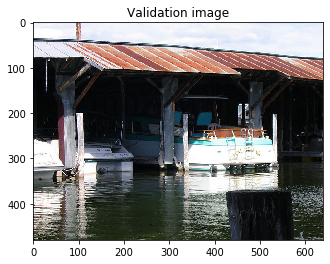

Original caption:  a boat sitting under a rusty metal roof 
Generated caption:  a large boat is floating in the water.
BLEU_1: Cumulative 1-gram: 0.111111
BLEU_2: Cumulative 2-gram: 0.000000
BLEU_3: Cumulative 3-gram: 0.000000
BLEU_4: Cumulative 4-gram: 0.000000


In [89]:
caption, pred_caption, bleu_1 = get_val_prediction()